# Proyecto Final

*Analitica Predictiva*

**Objetivo:** El objetivo de este proyecto es la predicción de corto y mediano plazo de el total de casos confirmados, los nuevos casos, los casos activos, recuperados y muertes para las 5 principales ciudades de Colombia, utilizando técnicas estadísticas, de inteligencia artificial o modelos híbridos.

##**Extracción de datos**

In [1]:
! pip install fbprophet

In [2]:
import requests
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
import seaborn as sns

from fbprophet import Prophet
# prophet preformance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [104]:
from google.colab import files
files

<module 'google.colab.files' from '/usr/local/lib/python3.6/dist-packages/google/colab/files.py'>

In [3]:
#para saber cuantas peticiones se deben hacer a la API, se extrae cuantos regristros hay almacenados
url_row = 'https://www.datos.gov.co/resource/gt2j-8ykr.json?$select=count(*)'
response_row = requests.request("GET", url_row)
response_json_row = response_row.json()
rows= int(response_json_row[0]['count'])
rows

658456

In [4]:
#Extracción de datos donde se le hace una petición cada 100000 registros 
start_page = 0
results_df = pd.DataFrame()

for i in range(100000,(rows+100000),100000):
  url= 'https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=100000&$offset=' + str(start_page)
  response = requests.request("GET", url)
  response_json = response.json()
  df = pd.DataFrame(response_json)
  results_df= results_df.append(df, ignore_index = True)
  start_page = i

In [5]:
results_df.shape

(658456, 21)

**Análisis de los Datos y Selección de Caracteristicas**

In [6]:
results_df.dtypes

id_de_caso               object
fecha_de_notificaci_n    object
c_digo_divipola          object
ciudad_de_ubicaci_n      object
departamento             object
atenci_n                 object
edad                     object
sexo                     object
tipo                     object
estado                   object
pa_s_de_procedencia      object
fis                      object
fecha_diagnostico        object
fecha_recuperado         object
fecha_reporte_web        object
tipo_recuperaci_n        object
codigo_departamento      object
codigo_pais              object
pertenencia_etnica       object
nombre_grupo_etnico      object
fecha_de_muerte          object
dtype: object

In [7]:
#Se toma fis (fecha inicio sintomas) como la fecha real de contagio y para los casos asintomaticos se toma la fecha de notificación
results_df['fis'] = np.where(results_df['fis'] == 'Asintomático', results_df['fecha_de_notificaci_n'], results_df['fis'] )

In [8]:
#Conversion de los formatos de los campos "fecha" a datetime
results_df['fecha_diagnostico'] = pd.to_datetime(results_df['fecha_diagnostico'], errors='coerce')
results_df['fecha_recuperado'] = pd.to_datetime(results_df['fecha_recuperado'], errors='coerce')
results_df['fecha_reporte_web'] = pd.to_datetime(results_df['fecha_reporte_web'], errors='coerce')
results_df['fis'] = pd.to_datetime(results_df['fis'], errors='coerce')
results_df['fecha_de_notificaci_n'] = pd.to_datetime(results_df['fecha_de_notificaci_n'], errors='coerce')
results_df['fecha_de_muerte'] = pd.to_datetime(results_df['fecha_de_muerte'], errors='coerce')

In [9]:
#Se seleccionan las 5 ciudades a analizar
results_df_cities = results_df[results_df['ciudad_de_ubicaci_n'].isin(['Bogotá D.C.', 'Medellín', 'Barranquilla', 'Cali', 'Cartagena de Indias'])]

In [10]:
results_df_cities.describe()

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
count,370777,370777,370777,370777,370777,370777,370777,370777,370777,370777,607,370777,368638,290120,370777,290116,370777,607,177016,4837,10974
unique,370777,183,5,5,5,6,106,4,6,6,44,298,181,174,181,2,5,40,4,867,166
top,206023,2020-08-26 00:00:00,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,30,F,En estudio,Leve,ESPAÑA,2020-07-24 00:00:00,2020-08-11 00:00:00,2020-08-23 00:00:00,2020-08-06 00:00:00,Tiempo,11,724,Otro,Sin Comunidad,2020-07-30 00:00:00
freq,1,7466,223522,223522,223522,290116,9799,185707,355018,275587,171,6472,11853,8915,8004,230454,223522,171,160383,1095,182
first,NaN,2020-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-27 00:00:00,2020-03-06 00:00:00,2020-03-13 00:00:00,2020-03-06 00:00:00,NaN,NaN,NaN,NaN,NaN,2020-03-16 00:00:00
last,NaN,2020-09-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-04 00:00:00,2020-09-05 00:00:00,2020-09-05 00:00:00,2020-09-05 00:00:00,NaN,NaN,NaN,NaN,NaN,2020-09-05 00:00:00


In [11]:
#Selección de variables
categoricas =['ciudad_de_ubicaci_n','atenci_n','edad','sexo','estado','tipo_recuperaci_n', 'fecha_de_muerte']
temporales =['fecha_de_notificaci_n','fis','fecha_diagnostico','fecha_recuperado']

In [12]:
results_df_cities = results_df_cities[categoricas + temporales]

In [13]:
results_df_cities.columns

Index(['ciudad_de_ubicaci_n', 'atenci_n', 'edad', 'sexo', 'estado',
       'tipo_recuperaci_n', 'fecha_de_muerte', 'fecha_de_notificaci_n', 'fis',
       'fecha_diagnostico', 'fecha_recuperado'],
      dtype='object')

In [14]:
#Se estandariza campo "Sexo"
results_df_cities['sexo'] = results_df_cities['sexo'].str.upper()

##**Preparación de los datos**

In [15]:
## Modificar "Tipo recuperación" donde
## Se asume recuperado por tiempo si después de fis + 30 días 
## y si no es mayor a 70 y no esta hospitalizado
## se pone fecha de recuperación = fis + 30 dias
## También con fecha muerte vácio
## Y fecha fis minimo igual fecha corte - 30 días
results_df_cities['edad'] = pd.to_numeric(results_df_cities['edad'])

results_df_cities['fecha_recuperado'] = np.where(
    (results_df_cities['fecha_de_muerte'].isna())
    & (results_df_cities['edad'] <= 70) 
    & (results_df_cities['fecha_recuperado'].isna())
    & (results_df_cities['atenci_n'] != 'Hospital')
    & (results_df_cities['atenci_n'] != 'Hospital UCI')
    & (results_df_cities['fis'] <= pd.to_datetime((date.today() - timedelta(30)))),
    results_df_cities['fis'] + timedelta(30),
    results_df_cities['fecha_recuperado']
)

In [16]:
#*******Creación de Sabana********

## Fallecido COVID

## Sin importan los campo "atencion" y  si tiene "fecha de muerte" se cuenta como 
## fallecimiento para ese día y no puede tener fecha de recuperación


covid_deads = results_df_cities[
                                (~results_df_cities['fecha_de_muerte'].isna())
                                & (results_df_cities['fecha_recuperado'].isna())
                                ]

gcovid_deads = covid_deads.groupby(
    [
     'fecha_de_muerte', 'ciudad_de_ubicaci_n' #, 'sexo', 'rango_edad'
     ]
    ).agg({'fecha_de_muerte': 'count'})

gcovid_deads.columns = ['conteo_muertes']
gcovid_deads = gcovid_deads.reset_index()
gcovid_deads = gcovid_deads.rename(columns={"fecha_de_muerte": "fecha"})

In [17]:
covid_deads.shape

(10840, 11)

In [18]:
## Recuperado COVID
## Con fecha de recuperación y no tenga fecha muerte

covid_recovered = results_df_cities[
                                (results_df_cities['fecha_de_muerte'].isna())
                                & (~results_df_cities['fecha_recuperado'].isna())
                                ]

gcovid_recovered = covid_recovered.groupby(
    [
     'fecha_recuperado', 'ciudad_de_ubicaci_n' #, 'sexo', 'rango_edad'
     ]
    ).agg({'fecha_recuperado': 'count'})

gcovid_recovered.columns = ['conteo_recuperados']
gcovid_recovered = gcovid_recovered.reset_index()
gcovid_recovered = gcovid_recovered.rename(columns={"fecha_recuperado": "fecha"})

In [19]:
covid_recovered.shape

(292820, 11)

In [20]:
## Activos COVID
## No puede tener fecha ni de muerte ni de recuperado
## fecha que prima es fecha fis

covid_active = results_df_cities[
                                (results_df_cities['fecha_de_muerte'].isna())
                                & (results_df_cities['fecha_recuperado'].isna())
                                ]

gcovid_active = covid_active.groupby(
    [
     'fis', 'ciudad_de_ubicaci_n' #, 'sexo',    'rango_edad'
     ]
    ).agg({'fis': 'count'})

gcovid_active.columns = ['conteo_activos']
gcovid_active = gcovid_active.reset_index()
gcovid_active = gcovid_active.rename(columns={"fis": "fecha"})


In [21]:
covid_active.shape

(66983, 11)

In [22]:
gcovid_active

,fecha,ciudad_de_ubicaci_n,conteo_activos
0,2020-04-10,Bogotá D.C.,1
1,2020-04-28,Cartagena de Indias,1
2,2020-05-07,Barranquilla,1
3,2020-05-11,Cali,1
4,2020-05-12,Barranquilla,1
...,...,...,...
336,2020-09-03,Bogotá D.C.,41
337,2020-09-03,Cali,2
338,2020-09-03,Medellín,26
339,2020-09-04,Bogotá D.C.,7


In [23]:
## Nuevos COVID
## Conteo por fecha fis
"""
Los datos de Casos Diarios deben siempre analizarse con la fecha registrada en la columna FIS (Fecha de Inicio de Síntomas).
La fecha de diagnóstico no refleja el inicio del caso. 
Es importante tener en cuenta que esta fecha de diagnóstico se ve afectada por (a) el tiempo que toma una muestra en llegar al laboratorio; 
(b) el tiempo de procesamiento de la muestra en el laboratorio; 
(c) el tiempo entre el procesamiento de la muestra y la expedición del resultado. 
Las fechas de diagnóstico, además, están sufriendo variaciones toda vez que los laboratorios están haciendo revisión 
y actualización de sus datos en el nuevo sistema SisMuestras.
"""

gcovid_new = results_df_cities.groupby(
    [
     'fis', 'ciudad_de_ubicaci_n' #, 'sexo', 'rango_edad'
     ]
    ).agg({'fis': 'count'})

gcovid_new.columns = ['conteo_nuevos']
gcovid_new = gcovid_new.reset_index()
gcovid_new = gcovid_new.rename(columns={"fis": "fecha"})

In [24]:
gcovid_new.tail()

,fecha,ciudad_de_ubicaci_n,conteo_nuevos
1013,2020-09-03,Bogotá D.C.,41
1014,2020-09-03,Cali,2
1015,2020-09-03,Medellín,26
1016,2020-09-04,Bogotá D.C.,7
1017,2020-09-04,Medellín,8


In [25]:
## Creacion sabana
sabana = gcovid_new.merge(
    gcovid_deads, how='left', 
    on=['fecha', 'ciudad_de_ubicaci_n' ] #, 'sexo', 'rango_edad']
    )

sabana = sabana.merge(
    gcovid_recovered, how='left', 
    on=['fecha', 'ciudad_de_ubicaci_n'] #, 'sexo', 'rango_edad']
    )
sabana = sabana.merge(
    gcovid_active, how='left', 
    on=['fecha', 'ciudad_de_ubicaci_n'] #, 'sexo', 'rango_edad']
    )

sabana.shape

(1018, 6)

In [26]:
sabana

,fecha,ciudad_de_ubicaci_n,conteo_nuevos,conteo_muertes,conteo_recuperados,conteo_activos
0,2020-02-27,Bogotá D.C.,1,NaN,NaN,NaN
1,2020-02-28,Bogotá D.C.,1,NaN,NaN,NaN
2,2020-02-29,Medellín,1,NaN,NaN,NaN
3,2020-03-01,Bogotá D.C.,3,NaN,NaN,NaN
4,2020-03-01,Cartagena de Indias,1,NaN,NaN,NaN
...,...,...,...,...,...,...
1013,2020-09-03,Bogotá D.C.,41,45.0,2175.0,41.0
1014,2020-09-03,Cali,2,11.0,497.0,2.0
1015,2020-09-03,Medellín,26,10.0,597.0,26.0
1016,2020-09-04,Bogotá D.C.,7,52.0,1058.0,7.0


In [27]:
### Orgdenar por ciudad y fecha
sabana2 = sabana.sort_values(
    by=['ciudad_de_ubicaci_n', 'fecha' ]
    )

### Cambiar nulos por 0
sabana2['conteo_nuevos'] = sabana2['conteo_nuevos'].fillna(0)
sabana2['conteo_muertes'] = sabana2['conteo_muertes'].fillna(0)
sabana2['conteo_recuperados'] = sabana2['conteo_recuperados'].fillna(0)
sabana2['conteo_activos'] = sabana2['conteo_activos'].fillna(0)
sabana2= sabana2.reset_index(drop=True)
sabana2 = sabana2[['fecha','ciudad_de_ubicaci_n','conteo_nuevos','conteo_activos','conteo_muertes','conteo_recuperados' ]] #,'Decreto', 'sexo','rango_edad',]]
sabana2

,fecha,ciudad_de_ubicaci_n,conteo_nuevos,conteo_activos,conteo_muertes,conteo_recuperados
0,2020-03-06,Barranquilla,2,0.0,0.0,0.0
1,2020-03-09,Barranquilla,2,0.0,0.0,0.0
2,2020-03-10,Barranquilla,2,0.0,0.0,0.0
3,2020-03-12,Barranquilla,2,0.0,0.0,0.0
4,2020-03-13,Barranquilla,2,0.0,0.0,0.0
...,...,...,...,...,...,...
1013,2020-08-31,Medellín,128,128.0,19.0,823.0
1014,2020-09-01,Medellín,91,91.0,13.0,1211.0
1015,2020-09-02,Medellín,76,76.0,12.0,902.0
1016,2020-09-03,Medellín,26,26.0,10.0,597.0


In [28]:
## Recalcular conteo activos como la suma de los casos nuevos del dia
## con los casos activos del dia anterior, menos el conteo de muertes
## menos el conteo de recuperados
### resetear conteo activos cuando cambia de ciudad

for index, row in sabana2.iterrows():
  if row['ciudad_de_ubicaci_n'] == sabana2.iloc[index-1,sabana2.columns.get_loc('ciudad_de_ubicaci_n')] and index > 0: #and row['sexo'] == sabana2.iloc[index-1,sabana2.columns.get_loc('sexo')] and row['rango_edad'] == sabana2.iloc[index-1,sabana2.columns.get_loc('rango_edad')] and index > 0:
    sabana2.iloc[index,3] =(sabana2.iloc[index-1,3] + row['conteo_nuevos'] - row['conteo_muertes'] - row['conteo_recuperados'])
  else:
    sabana2.iloc[index,3] = row['conteo_nuevos']
sabana2

,fecha,ciudad_de_ubicaci_n,conteo_nuevos,conteo_activos,conteo_muertes,conteo_recuperados
0,2020-03-06,Barranquilla,2,2.0,0.0,0.0
1,2020-03-09,Barranquilla,2,4.0,0.0,0.0
2,2020-03-10,Barranquilla,2,6.0,0.0,0.0
3,2020-03-12,Barranquilla,2,8.0,0.0,0.0
4,2020-03-13,Barranquilla,2,10.0,0.0,0.0
...,...,...,...,...,...,...
1013,2020-08-31,Medellín,128,14387.0,19.0,823.0
1014,2020-09-01,Medellín,91,13254.0,13.0,1211.0
1015,2020-09-02,Medellín,76,12416.0,12.0,902.0
1016,2020-09-03,Medellín,26,11835.0,10.0,597.0


In [29]:
## Creacion de casos confirmados
## Acumulativo de casos nuevos durante el tiempo
sabana2['casos_confirmados'] = 0

for index, row in sabana2.iterrows():
  if row['ciudad_de_ubicaci_n'] == sabana2.iloc[index-1,sabana2.columns.get_loc('ciudad_de_ubicaci_n')] and index > 0: #and row['sexo'] == sabana2.iloc[index-1,sabana2.columns.get_loc('sexo')] and row['rango_edad'] == sabana2.iloc[index-1,sabana2.columns.get_loc('rango_edad')] and index > 0:
    sabana2.iloc[index,6] =(sabana2.iloc[index-1,6] + row['conteo_nuevos'] )
  else:
    sabana2.iloc[index,6] = row['conteo_nuevos']
sabana2

,fecha,ciudad_de_ubicaci_n,conteo_nuevos,conteo_activos,conteo_muertes,conteo_recuperados,casos_confirmados
0,2020-03-06,Barranquilla,2,2.0,0.0,0.0,2
1,2020-03-09,Barranquilla,2,4.0,0.0,0.0,4
2,2020-03-10,Barranquilla,2,6.0,0.0,0.0,6
3,2020-03-12,Barranquilla,2,8.0,0.0,0.0,8
4,2020-03-13,Barranquilla,2,10.0,0.0,0.0,10
...,...,...,...,...,...,...,...
1013,2020-08-31,Medellín,128,14387.0,19.0,823.0,50741
1014,2020-09-01,Medellín,91,13254.0,13.0,1211.0,50832
1015,2020-09-02,Medellín,76,12416.0,12.0,902.0,50908
1016,2020-09-03,Medellín,26,11835.0,10.0,597.0,50934


##**Análisis Descriptivo**

In [30]:
results_df.sort_values('departamento')

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
17340,17381,2020-05-15,91001,Leticia,Amazonas,Recuperado,26,M,Relacionado,Asintomático,NaN,2020-05-15,2020-05-20,2020-06-04,2020-05-20,PCR,91,NaN,Otro,NaN,NaT
212686,212727,2020-07-12,91405,La Chorrera,Amazonas,Recuperado,19,M,Relacionado,Leve,NaN,2020-07-12,2020-07-22,2020-08-10,2020-07-22,Tiempo,91,NaN,Otro,NaN,NaT
212685,212726,2020-07-12,91405,La Chorrera,Amazonas,Recuperado,19,M,Relacionado,Leve,NaN,2020-07-12,2020-07-22,2020-08-10,2020-07-22,Tiempo,91,NaN,Otro,NaN,NaT
212684,212725,2020-07-12,91405,La Chorrera,Amazonas,Recuperado,23,M,Relacionado,Leve,NaN,2020-07-12,2020-07-22,2020-08-10,2020-07-22,Tiempo,91,NaN,Otro,NaN,NaT
10550,10591,2020-05-02,91001,Leticia,Amazonas,Recuperado,39,F,En estudio,Leve,NaN,2020-04-28,2020-05-10,2020-06-03,2020-05-10,Tiempo,91,NaN,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614178,614219,2020-08-18,99001,Puerto Carreño,Vichada,Recuperado,28,F,En estudio,Leve,NaN,2020-08-11,2020-08-29,2020-09-04,2020-08-31,Tiempo,99,NaN,NaN,NaN,NaT
614177,614218,2020-08-18,99001,Puerto Carreño,Vichada,Recuperado,40,M,En estudio,Leve,NaN,2020-08-11,2020-08-29,2020-09-04,2020-08-31,Tiempo,99,NaN,NaN,NaN,NaT
620031,620072,2020-08-19,99001,Puerto Carreño,Vichada,Casa,31,M,En estudio,Leve,NaN,2020-08-12,2020-08-30,NaT,2020-09-01,NaN,99,NaN,NaN,NaN,NaT
620037,620078,2020-08-19,99001,Puerto Carreño,Vichada,Casa,20,M,En estudio,Leve,NaN,2020-08-12,2020-08-30,NaT,2020-09-01,NaN,99,NaN,NaN,NaN,NaT


In [31]:
results_df['fecha_diagnostico'] = pd.to_datetime(results_df['fecha_diagnostico'], errors='coerce')
results_df['fecha_recuperado'] = pd.to_datetime(results_df['fecha_recuperado'], errors='coerce')
results_df['fecha_reporte_web'] = pd.to_datetime(results_df['fecha_reporte_web'], errors='coerce')
results_df['fecha_de_notificaci_n'] = pd.to_datetime(results_df['fecha_de_notificaci_n'], errors='coerce')
results_df['fecha_de_muerte'] = pd.to_datetime(results_df['fecha_de_muerte'], errors='coerce')
results_df['sexo'] = results_df['sexo'].str.upper()

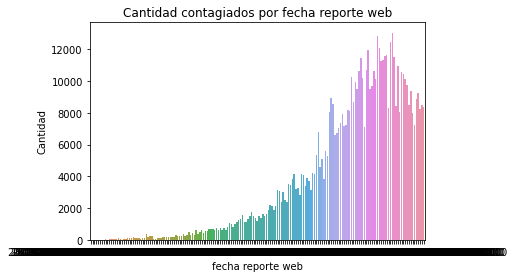

In [32]:
fig = sns.countplot(results_df['fecha_reporte_web'])
fig.set(xlabel='fecha reporte web', ylabel='Cantidad')
plt.title("Cantidad contagiados por fecha reporte web")
fig.get_figure().savefig('cantidad_fecha_reporte' + '.png')

In [33]:
##se crean rangos de edad que permita evaluar la afectación del virus
## en diferentes grupos poblacionales
results_df['edad'] = pd.to_numeric(results_df['edad'])
results_df['rango_edad'] = np.where(
    results_df['edad'] <= 30, 'Menores a 30',
        (np.where(
            (results_df['edad'] > 30) & (results_df['edad'] <= 58), '31 - 58',
            np.where(
                (results_df['edad'] > 58) & (results_df['edad'] <= 80), '59 - 80',
                '80 +'
                )
            )
        )
)


In [34]:
#cantidad de muertes por fecha
covid_deads = results_df[
                         (~results_df['fecha_de_muerte'].isna())
                         & (results_df['fecha_recuperado'].isna())
                        ]

gcovid_deads = covid_deads.groupby(
    [
      'rango_edad'
     ]
    ).agg({'fecha_de_muerte': 'count'})

gcovid_deads.columns = ['conteo_muertes']
gcovid_deads.reset_index(inplace=True)

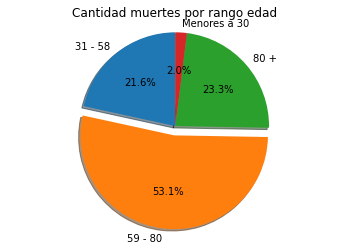

In [35]:
# Cantidad de muertes por rango de edad
labels = gcovid_deads['rango_edad']
sizes = gcovid_deads['conteo_muertes']
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Cantidad muertes por rango edad")
ax1.get_figure().savefig('cantidad_muertes_edades' + '.png')

In [36]:
## Recuperado COVID
## Con fecha de recuperación y no tenga fecha muerte

covid_recovered = results_df[
                                (results_df['fecha_de_muerte'].isna())
                                & (~results_df['fecha_recuperado'].isna())
                                ]

gcovid_recovered = covid_recovered.groupby(
    [
      'rango_edad'
     ]
    ).agg({'fecha_recuperado': 'count'})

gcovid_recovered.columns = ['conteo_recuperados']
gcovid_recovered = gcovid_recovered.reset_index()
gcovid_recovered = gcovid_recovered.rename(columns={"fecha_recuperado": "fecha"})


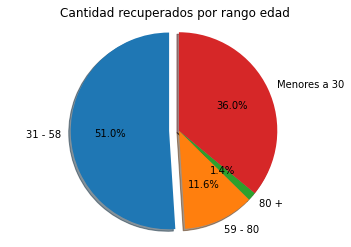

In [37]:
#Cantidad de recuperados por rango de edad
labels = gcovid_recovered['rango_edad']
sizes = gcovid_recovered['conteo_recuperados']
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Cantidad recuperados por rango edad")
ax1.get_figure().savefig('cantidad_recuperados_edades' + '.png')


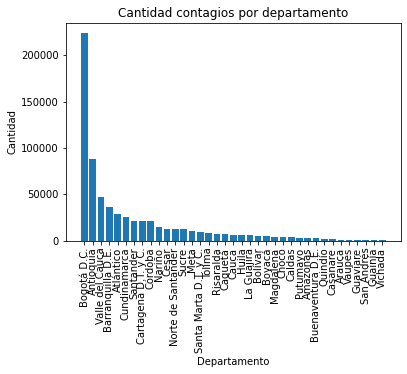

In [38]:
#Cantidad de contagios por departamento
results_df['departamento'] = np.where(
    results_df['departamento'] == 'Archipiélago de San Andrés Providencia y Santa Catalina', 
    'San Andrés', results_df['departamento'] 
    )
df = results_df.groupby('departamento').agg({'departamento': 'count'})                                      
df.columns = ['Cantidad']
df.reset_index(inplace=True)   
df = df.sort_values('Cantidad', ascending=False)
fig, ax = plt.subplots()
a = ax.bar(df['departamento'], df['Cantidad'], label='Cantidad')
plt.title("Cantidad contagios por departamento")
plt.xticks(rotation=90)
plt.xlabel('Departamento')
plt.ylabel('Cantidad')
plt.savefig('cantidad_departamento' + '.png',bbox_inches = 'tight')

Analizando los resultados descriptivos anteriores se observa:
1. Del total de las personas afectadas hasta la fecha, las de mayor mortilidad del virus son aquellas que están en el rango de edad entre 59-80 años
2. Aproximandamente el 80% personas recuperadas  son aquellas menores a los 58 años.
3. El departamento con mas casos confirmados el Bogotá, seguido de Antioquia y Valle  

In [39]:
## Grafico por ciudad a analizar

##Información Barranquilla
active_total_date_bqll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Barranquilla'].groupby(['fecha']).agg({'conteo_activos':['sum']})
fatalities_total_date_bqll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Barranquilla'].groupby(['fecha']).agg({'conteo_muertes':['sum']})
new_total_date_bqll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Barranquilla'].groupby(['fecha']).agg({'conteo_nuevos':['sum']})
recovered_total_date_bqll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Barranquilla'].groupby(['fecha']).agg({'conteo_recuperados':['sum']})

total_date_bqll = active_total_date_bqll.join(fatalities_total_date_bqll)
total_date_bqll = total_date_bqll.join(new_total_date_bqll)
total_date_bqll = total_date_bqll.join(recovered_total_date_bqll)


In [40]:
## Bogota
active_total_date_bgt = sabana2[sabana2['ciudad_de_ubicaci_n']=='Bogotá D.C.'].groupby(['fecha']).agg({'conteo_activos':['sum']})
fatalities_total_date_bgt = sabana2[sabana2['ciudad_de_ubicaci_n']=='Bogotá D.C.'].groupby(['fecha']).agg({'conteo_muertes':['sum']})
new_total_date_bgt = sabana2[sabana2['ciudad_de_ubicaci_n']=='Bogotá D.C.'].groupby(['fecha']).agg({'conteo_nuevos':['sum']})
recovered_total_date_bgt = sabana2[sabana2['ciudad_de_ubicaci_n']=='Bogotá D.C.'].groupby(['fecha']).agg({'conteo_recuperados':['sum']})

total_date_bgt = active_total_date_bgt.join(fatalities_total_date_bgt)
total_date_bgt = total_date_bgt.join(new_total_date_bgt)
total_date_bgt = total_date_bgt.join(recovered_total_date_bgt)

In [41]:
## Medellin
active_total_date_mdll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Medellín'].groupby(['fecha']).agg({'conteo_activos':['sum']})
fatalities_total_date_mdll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Medellín'].groupby(['fecha']).agg({'conteo_muertes':['sum']})
new_total_date_mdll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Medellín'].groupby(['fecha']).agg({'conteo_nuevos':['sum']})
recovered_total_date_mdll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Medellín'].groupby(['fecha']).agg({'conteo_recuperados':['sum']})

total_date_mdll = active_total_date_mdll.join(fatalities_total_date_mdll)
total_date_mdll = total_date_mdll.join(new_total_date_mdll)
total_date_mdll = total_date_mdll.join(recovered_total_date_mdll)

In [42]:
## Cali
active_total_date_Cali = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cali'].groupby(['fecha']).agg({'conteo_activos':['sum']})
fatalities_total_date_Cali = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cali'].groupby(['fecha']).agg({'conteo_muertes':['sum']})
new_total_date_Cali = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cali'].groupby(['fecha']).agg({'conteo_nuevos':['sum']})
recovered_total_date_Cali = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cali'].groupby(['fecha']).agg({'conteo_recuperados':['sum']})

total_date_Cali = active_total_date_Cali.join(fatalities_total_date_Cali)
total_date_Cali = total_date_Cali.join(new_total_date_Cali)
total_date_Cali = total_date_Cali.join(recovered_total_date_Cali)

In [43]:
## Cartagena
active_total_date_cartagena = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cartagena de Indias'].groupby(['fecha']).agg({'conteo_activos':['sum']})
fatalities_total_date_cartagena = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cartagena de Indias'].groupby(['fecha']).agg({'conteo_muertes':['sum']})
new_total_date_cartagena = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cartagena de Indias'].groupby(['fecha']).agg({'conteo_nuevos':['sum']})
recovered_total_date_cartagena = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cartagena de Indias'].groupby(['fecha']).agg({'conteo_recuperados':['sum']})

total_date_cartagena = active_total_date_cartagena.join(fatalities_total_date_cartagena)
total_date_cartagena = total_date_cartagena.join(new_total_date_cartagena)
total_date_cartagena = total_date_cartagena.join(recovered_total_date_cartagena)

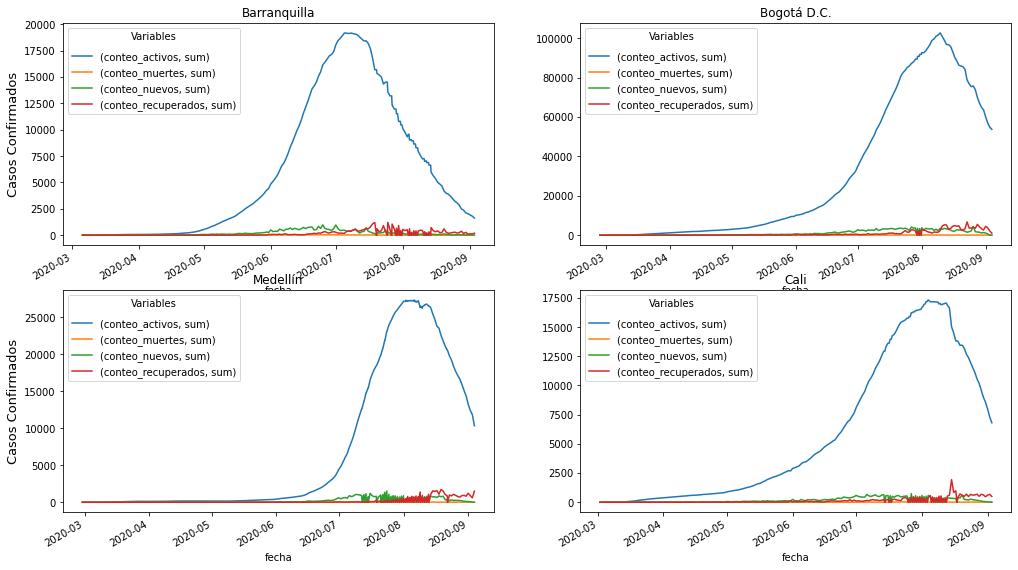

In [44]:
plt.figure(figsize=(17,10))
plt.subplot(2, 2, 1)
total_date_bqll.plot(ax=plt.gca(), title='Barranquilla')
plt.ylabel("Casos Confirmados", size=13)
legend = plt.legend(title="Variables")
legend._legend_box.sep = 10

plt.subplot(2, 2, 2)
total_date_bgt.plot(ax=plt.gca(), title='Bogotá D.C.')
legend = plt.legend(title="Variables")
legend._legend_box.sep = 10

plt.subplot(2, 2, 3)
total_date_mdll.plot(ax=plt.gca(), title='Medellín')
plt.ylabel("Casos Confirmados", size=13)
legend = plt.legend(title="Variables")
legend._legend_box.sep = 10

plt.subplot(2, 2, 4)
total_date_Cali.plot(ax=plt.gca(), title='Cali')
legend = plt.legend(title="Variables")
legend._legend_box.sep = 10

plt.savefig('ciudades_evolucion_virus' + '.png')

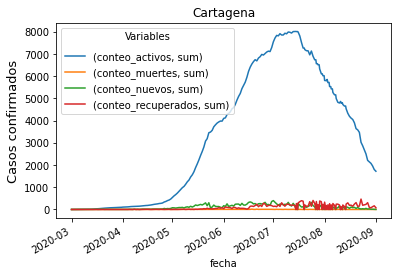

In [45]:
total_date_cartagena.plot(ax=plt.gca(), title='Cartagena')
plt.ylabel("Casos confirmados", size=13)
legend = plt.legend(title="Variables")
legend._legend_box.sep = 10
plt.savefig('ciudades_evolucion_virus_cartagena' + '.png')

Observando los resultados de cada uno de los tipos de casos en cada ciudad como activos, muertes, nuevos y recuperados, todas presentan comportamientos diferentes. Cabe destacar que a nivel de casos confirmados Barranquilla fue la primera ciudad en alcanzar el pico de contagios, el cual fue en el mes de Julio. En cuanto a los casos confirmados Bogotá es la de mayor casos vs las demás ciudades 

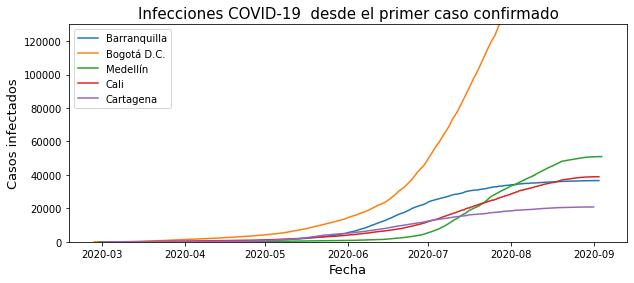

In [46]:
#casos confirmados
confirmed_total_date_cartagena = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cartagena de Indias'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
confirmed_total_date_bqll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Barranquilla'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
confirmed_total_date_bgt = sabana2[sabana2['ciudad_de_ubicaci_n']=='Bogotá D.C.'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
confirmed_total_date_mdll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Medellín'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
confirmed_total_date_Cali = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cali'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
# Plots
plt.figure(figsize=(10,4))
plt.plot(confirmed_total_date_bqll)
plt.plot(confirmed_total_date_bgt)
plt.plot(confirmed_total_date_mdll)
plt.plot(confirmed_total_date_Cali)
plt.plot(confirmed_total_date_cartagena)
plt.legend(["Barranquilla", "Bogotá D.C.", "Medellín", "Cali", "Cartagena"], loc='upper left')
plt.title("Infecciones COVID-19  desde el primer caso confirmado", size=15)
plt.xlabel("Fecha", size=13)
plt.ylabel("Casos infectados", size=13)
plt.ylim(0, 130000)

plt.savefig('ciudades_infecciones_primer_dia' + '.png')
plt.show()

Se observa en este gráfico que hasta la fecha, Bogotá presenta un mayor crecimiento de contagios con respecto a las 4 ciudades restantes.

In [47]:
#El modelo requiere el total de la población para cada ciudad a analizar
## Fuente Dane
## https://www.dane.gov.co/index.php/estadisticas-por-tema/mercado-laboral/empleo-y-desempleo
df_dane = pd.DataFrame({'Ciudad': ['Bogotá D.C.', 'Medellín', 'Barranquilla', 'Cali', 'Cartagena de Indias'],
                   '% población en edad de trabajar': [82.6, 84.7, 80.9, 82.8, 81.4],
                   'TGP': [58.7, 60.2, 56.6, 58.3, 48.6],
                   'TD': [23.6, 45.1, 15.9, 27.7, 19.4],
                   'T.D. Abierto': [22.0, 23.1, 13.4, 25.6, 15.3],
                   'T.D. Oculto': [1.6, 2.1, 2.5, 2.1, 4.1],
                   'Desocupados': [957 , 490, 141, 344, 78],
                   'Población en edad de trabajar' : [6894.16,3227.6,1564.29,2128.63,826.21],
                   'Población total' : [8351.22, 3809.84, 1933.13, 2571.86, 1015.28],
                   'Ocupados': [3092, 1455, 744, 898, 324],
                   'Población económicamente activa':[4049.36,1944.56,885.67,1241.91,401.25]
                   })

In [48]:
df_dane[df_dane['Ciudad'] == 'Cartagena de Indias']['Población total']

4    1015.28
Name: Población total, dtype: float64

In [49]:
sabana2.head()

,fecha,ciudad_de_ubicaci_n,conteo_nuevos,conteo_activos,conteo_muertes,conteo_recuperados,casos_confirmados
0,2020-03-06,Barranquilla,2,2.0,0.0,0.0,2
1,2020-03-09,Barranquilla,2,4.0,0.0,0.0,4
2,2020-03-10,Barranquilla,2,6.0,0.0,0.0,6
3,2020-03-12,Barranquilla,2,8.0,0.0,0.0,8
4,2020-03-13,Barranquilla,2,10.0,0.0,0.0,10


In [50]:
## Fraccion de contagios por poblacion
## Casos confirmados sobre la poblacion total de la ciudad
confirmed_total_date_cartagena = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cartagena de Indias'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
confirmed_total_date_cartagena['ConfirmedCases'] = confirmed_total_date_cartagena.casos_confirmados/(float(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Cartagena de Indias']['Población total'])*100))

confirmed_total_date_brq = sabana2[sabana2['ciudad_de_ubicaci_n']=='Barranquilla'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
confirmed_total_date_brq['ConfirmedCases'] = confirmed_total_date_brq.casos_confirmados/(float(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Barranquilla']['Población total'])*100))

confirmed_total_date_bgt = sabana2[sabana2['ciudad_de_ubicaci_n']=='Bogotá D.C.'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
confirmed_total_date_bgt['ConfirmedCases'] = confirmed_total_date_bgt.casos_confirmados/(float(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Bogotá D.C.']['Población total'])*100))

confirmed_total_date_mdll = sabana2[sabana2['ciudad_de_ubicaci_n']=='Medellín'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
confirmed_total_date_mdll['ConfirmedCases'] = confirmed_total_date_mdll.casos_confirmados/(float(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Medellín']['Población total'])*100))

confirmed_total_date_cali = sabana2[sabana2['ciudad_de_ubicaci_n']=='Cali'].groupby(['fecha']).agg({'casos_confirmados':['sum']})
confirmed_total_date_cali['ConfirmedCases'] = confirmed_total_date_cali.casos_confirmados/(float(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Cali']['Población total'])*100))

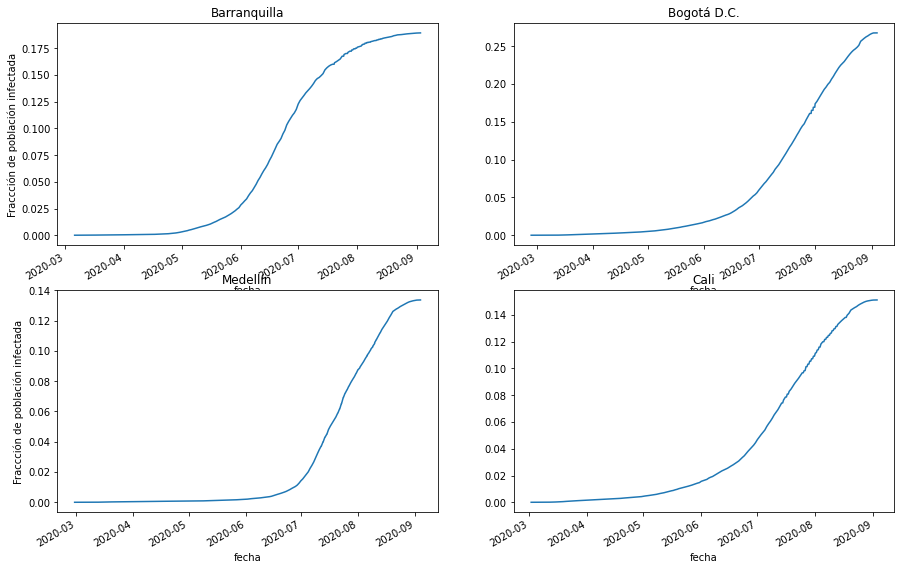

In [51]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
confirmed_total_date_brq.ConfirmedCases.plot(ax=plt.gca(), title='Barranquilla')
plt.ylabel("Fraccción de población infectada")

plt.subplot(2, 2, 2)
confirmed_total_date_bgt.ConfirmedCases.plot(ax=plt.gca(), title='Bogotá D.C.')

plt.subplot(2, 2, 3)
confirmed_total_date_mdll.ConfirmedCases.plot(ax=plt.gca(), title='Medellín')
plt.ylabel("Fraccción de población infectada")

plt.subplot(2, 2, 4)
confirmed_total_date_cali.ConfirmedCases.plot(ax=plt.gca(), title='Cali')
plt.savefig('fraccion_poblacion_infectada' + '.png')

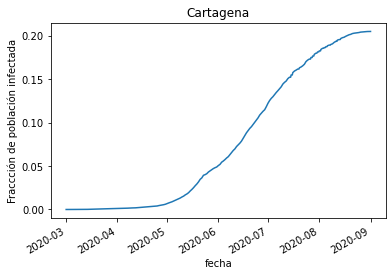

In [52]:
confirmed_total_date_cartagena.ConfirmedCases.plot(ax=plt.gca(), title='Cartagena')
plt.ylabel("Fraccción de población infectada")
plt.savefig('fraccion_poblacion_infectada_cartagena' + '.png')

El porcentaje de la población afectada a la fecha en cada ciudad no supera aproximadamente el 25 % 

##**Modelo SIR**

Para este modelo de toma como población inicial, la totalidad de personas en cada ciudad según el reporte DANE del último trimestre.
Para hallar las tasas de contagio, se calcula un promedio entre todas las tasas de contagio presentes desde el inicio de casos reportados por ciudad

In [53]:
sabana4= sabana2.copy()

In [54]:
#tasas contagios, recuperacion, fatalidad las cuales se calculan fecha a fecha
sabana4['tasa_contagio'] = 0
sabana4['tasa_recuperacion'] = 0
sabana4['tasa_fatalidad'] = 0

for index, row in sabana4.iterrows():
  if row['ciudad_de_ubicaci_n'] == sabana4.iloc[index-1,sabana4.columns.get_loc('ciudad_de_ubicaci_n')] and index > 0:
    sabana4.iloc[index,7] =(sabana4.iloc[index,2] / sabana4.iloc[index-1,3])
    sabana4.iloc[index,8] =(sabana4.iloc[index,5] / sabana4.iloc[index-1,3])
    sabana4.iloc[index,9] =(sabana4.iloc[index,4] / sabana4.iloc[index-1,3])
  else:
    sabana4.iloc[index,7] = 0
    sabana4.iloc[index,8] = 0
    sabana4.iloc[index,9] = 0

In [55]:
sabana4.tail()

,fecha,ciudad_de_ubicaci_n,conteo_nuevos,conteo_activos,conteo_muertes,conteo_recuperados,casos_confirmados,tasa_contagio,tasa_recuperacion,tasa_fatalidad
1013,2020-08-31,Medellín,128,14387.0,19.0,823.0,50741,0.008476,0.054500,0.001258
1014,2020-09-01,Medellín,91,13254.0,13.0,1211.0,50832,0.006325,0.084173,0.000904
1015,2020-09-02,Medellín,76,12416.0,12.0,902.0,50908,0.005734,0.068055,0.000905
1016,2020-09-03,Medellín,26,11835.0,10.0,597.0,50934,0.002094,0.048083,0.000805
1017,2020-09-04,Medellín,8,10332.0,12.0,1499.0,50942,0.000676,0.126658,0.001014


In [56]:
# promedio tasas calculadas en el paso anterior
prom_tasas = sabana4.groupby('ciudad_de_ubicaci_n').agg({'tasa_contagio':'mean','tasa_recuperacion':'mean','tasa_fatalidad':'mean' }) 
prom_tasas = prom_tasas.reset_index()
prom_tasas

,ciudad_de_ubicaci_n,tasa_contagio,tasa_recuperacion,tasa_fatalidad
0,Barranquilla,0.061496,0.021582,0.001367
1,Bogotá D.C.,0.086566,0.018478,0.001077
2,Cali,0.067520,0.016406,0.001191
3,Cartagena de Indias,0.069527,0.021542,0.001734
4,Medellín,0.067981,0.019263,0.000393


In [57]:
##Creación de los dataframe para cada ciudad

#Datataframe Bogota
poblacion_bgt =int(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Bogotá D.C.']['Población total']))*1000
fechas_bgt= pd.date_range(pd.to_datetime(min(sabana2[sabana2['ciudad_de_ubicaci_n'] == 'Bogotá D.C.']['fecha'])),pd.to_datetime((date.today() + timedelta(10)))).tolist()
sir_bgt = pd.DataFrame(fechas_bgt) 
sir_bgt= sir_bgt.rename(columns={0:'fechas'})
sir_bgt[
        ['susceptibles','total_confirmados','total_recuperados','total_muertos','contagios', 'recuperados','muertos','activos','ciudad_de_ubicaci_n']
        ] = pd.DataFrame([[0,0,0,0,0,0,0,0,'Bogotá D.C.']],index=sir_bgt.index)
sir_bgt[['poblacion']]= pd.DataFrame([[poblacion_bgt]],index=sir_bgt.index)

sir_bgt

,fechas,susceptibles,total_confirmados,total_recuperados,total_muertos,contagios,recuperados,muertos,activos,ciudad_de_ubicaci_n,poblacion
0,2020-02-27,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000
1,2020-02-28,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000
2,2020-02-29,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000
3,2020-03-01,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000
4,2020-03-02,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000
...,...,...,...,...,...,...,...,...,...,...,...
198,2020-09-12,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000
199,2020-09-13,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000
200,2020-09-14,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000
201,2020-09-15,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000


In [58]:
#datataframe Medellín
poblacion_med =int(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Medellín']['Población total']))*1000
fechas_med= pd.date_range(pd.to_datetime(min(sabana2[sabana2['ciudad_de_ubicaci_n'] == 'Medellín']['fecha'])),pd.to_datetime((date.today() + timedelta(10)))).tolist()
sir_med = pd.DataFrame(fechas_med) 
sir_med= sir_med.rename(columns={0:'fechas'})
sir_med[
        ['susceptibles','total_confirmados','total_recuperados','total_muertos','contagios', 'recuperados','muertos','activos','ciudad_de_ubicaci_n']
        ] = pd.DataFrame([[0,0,0,0,0,0,0,0,'Medellín']],index=sir_med.index)
sir_med[['poblacion']]= pd.DataFrame([[poblacion_med]],index=sir_med.index)

sir_med.head()

,fechas,susceptibles,total_confirmados,total_recuperados,total_muertos,contagios,recuperados,muertos,activos,ciudad_de_ubicaci_n,poblacion
0,2020-02-29,0,0,0,0,0,0,0,0,Medellín,3809000
1,2020-03-01,0,0,0,0,0,0,0,0,Medellín,3809000
2,2020-03-02,0,0,0,0,0,0,0,0,Medellín,3809000
3,2020-03-03,0,0,0,0,0,0,0,0,Medellín,3809000
4,2020-03-04,0,0,0,0,0,0,0,0,Medellín,3809000


In [59]:
#datataframe Cali
poblacion_cali =int(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Cali']['Población total']))*1000
fechas_cali= pd.date_range(pd.to_datetime(min(sabana2[sabana2['ciudad_de_ubicaci_n'] == 'Cali']['fecha'])),pd.to_datetime((date.today() + timedelta(10)))).tolist()
sir_cali = pd.DataFrame(fechas_cali) 
sir_cali= sir_cali.rename(columns={0:'fechas'})
sir_cali[
        ['susceptibles','total_confirmados','total_recuperados','total_muertos','contagios', 'recuperados','muertos','activos','ciudad_de_ubicaci_n']
        ] = pd.DataFrame([[0,0,0,0,0,0,0,0,'Cali']],index=sir_cali.index)
sir_cali[['poblacion']]= pd.DataFrame([[poblacion_cali]],index=sir_cali.index)

sir_cali.head()

,fechas,susceptibles,total_confirmados,total_recuperados,total_muertos,contagios,recuperados,muertos,activos,ciudad_de_ubicaci_n,poblacion
0,2020-03-02,0,0,0,0,0,0,0,0,Cali,2571000
1,2020-03-03,0,0,0,0,0,0,0,0,Cali,2571000
2,2020-03-04,0,0,0,0,0,0,0,0,Cali,2571000
3,2020-03-05,0,0,0,0,0,0,0,0,Cali,2571000
4,2020-03-06,0,0,0,0,0,0,0,0,Cali,2571000


In [60]:
#datataframe Barranquilla
poblacion_bll =int(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Barranquilla']['Población total']))*1000
fechas_bll= pd.date_range(pd.to_datetime(min(sabana2[sabana2['ciudad_de_ubicaci_n'] == 'Barranquilla']['fecha'])),pd.to_datetime((date.today() + timedelta(10)))).tolist()
sir_bll = pd.DataFrame(fechas_bll) 
sir_bll= sir_bll.rename(columns={0:'fechas'})
sir_bll[
        ['susceptibles','total_confirmados','total_recuperados','total_muertos','contagios', 'recuperados','muertos','activos','ciudad_de_ubicaci_n']
        ] = pd.DataFrame([[0,0,0,0,0,0,0,0,'Barranquilla']],index=sir_bll.index)
sir_bll[['poblacion']]= pd.DataFrame([[poblacion_bll]],index=sir_bll.index)

sir_bll.head()

,fechas,susceptibles,total_confirmados,total_recuperados,total_muertos,contagios,recuperados,muertos,activos,ciudad_de_ubicaci_n,poblacion
0,2020-03-06,0,0,0,0,0,0,0,0,Barranquilla,1933000
1,2020-03-07,0,0,0,0,0,0,0,0,Barranquilla,1933000
2,2020-03-08,0,0,0,0,0,0,0,0,Barranquilla,1933000
3,2020-03-09,0,0,0,0,0,0,0,0,Barranquilla,1933000
4,2020-03-10,0,0,0,0,0,0,0,0,Barranquilla,1933000


In [61]:
#datataframe Cartagena de Indias
poblacion_cart = int(pd.to_numeric(df_dane[df_dane['Ciudad'] == 'Cartagena de Indias']['Población total']))*1000
fechas_cart= pd.date_range(pd.to_datetime(min(sabana2[sabana2['ciudad_de_ubicaci_n'] == 'Cartagena de Indias']['fecha'])),pd.to_datetime((date.today() + timedelta(10)))).tolist()
sir_cart = pd.DataFrame(fechas_cart) 
sir_cart= sir_cart.rename(columns={0:'fechas'})
sir_cart[
        ['susceptibles','total_confirmados','total_recuperados','total_muertos','contagios', 'recuperados','muertos','activos','ciudad_de_ubicaci_n']
        ] = pd.DataFrame([[0,0,0,0,0,0,0,0,'Cartagena de Indias']],index=sir_cart.index)
sir_cart[['poblacion']]= pd.DataFrame([[poblacion_cart]],index=sir_cart.index)

sir_cart.head()

,fechas,susceptibles,total_confirmados,total_recuperados,total_muertos,contagios,recuperados,muertos,activos,ciudad_de_ubicaci_n,poblacion
0,2020-03-01,0,0,0,0,0,0,0,0,Cartagena de Indias,1015000
1,2020-03-02,0,0,0,0,0,0,0,0,Cartagena de Indias,1015000
2,2020-03-03,0,0,0,0,0,0,0,0,Cartagena de Indias,1015000
3,2020-03-04,0,0,0,0,0,0,0,0,Cartagena de Indias,1015000
4,2020-03-05,0,0,0,0,0,0,0,0,Cartagena de Indias,1015000


In [62]:
#creacion sabana final
sabana_sir= pd.concat([sir_bgt,sir_bll,sir_cali,sir_cart,sir_med])
sabana_sir = sabana_sir.reset_index(drop=True)
sabana_sir= sabana_sir.merge(prom_tasas,how='left',on='ciudad_de_ubicaci_n')
sabana_sir.head()

,fechas,susceptibles,total_confirmados,total_recuperados,total_muertos,contagios,recuperados,muertos,activos,ciudad_de_ubicaci_n,poblacion,tasa_contagio,tasa_recuperacion,tasa_fatalidad
0,2020-02-27,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000,0.086566,0.018478,0.001077
1,2020-02-28,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000,0.086566,0.018478,0.001077
2,2020-02-29,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000,0.086566,0.018478,0.001077
3,2020-03-01,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000,0.086566,0.018478,0.001077
4,2020-03-02,0,0,0,0,0,0,0,0,Bogotá D.C.,8351000,0.086566,0.018478,0.001077


In [63]:
#calculo SIR
sabana_sir.sort_values(['ciudad_de_ubicaci_n','fechas'])

for index, row in sabana_sir.iterrows():
  if row['ciudad_de_ubicaci_n'] == sabana_sir.iloc[index-1,sabana_sir.columns.get_loc('ciudad_de_ubicaci_n')] and index > 0:
    sabana_sir.iloc[index,5] =  round((round(sabana_sir.iloc[index,11],6) * sabana_sir.iloc[index-1,8]*sabana_sir.iloc[index-1,1]/sabana_sir.iloc[index,10]),6)   #contagios
    sabana_sir.iloc[index,6] = round((sabana_sir.iloc[index-1,8] * round(sabana_sir.iloc[index,12],6)),6)   #recuperados
    sabana_sir.iloc[index,7] = round((sabana_sir.iloc[index-1,8] * round(sabana_sir.iloc[index,13],6)),6)   #muertos
    sabana_sir.iloc[index,8] = round((sabana_sir.iloc[index,5] + sabana_sir.iloc[index-1,8] - sabana_sir.iloc[index,6] - sabana_sir.iloc[index,7]),6)   #activos
    #totales
    sabana_sir.iloc[index,1] = round((sabana_sir.iloc[index-1,1] - sabana_sir.iloc[index,5]),6)  #susceptibles
    sabana_sir.iloc[index,2] = round((sabana_sir.iloc[index,5] + sabana_sir.iloc[index-1,2]),6)  #total confirmados
    sabana_sir.iloc[index,3] = round((sabana_sir.iloc[index,6] + sabana_sir.iloc[index-1,3]),6)   #total recuperados
    sabana_sir.iloc[index,4] = round((sabana_sir.iloc[index,7] + sabana_sir.iloc[index-1,4]),6) # total muertos
  else:
    sabana_sir.iloc[index,2] = 1
    sabana_sir.iloc[index,1] = sabana_sir.iloc[index,10] - 1
    sabana_sir.iloc[index,8] = 1

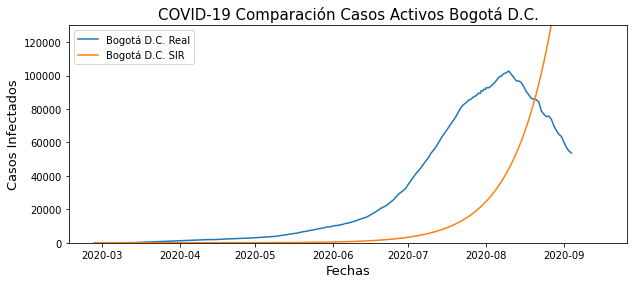

In [64]:
#comparación casos activos sir vs data original
active_sir_bgt= sabana_sir[sabana_sir['ciudad_de_ubicaci_n']=='Bogotá D.C.'].groupby(['fechas']).agg({'activos':['sum']})

# Plots
plt.figure(figsize=(10,4))
plt.plot(active_total_date_bgt)
plt.plot(active_sir_bgt)
plt.legend(["Bogotá D.C. Real", "Bogotá D.C. SIR"], loc='upper left')
plt.title("COVID-19 Comparación Casos Activos Bogotá D.C.", size=15)
plt.xlabel("Fechas", size=13)
plt.ylabel("Casos Infectados", size=13)
plt.ylim(0, 130000)

plt.savefig('Bogota_SIR_Activos' + '.png')
plt.show()

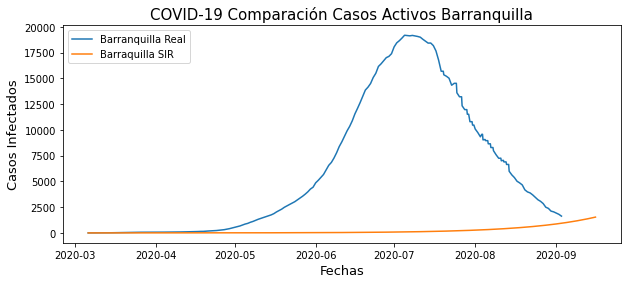

In [65]:
#comparación casos activos sir vs data original
active_sir_bll= sabana_sir[sabana_sir['ciudad_de_ubicaci_n']=='Barranquilla'].groupby(['fechas']).agg({'activos':['sum']})

# Plots
plt.figure(figsize=(10,4))
plt.plot(active_total_date_bqll)
plt.plot(active_sir_bll)
plt.legend(["Barranquilla Real", "Barraquilla SIR"], loc='upper left')
plt.title("COVID-19 Comparación Casos Activos Barranquilla", size=15)
plt.xlabel("Fechas", size=13)
plt.ylabel("Casos Infectados", size=13)
#plt.ylim(0, 130000)

plt.savefig('Barranquilla_SIR_Activos' + '.png')
plt.show()

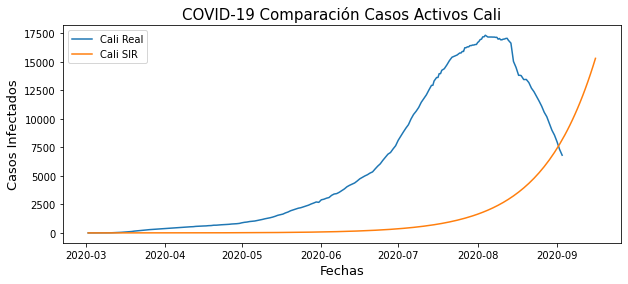

In [66]:
#comparación casos activos sir vs data original
active_sir_cali = sabana_sir[sabana_sir['ciudad_de_ubicaci_n']=='Cali'].groupby(['fechas']).agg({'activos':['sum']})

# Plots
plt.figure(figsize=(10,4))
plt.plot(active_total_date_Cali)
plt.plot(active_sir_cali)
plt.legend(["Cali Real", "Cali SIR"], loc='upper left')
plt.title("COVID-19 Comparación Casos Activos Cali", size=15)
plt.xlabel("Fechas", size=13)
plt.ylabel("Casos Infectados", size=13)
#plt.ylim(0, 130000)

plt.savefig('Cali_SIR_Activos' + '.png')
plt.show()

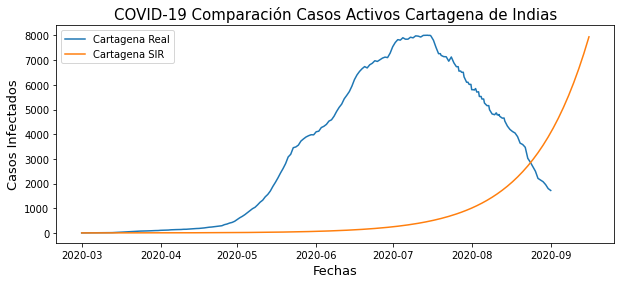

In [67]:
active_sir_cartagena = sabana_sir[sabana_sir['ciudad_de_ubicaci_n']=='Cartagena de Indias'].groupby(['fechas']).agg({'activos':['sum']})

# Plots
plt.figure(figsize=(10,4))
plt.plot(active_total_date_cartagena)
plt.plot(active_sir_cartagena)
plt.legend(["Cartagena Real", "Cartagena SIR"], loc='upper left')
plt.title("COVID-19 Comparación Casos Activos Cartagena de Indias", size=15)
plt.xlabel("Fechas", size=13)
plt.ylabel("Casos Infectados", size=13)
#plt.ylim(0, 130000)

plt.savefig('Cartagena_SIR_Activos' + '.png')
plt.show()

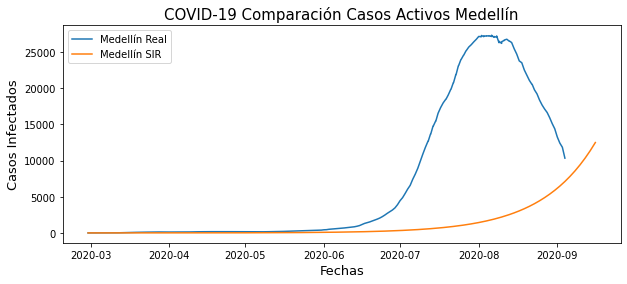

In [68]:
active_sir_med = sabana_sir[sabana_sir['ciudad_de_ubicaci_n']=='Medellín'].groupby(['fechas']).agg({'activos':['sum']})

# Plots
plt.figure(figsize=(10,4))
plt.plot(active_total_date_mdll)
plt.plot(active_sir_med)
plt.legend(["Medellín Real", "Medellín SIR"], loc='upper left')
plt.title("COVID-19 Comparación Casos Activos Medellín", size=15)
plt.xlabel("Fechas", size=13)
plt.ylabel("Casos Infectados", size=13)
#plt.ylim(0, 130000)

plt.savefig('Medellin_SIR_Activos' + '.png')
plt.show()

Para el modelo SIR, se ejecutó con algunas variantes, para lograr analizar cuál de estos lograba ajustarse mejor a la curva de casos activos para cada ciudad.

Una de la variantes fue tomando las tasas promedio para los últimos 10 días reportados y asumiento población susceptible de 100.000 personas para cada ciudad, con esto se obtuvo resultados con una curva de activos muy lejana a los datos reales.

**Concluyendo** con el Modelo SIR, no se toma en cuenta sus resultados para la predicción final, debido a:
1. Sus parámetros de entrada son muy inciertos.
2. Su comportamiento genera un pico de contagios para la población susceptible, lo cual no permite seguir tendencias de comportamiento del virus en escenarios reales, como por ejemplo un caso de posteriores oleadas de contagios.
3. Con la simulación que obtuvimos mejores resultados, el pico de casos activos da en fechas muy lejanas, por lo que no se puede utilizar para pronóstico a corto plazo desde la fecha actual.

##**Modelo Prophet**

Este modelo fué desarrollado por facebook y se encuentra disponible para Python y R, es una librería que permite construir modelos de ajuste y pronósticos de series. Es útil para conjunto de datos con las siguientes características:  datos con tendencias de crecimiento no lineal que se aproximen a un límite, que les falten puntos de datos o tengan casos atípicos grandes, que incluyan eventos anteriormente conocidos importantes, pero irregulares, entre otros.

Para mayor información digirse a : [Pagina_Prophet](https:/https://facebook.github.io/prophet//)


In [69]:
#Enriquecimiento de los datos de los contagios, usando los datos del DANE
sabana3 = sabana2.merge(df_dane, left_on=["ciudad_de_ubicaci_n"], right_on=['Ciudad'])
sabana3.drop(['Ciudad'], inplace=True, axis=1)
sabana3.head()

,fecha,ciudad_de_ubicaci_n,conteo_nuevos,conteo_activos,conteo_muertes,conteo_recuperados,casos_confirmados,% población en edad de trabajar,TGP,TD,T.D. Abierto,T.D. Oculto,Desocupados,Población en edad de trabajar,Población total,Ocupados,Población económicamente activa
0,2020-03-06,Barranquilla,2,2.0,0.0,0.0,2,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
1,2020-03-09,Barranquilla,2,4.0,0.0,0.0,4,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
2,2020-03-10,Barranquilla,2,6.0,0.0,0.0,6,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
3,2020-03-12,Barranquilla,2,8.0,0.0,0.0,8,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
4,2020-03-13,Barranquilla,2,10.0,0.0,0.0,10,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67


In [70]:
## Verificación de valores null
missings_count = {col:sabana3[col].isnull().sum() for col in sabana3.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                                 0
fecha                            0
TD                               0
Ocupados                         0
Población total                  0
Población en edad de trabajar    0
Desocupados                      0
T.D. Oculto                      0
T.D. Abierto                     0
TGP                              0
ciudad_de_ubicaci_n              0
% población en edad de trabajar  0
casos_confirmados                0
conteo_recuperados               0
conteo_muertes                   0
conteo_activos                   0
conteo_nuevos                    0
Población económicamente activa  0


In [71]:
#Selección de variables numéricas y categoricas
vars_numerical= sabana3.select_dtypes(exclude=['O', 'datetime64'])
vars_categorycal= sabana3.select_dtypes(include='O')
vars_date = sabana3.select_dtypes(include='datetime64')

In [72]:
# Codificar las ciudades
le = preprocessing.LabelEncoder()
vars_categorycal['ciudad_de_ubicaci_n'] =  le.fit_transform(vars_categorycal)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
## Guardar tranformacion de categoricas
number_c = vars_categorycal['ciudad_de_ubicaci_n']
cities = le.inverse_transform(vars_categorycal['ciudad_de_ubicaci_n'])
cities_dict = dict(zip(cities, number_c)) 
cities_dict

{'Barranquilla': 0,
 'Bogotá D.C.': 1,
 'Cali': 2,
 'Cartagena de Indias': 3,
 'Medellín': 4}

In [74]:
enc_sabana = pd.concat([vars_date, vars_categorycal, vars_numerical], axis=1)
enc_sabana.head()

,fecha,ciudad_de_ubicaci_n,conteo_nuevos,conteo_activos,conteo_muertes,conteo_recuperados,casos_confirmados,% población en edad de trabajar,TGP,TD,T.D. Abierto,T.D. Oculto,Desocupados,Población en edad de trabajar,Población total,Ocupados,Población económicamente activa
0,2020-03-06,0,2,2.0,0.0,0.0,2,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
1,2020-03-09,0,2,4.0,0.0,0.0,4,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
2,2020-03-10,0,2,6.0,0.0,0.0,6,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
3,2020-03-12,0,2,8.0,0.0,0.0,8,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
4,2020-03-13,0,2,10.0,0.0,0.0,10,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67


In [75]:
import warnings
warnings.filterwarnings("ignore")

In [76]:
enc_sabana.columns.values

array(['fecha', 'ciudad_de_ubicaci_n', 'conteo_nuevos', 'conteo_activos',
       'conteo_muertes', 'conteo_recuperados', 'casos_confirmados',
       '% población en edad de trabajar', 'TGP', 'TD', 'T.D. Abierto',
       'T.D. Oculto', 'Desocupados', 'Población en edad de trabajar',
       'Población total', 'Ocupados', 'Población económicamente activa'],
      dtype=object)

In [77]:
enc_sabana.head()

,fecha,ciudad_de_ubicaci_n,conteo_nuevos,conteo_activos,conteo_muertes,conteo_recuperados,casos_confirmados,% población en edad de trabajar,TGP,TD,T.D. Abierto,T.D. Oculto,Desocupados,Población en edad de trabajar,Población total,Ocupados,Población económicamente activa
0,2020-03-06,0,2,2.0,0.0,0.0,2,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
1,2020-03-09,0,2,4.0,0.0,0.0,4,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
2,2020-03-10,0,2,6.0,0.0,0.0,6,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
3,2020-03-12,0,2,8.0,0.0,0.0,8,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67
4,2020-03-13,0,2,10.0,0.0,0.0,10,80.9,56.6,15.9,13.4,2.5,141,1564.29,1933.13,744,885.67


In [78]:
labels =['conteo_nuevos', 'conteo_activos',
       'conteo_muertes', 'conteo_recuperados','casos_confirmados']
ciudades_principales=enc_sabana['ciudad_de_ubicaci_n'].unique()   
#variables = ['fecha','ciudad_de_ubicaci_n','Población total', 'TD']
variables = ['fecha','ciudad_de_ubicaci_n']

import datetime as dt
from sklearn import metrics

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

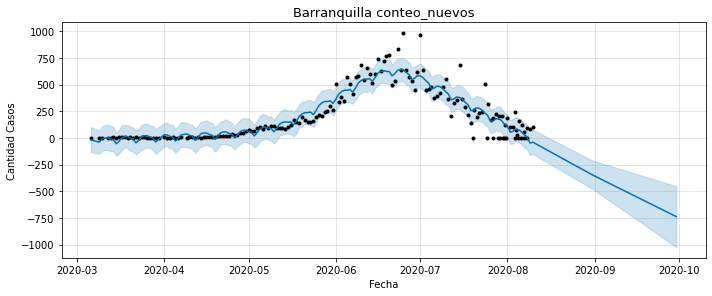

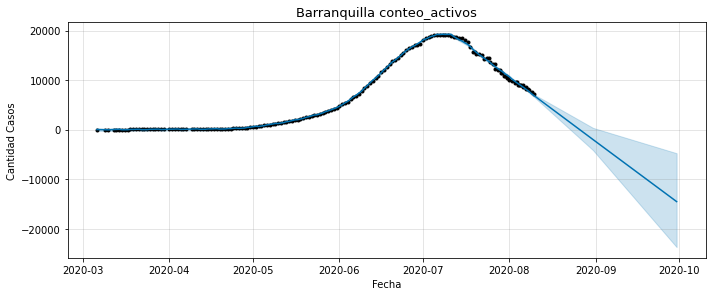

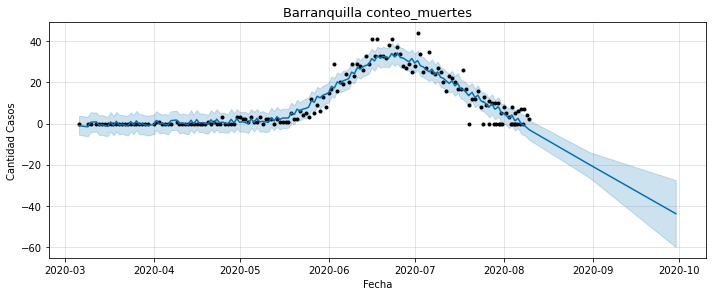

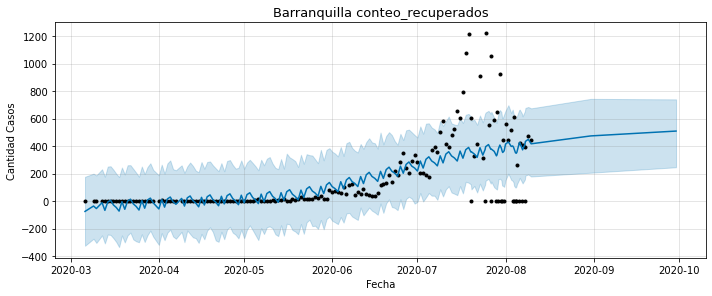

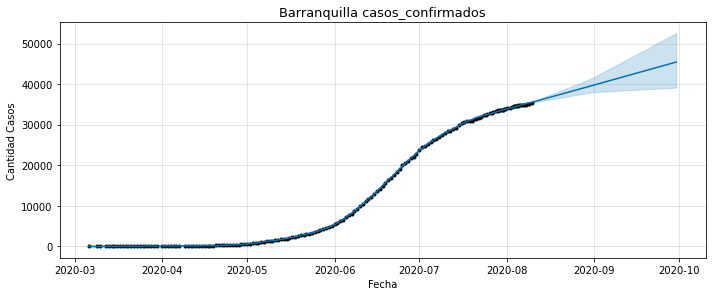

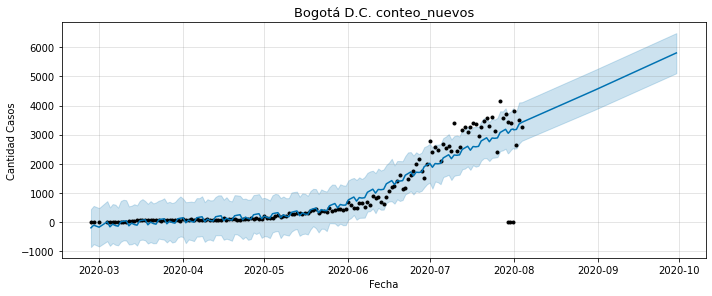

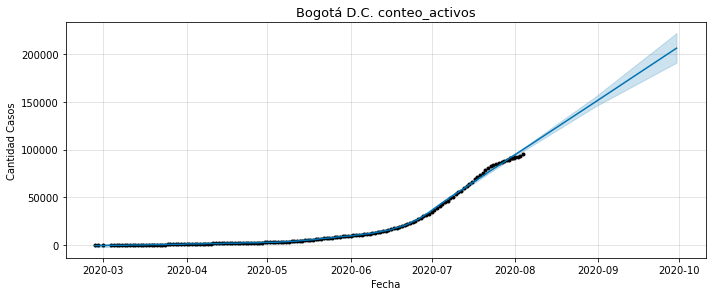

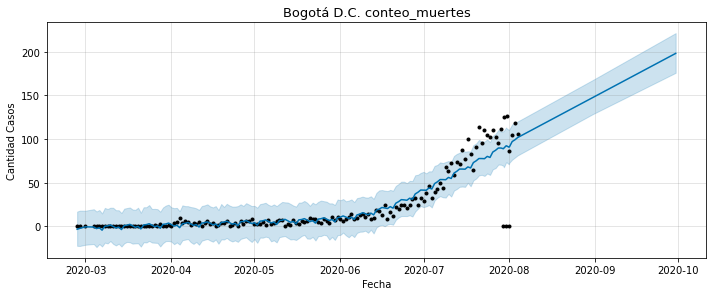

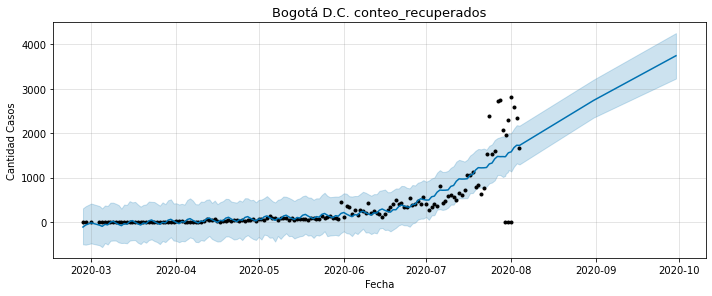

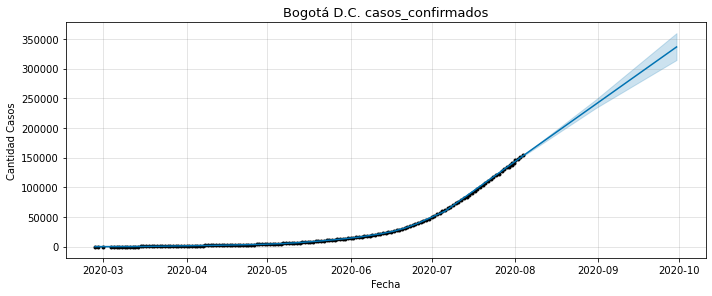

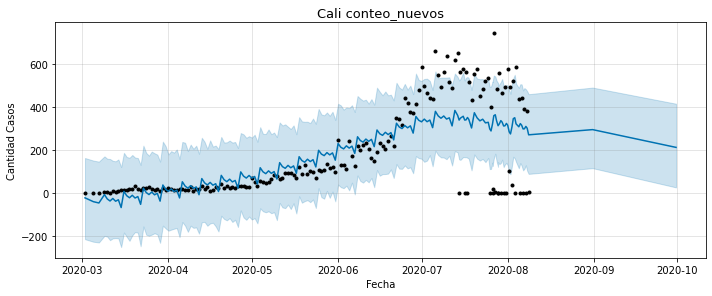

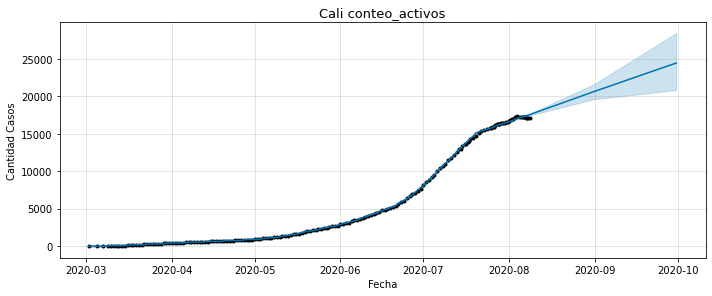

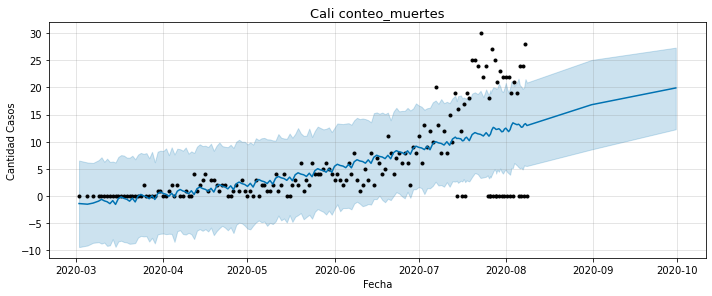

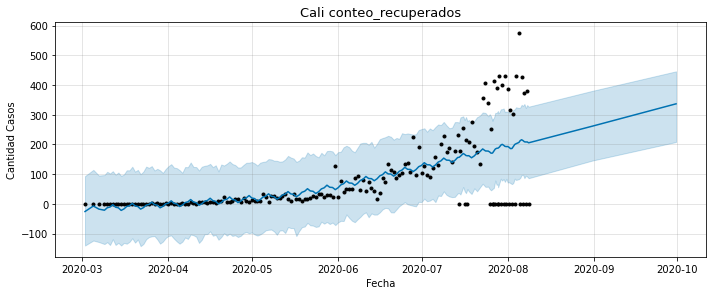

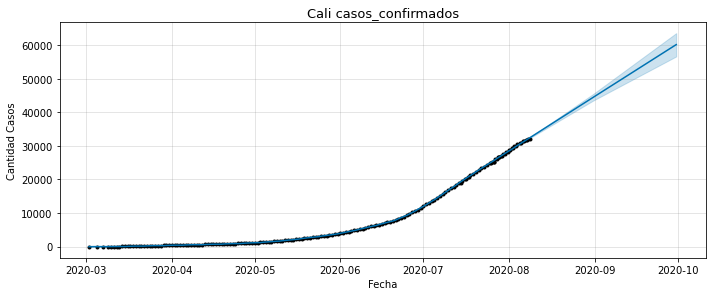

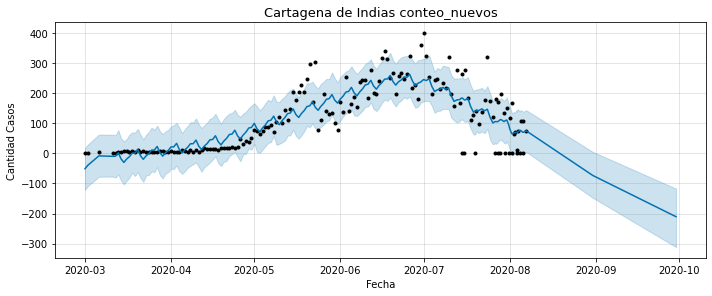

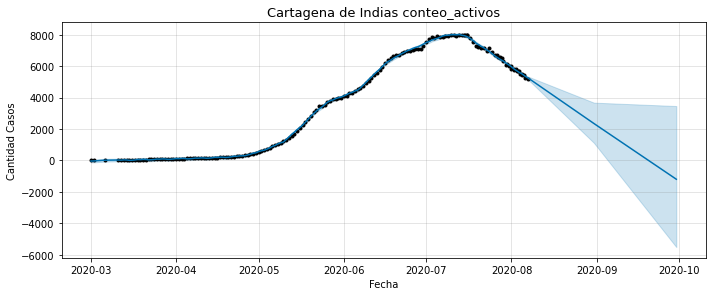

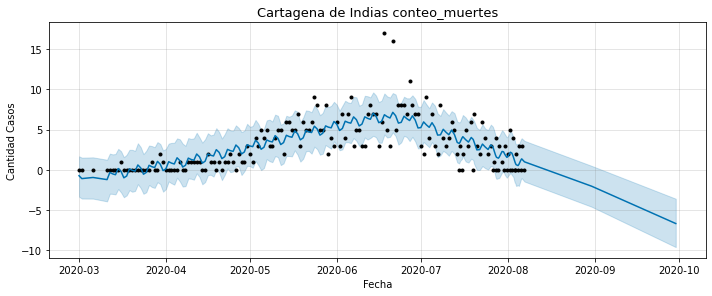

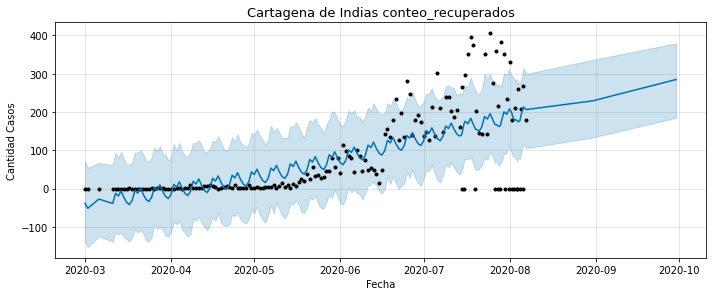

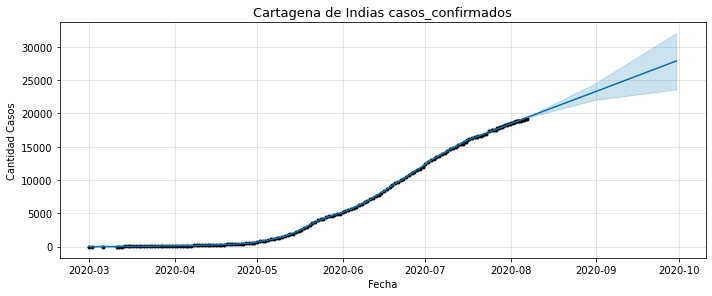

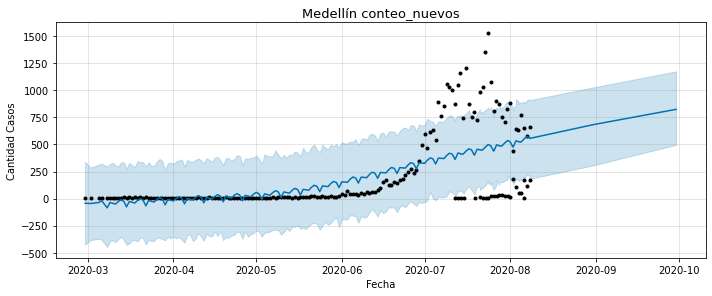

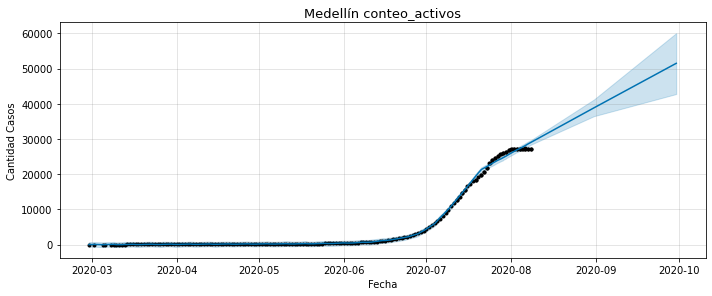

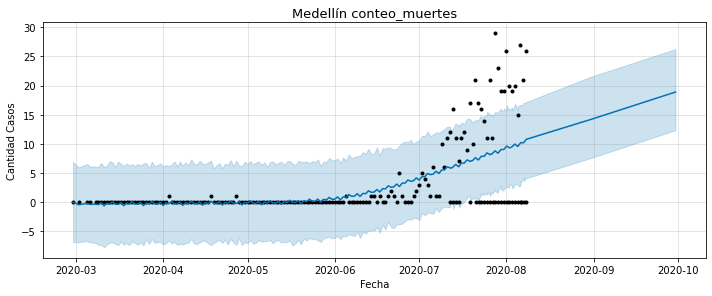

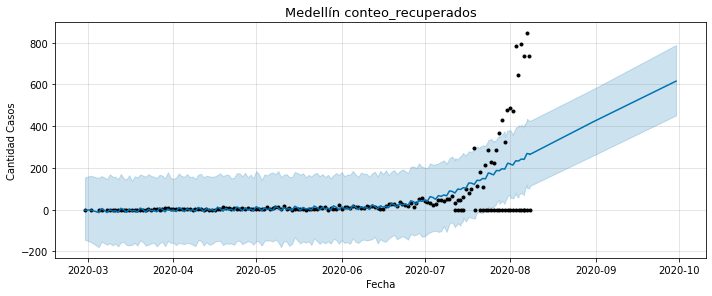

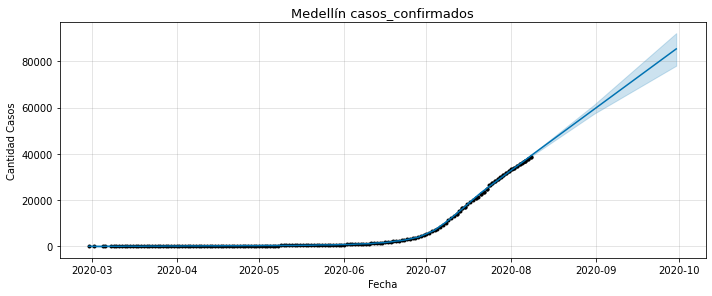

In [79]:
##predicción de cada uno de los tipos de variables objetivos como casos nuevos, 
##recuperados, activos, muertes y confirmados. Esto para cada una de las ciudades 

complete= pd.DataFrame()
variablaes_modelo = []
for i in ciudades_principales:
  for j in labels:
    filter_ciudad_conteo= pd.DataFrame()
    variablaes_modelo.clear()
    variablaes_modelo = variables.copy()
    variablaes_modelo.append(j)
    
    #se filtra la fecha para ciudad
    filter_ciudad_conteo=enc_sabana[variablaes_modelo]

    filter_ciudad_conteo = filter_ciudad_conteo[filter_ciudad_conteo['ciudad_de_ubicaci_n']==i]
    del filter_ciudad_conteo['ciudad_de_ubicaci_n']

    # Prophet se le deben de dar dos variables de entrada para el forecast, ds (fecha), y (valor a predecir)
    filter_ciudad_conteo['ds'] =filter_ciudad_conteo['fecha']
    filter_ciudad_conteo['y'] =filter_ciudad_conteo[j]

    #de acuerdo el numero de registros de cada ciudad-variable se toma el 84% de los registros
    #para entrenamiento 
    number_regist=int(filter_ciudad_conteo.shape[0]*0.84)
    
    #se particiona los datos de forma ordenada tanto para el entrenamiento como testing
    train_x =filter_ciudad_conteo.iloc[:number_regist,:]
    test_y=filter_ciudad_conteo[number_regist:]

    # prophet se le especifica la flexibilidad con changepoint_prior_scale, al aumentarlo la predicción tenderá a ajustarse
    # a los datos trantanto de no llegar al overfiting. Por defecto es 0.05
    # con daily_seasonality se le indica si hay o no estacionalidad diaria 
    prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)
    
    #entrena el modelo con los datos de entrenamiento
    prophet.fit(train_x)

    #se indica que realice un dataframe futuro para dos meses
    #por defecto incluye fechas del pasado
    build_forecast = prophet.make_future_dataframe(periods=2, freq='M')
    forecast = prophet.predict(build_forecast)
    
    # se personaliza el nombre de cada gráfica
    forecast['Municipio']=i
    forecast['modalidad']=j
    if i == 0:
      titulo="Barranquilla "+str(j)
    elif i == 1:
      titulo="Bogotá D.C. "+str(j)
    elif i == 2:
      titulo="Cali "+str(j)
    elif i == 3:
      titulo="Cartagena de Indias "+str(j)
    else:
      titulo="Medellín "+str(j)

    #grafica el resultado del forecast
    prophet.plot(forecast, xlabel='Fecha', ylabel='Cantidad Casos',figsize=(10,4))
    
    plt.title(titulo, fontsize=13)
    complete = complete.append(forecast) #append de los resultados de cada forecast

    #Por cada variable de cada ciudad se almacena el resultado gráfico del forecast
    if i == 0:
      plt.savefig('Barranquila_Prophet_' + j +   '.png', bbox_inches = 'tight')
    elif i == 1:
      plt.savefig('Bogota_Prophet_' + j +   '.png',bbox_inches = 'tight')
    elif i == 2:
      plt.savefig('Cali_Prophet_' + j +   '.png',bbox_inches = 'tight')
    elif i == 3:
      plt.savefig('Cartagena_Prophet_' + j +   '.png',bbox_inches = 'tight')
    else:
      plt.savefig('Medellin_Prophet_' + j +   '.png', bbox_inches = 'tight')

In [80]:
complete[(complete['Municipio']==0) & (complete['modalidad']=='conteo_nuevos')].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Municipio,modalidad
0,2020-03-06,-24.312713,-134.537864,102.158163,-24.312713,-24.312713,6.046366,6.046366,6.046366,6.046366,6.046366,6.046366,0.0,0.0,0.0,-18.266347,0,conteo_nuevos
1,2020-03-09,-20.627484,-149.733736,68.085475,-20.627484,-20.627484,-18.589527,-18.589527,-18.589527,-18.589527,-18.589527,-18.589527,0.0,0.0,0.0,-39.217012,0,conteo_nuevos
2,2020-03-10,-19.399075,-115.982821,111.310300,-19.399075,-19.399075,13.768079,13.768079,13.768079,13.768079,13.768079,13.768079,0.0,0.0,0.0,-5.630996,0,conteo_nuevos
3,2020-03-12,-16.942255,-114.905117,124.736054,-16.942255,-16.942255,20.485371,20.485371,20.485371,20.485371,20.485371,20.485371,0.0,0.0,0.0,3.543116,0,conteo_nuevos
4,2020-03-13,-15.713846,-123.231771,112.264718,-15.713846,-15.713846,6.046366,6.046366,6.046366,6.046366,6.046366,6.046366,0.0,0.0,0.0,-9.667479,0,conteo_nuevos


El dataframe del forecast que arroja Prophet arroja varias columnas, pero las de interés son:


*   **ds:** fecha predicción
*   **yhat:** valor pronosticado
*   **yhat_upper:** límite superior
*   **yhat_lower:** límite inferior
*   **trend:** tendencia predicción





##Conclusiones


1. Los datos que se extraen del reporte diario de casos COVID-19 para Colombia, poseen retrasos, por lo cual a la fecha de extracción es posible estar visualizando casos reportados de hace hasta un mes atrás.

2. El modelo SIR sirve para conocer los casos activos de personas que se presentarán bajo la presencia de un virus, pero tiene como inconveniente que no se puede adaptarse a las tendencias que se presentan en la vida real.

3. El modelo de analítica que se aplico prophet, fue entrenado en base a los datos que se proporcionaron de las fuentes de informacion públicas, esta metodología se aplica de acuerdo a un análisis del estado del arte en cuanto a predicciones  de series de tiempo, para lo cual se identifica que es robusto a outliers, tiene en cuenta tendencias, fechas especiales dentro de calendario, lo cual para este tipo de problemas se obtiene una muy buena solución.

4. Dado que la cantidad de datos es poca, la tendencia de la predicción suele llegar a ser negativa en algunos casos como la predicción de casos nuevos. 

Descarga las imagenes que se insertarán en la pagina web.


  adding: Barranquila_Prophet_casos_confirmados.png (deflated 6%)
  adding: Barranquila_Prophet_conteo_activos.png (deflated 5%)
  adding: Barranquila_Prophet_conteo_muertes.png (deflated 3%)
  adding: Barranquila_Prophet_conteo_nuevos.png (deflated 3%)
  adding: Barranquila_Prophet_conteo_recuperados.png (deflated 3%)
  adding: Barranquilla_SIR_Activos.png (deflated 6%)
  adding: Bogota_Prophet_casos_confirmados.png (deflated 7%)
  adding: Bogota_Prophet_conteo_activos.png (deflated 5%)
  adding: Bogota_Prophet_conteo_muertes.png (deflated 3%)
  adding: Bogota_Prophet_conteo_nuevos.png (deflated 3%)
  adding: Bogota_Prophet_conteo_recuperados.png (deflated 4%)
  adding: Bogota_SIR_Activos.png (deflated 6%)
  adding: Cali_Prophet_casos_confirmados.png (deflated 6%)
  adding: Cali_Prophet_conteo_activos.png (deflated 6%)
  adding: Cali_Prophet_conteo_muertes.png (deflated 3%)
  adding: Cali_Prophet_conteo_nuevos.png (deflated 2%)
  adding: Cali_Prophet_conteo_recuperados.png (deflated 4

##Creación de HTML, CSS Y JS para pagina web

Se crea en index de la pagina, el cual contiene la estructura de esta

In [106]:
%%writefile index.html
<!DOCTYPE html>
<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js"> <!--<![endif]-->
    <head>
        <meta charset="utf-8">
        <title>COVID19 Principales ciudades Colombia</title>
    	<meta name="description" content="">
        <meta name="viewport" content="width=device-width, initial-scale=1">
<!-- 
Power Template 
http://www.templatemo.com/tm-508-power
-->
        <link href='http://fonts.googleapis.com/css?family=Open+Sans:400,300,600,700,800' rel='stylesheet' type='text/css'>
        
        <link rel="stylesheet" href="css/bootstrap.min.css">
        <link rel="stylesheet" href="css/font-awesome.css">
        <link rel="stylesheet" href="css/animate.css">
        <link rel="stylesheet" href="css/templatemo_misc.css">
        <link rel="stylesheet" href="css/templatemo_style.css">
        <link rel="stylesheet" href="css/owl-carousel.css">

        <script src="js/vendor/modernizr-2.6.1-respond-1.1.0.min.js"></script>
    </head>
    <body>
        <!--[if lt IE 7]>
            <p class="chromeframe">You are using an outdated browser. <a href="http://browsehappy.com/">Upgrade your browser today</a> or <a href="http://www.google.com/chromeframe/?redirect=true">install Google Chrome Frame</a> to better experience this site.</p>
        <![endif]-->


        <div class="site-main" id="sTop">
            <div class="site-header">
                <div class="main-header">
                    <div class="container">
                        <div id="menu-wrapper">
                            <div class="row">
                                <nav class="navbar navbar-inverse" role="navigation">
                                    <div class="navbar-header">
                                        <button type="button" id="nav-toggle" class="navbar-toggle" data-toggle="collapse" data-target="#main-nav">
                                            <span class="sr-only">Toggle navigation</span>
                                            <span class="icon-bar"></span>
                                            <span class="icon-bar"></span>
                                            <span class="icon-bar"></span>
                                        </button>
                                        <a href="#top" class="navbar-brand">SECCIONES</a>
                                        <div id="main-nav" class="collapse navbar-collapse">
                                            <ul class="menu-first nav navbar-nav" style="margin-right: 20px;">
                                                <li><a href="#about">Descriptivos Generales</a></li>
                                                <li><a href="#ciudades">Principales Ciudades</a></li>
                                                <li><a href="#sir">Modelo SIR</a></li>
                                                <li><a href="#portfolio">Modelo Analítico</a></li>
                                         <!--       <li><a href="#" class="external" target="_parent" rel="nofollow">External</a></li>  
                                                <li><a href="#contact-us">Contactos</a></li>                                 -->
                                            </ul>                                    
                                        </div> <!-- /.main-menu -->
                                    </div>
                                </nav>
                            </div> <!-- /.row -->
                        </div> <!-- /#menu-wrapper -->                        
                    </div> <!-- /.container -->
                </div> <!-- /.main-header -->
            </div> <!-- /.site-header -->
        </div> <!-- /.site-main -->


        <div class="banner">
            <div class="container">
                <div class="row">
                    <div class="col-md-8 col-md-offset-2">
                        <div class="banner-content">
                            <h6>Pronostico de la evolución</h6>
                            <h2>de SARS-CoV-2 en Colombia</h2>
                        </div>
                    </div>
                </div>
            </div>
        </div>

        <div id="about" class="second-tabs-content what-we-do">
            <div class="container">
                <div class="row">
                    <div class="col-md-12">
                        <div class="section-heading">
                            <h4>Decriptivos Generales</h4>
                            <p>La data analizada fué tomada de la URL https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data.
                            </p>
                            <br>
                        <p>
                            Para iniciar con el estudio y analisis predictivo primero realizamos un análisis descriptivo para tener una visión general de la situación actual del pais frente al reporte diario de casos confirmados, las muertes reportadas y la cantidad de recuperados por rangos de edades y la cantidad de contagios por cada departamento.
                        </p>
                        </div>
                    </div>
                </div>
                <div class="row">
                    <div class="wrapper">
                        <div class="col-md-12">
                            <div class="row">
                                <ul class="tabs clearfix" data-tabgroup="second-tab-group">
                                    <li> <!-- class="col-md-15 col-sm-12 col-xs-12"> -->
                                        <div>

                                            <img src="img/cantidad_fecha_reporte.png" alt="" style="margin-left: 150px">
                                            <img src="img/cantidad_recuperados_edades.png" alt="">
                                            <img src="img/cantidad_muertes_edades.png" alt="" style="margin-left: 150px">
                                            <img src="img/cantidad_departamento.png" alt="">

                                        </div>
                                    </li>
                                    
                                </ul>
                            </div>
                        </div>
                        
                    </div>
                </div>
            </div>
        </div>

        <div id="ciudades" class="second-tabs-content what-we-do">
            <div class="container">
                <div class="row">
                    <div class="col-md-12">
                        <div class="section-heading">
                            <h4>Principales Ciudades</h4>
                            <p> El analisis se realizó con la información de las 5 ciudades principales de Colombia: Medellin, Bogotá D.C., Cartagena de Indias, Barranquilla y Cali.
                            En las siguientes graficas podremos observar la evolución del virus por cada una de estas ciudades, realizando un comparativo por activos, muertes, recuperados y nuevos casos reportados. Además de unos gráficos que marcan las fechas inicio del virus en cada ciudad.
                            </p>
                        </div>
                    </div>
                </div>
                <div class="row">
                    <div class="wrapper">
                        <div class="col-md-12">
                            <div class="row">
                                <ul class="tabs clearfix" data-tabgroup="second-tab-group">
                                    <li> <!-- class="col-md-15 col-sm-12 col-xs-12"> -->
                                        <div>
                                            <img src="img/ciudades_evolucion_virus.png" alt="">
                                            <img src="img/ciudades_evolucion_virus_cartagena.png" alt="" style="margin-left: 10px">
                                            <img src="img/ciudades_infecciones_primer_dia.png" alt="">
                                        </div>
                                    </li>
                                    
                                </ul>
                            </div>
                        </div>
                        
                    </div>
                </div>
            </div>
        </div>

        <div id="sir" class="second-tabs-content what-we-do">
            <div class="container">
                <div class="row">
                    <div class="col-md-12">
                        <div class="section-heading">
                            <h4>Modelo SIR</h4>
                            <p>
                                El modelo SIR es el modelo epidemiológico más usado para predicción de pandemias, en donde cada individuo de una población puede pertenecer a un grupo: susceptibles, infectados o recuperados. Para este caso se utilizaron las tasas promedio de los contagios, muertes y recuperados reportados hasta el dia de hoy en Colombia y partiendo del total de la población de cada una de las ciudades.
                            </p>
                        </div>
                    </div>
                </div>
                <div class="row">
                    <div class="wrapper">
                        <div class="col-md-12">
                            <div class="row">
                                <ul class="tabs clearfix" data-tabgroup="second-tab-group">
                                    <li> <!-- class="col-md-15 col-sm-12 col-xs-12"> -->
                                        <div>
                                            <img src="img/Bogota_SIR_Activos.png" alt="" style="margin-left: 200px">
                                            <img src="img/Barranquilla_SIR_Activos.png" alt="" style="margin-left: 200px">
                                            <img src="img/Cali_SIR_Activos.png" alt="" style="margin-left: 200px">
                                            <img src="img/Cartagena_SIR_Activos.png" alt="" style="margin-left: 200px">
                                            <img src="img/Medellin_SIR_Activos.png" alt="" style="margin-left: 200px">
                                        </div>
                                    </li>
                                    
                                </ul>
                            </div>
                        </div>
                        
                    </div>
                </div>
            </div>
        </div>


        <section id="portfolio" class="portfolio-section" style="height: 250px">
            <div class="container">
                <div class="row">
                   <!-- <div class="col-md-12"> -->
                        <div class="section-heading">
                            <h4>Modelo Prophet</h4>
                            <p>
                                Este modelo fué desarrollado por facebook y se encuentra disponible para Python y R, es una librería que permite construir modelos de ajuste y pronósticos de series. Es útil para conjunto de datos con las siguientes características:  datos con tendencias de crecimiento no lineal que se aproximen a un límite, que les falten puntos de datos o tengan casos atípicos grandes, que incluyan eventos anteriormente conocidos importantes, pero irregulares, entre otros.
                            </p>
                     <!--   </div> -->
                    </div>
                </div>
            </div>
        </section>

         <section id="portfolio" class="portfolio-section">
            <div class="container">
                <div class="row">
                    <div class="col-md-12">
                        <div class="section-heading">
                            <h4>Barranquilla</h4>
                        </div>
                    </div>
                </div>
                <div> <!-- class="row"> -->
                    <div> <!--id="owl-portfolio" class="owl-carousel owl-theme imageGallery1"> -->
                        <div class="item">
                            <div class="portfolio-item">
                                <img src="img/Barranquila_Prophet_conteo_nuevos.png" alt="" style="width: 550px" />
                                <img src="img/Barranquila_Prophet_conteo_activos.png" alt="" style="width: 550px" />
                                <img src="img/Barranquila_Prophet_conteo_muertes.png" alt="" style="width: 550px;margin-top: 10px" />
                                <img src="img/Barranquila_Prophet_conteo_recuperados.png" alt="" style="width: 550px;margin-top: 10px"/>
                                <img src="img/Barranquila_Prophet_casos_confirmados.png" alt="" style="width: 550px;margin-top: 10px"/>
                            </div>
                        </div>
                    </div>
                </div>

                <div class="row">
                    <div class="col-md-12">
                        <div class="section-heading">
                            <h4>Bogotá D.C.</h4>
                        </div>
                    </div>
                </div>
                <div> <!-- class="row"> -->
                    <div> <!--id="owl-portfolio" class="owl-carousel owl-theme imageGallery1"> -->
                        <div class="item">
                            <div class="portfolio-item">
                                <img src="img/Bogota_Prophet_conteo_nuevos.png" alt="" style="width: 550px" />
                                <img src="img/Bogota_Prophet_conteo_activos.png" alt="" style="width: 550px" />
                                <img src="img/Bogota_Prophet_conteo_muertes.png" alt="" style="width: 550px;margin-top: 10px" />
                                <img src="img/Bogota_Prophet_conteo_recuperados.png" alt="" style="width: 550px;margin-top: 10px"/>
                                <img src="img/Bogota_Prophet_casos_confirmados.png" alt="" style="width: 550px;margin-top: 10px"/>
                            </div>
                        </div>
                    </div>
                </div>

                <div class="row">
                    <div class="col-md-12">
                        <div class="section-heading">
                            <h4>Cali</h4>
                        </div>
                    </div>
                </div>
                <div> <!-- class="row"> -->
                    <div> <!--id="owl-portfolio" class="owl-carousel owl-theme imageGallery1"> -->
                        <div class="item">
                            <div class="portfolio-item">
                                <img src="img/Cali_Prophet_conteo_nuevos.png" alt="" style="width: 550px" />
                                <img src="img/Cali_Prophet_conteo_activos.png" alt="" style="width: 550px" />
                                <img src="img/Cali_Prophet_conteo_muertes.png" alt="" style="width: 550px;margin-top: 10px" />
                                <img src="img/Cali_Prophet_conteo_recuperados.png" alt="" style="width: 550px;margin-top: 10px"/>
                                <img src="img/Cali_Prophet_casos_confirmados.png" alt="" style="width: 550px;margin-top: 10px"/>
                            </div>
                        </div>
                    </div>
                </div>

                <div class="row">
                    <div class="col-md-12">
                        <div class="section-heading">
                            <h4>Cartagena</h4>
                        </div>
                    </div>
                </div>
                <div> <!-- class="row"> -->
                    <div> <!--id="owl-portfolio" class="owl-carousel owl-theme imageGallery1"> -->
                        <div class="item">
                            <div class="portfolio-item">
                                <img src="img/Cartagena_Prophet_conteo_nuevos.png" alt="" style="width: 550px" />
                                <img src="img/Cartagena_Prophet_conteo_activos.png" alt="" style="width: 550px" />
                                <img src="img/Cartagena_Prophet_conteo_muertes.png" alt="" style="width: 550px;margin-top: 10px" />
                                <img src="img/Cartagena_Prophet_conteo_recuperados.png" alt="" style="width: 550px;margin-top: 10px"/>
                                <img src="img/Cartagena_Prophet_casos_confirmados.png" alt="" style="width: 550px;margin-top: 10px"/>
                            </div>
                        </div>
                    </div>
                </div>

                <div class="row">
                    <div class="col-md-12">
                        <div class="section-heading">
                            <h4>Medellin</h4>
                        </div>
                    </div>
                </div>
                <div> <!-- class="row"> -->
                    <div> <!--id="owl-portfolio" class="owl-carousel owl-theme imageGallery1"> -->
                        <div class="item">
                            <div class="portfolio-item">
                                <img src="img/Medellin_Prophet_conteo_nuevos.png" alt="" style="width: 550px" />
                                <img src="img/Medellin_Prophet_conteo_activos.png" alt="" style="width: 550px" />
                                <img src="img/Medellin_Prophet_conteo_muertes.png" alt="" style="width: 550px;margin-top: 10px" />
                                <img src="img/Medellin_Prophet_conteo_recuperados.png" alt="" style="width: 550px;margin-top: 10px"/>
                                <img src="img/Medellin_Prophet_casos_confirmados.png" alt="" style="width: 550px;margin-top: 10px"/>
                            </div>
                        </div>
                    </div>
                </div>


            </div>
        </section>

        <section>
            <div class="container">
                <div class="row">
                    <div class="col-md-12">
                        <div class="section-heading">
                            <h4></h4>
                        </div>
                    </div>
                </div>
            </div>
        </section>



        <footer>
            <div class="container">
                <div class="row">
                    <div class="col-md-4 col-sm-12">
                            <p>Analítica Predictiva <br> 
                            Universidad Nacional de Colombia</p>
                    </div>
                    <div class="col-md-4 col-sm-12">
                        <ul class="social-icons">
                            <li><a href="#">Margarita Celada</a></li>
                            <li><a href="#">Melissa Ciro</a></li>
                            <li><a href="#">Alejandro Bedoya</a></li>
                            <li><a href="#">Diana Acosta</a></li>
                        </ul>
                    </div>
                    <div class="col-md-2 col-md-offset-2 col-sm-12">
                        <div class="back-to-top">
                            <a href="#top">
                                <i class="fa fa-angle-up"></i>
                                back to top
                            </a>
                        </div>
                    </div>
                </div>
            </div>
        </footer>
        
        <!-- templatemo 406 flex -->
    </body>
</html>

Overwriting index.html


Se crea carpeta para almacenar los archivos de estilo de la pagina

In [93]:
%%sh 
mkdir css

In [94]:
%%writefile css/animate.css
@charset "UTF-8";

/*!
Animate.css - http://daneden.me/animate
Licensed under the MIT license

Copyright (c) 2013 Daniel Eden

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
*/

.animated {
  -webkit-animation-duration: 1s;
  animation-duration: 1s;
  -webkit-animation-fill-mode: both;
  animation-fill-mode: both;
}

.animated.infinite {
  -webkit-animation-iteration-count: infinite;
  animation-iteration-count: infinite;
}

.animated.hinge {
  -webkit-animation-duration: 2s;
  animation-duration: 2s;
}

@-webkit-keyframes bounce {
  0%, 20%, 50%, 80%, 100% {
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }

  40% {
    -webkit-transform: translateY(-30px);
    transform: translateY(-30px);
  }

  60% {
    -webkit-transform: translateY(-15px);
    transform: translateY(-15px);
  }
}

@keyframes bounce {
  0%, 20%, 50%, 80%, 100% {
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }

  40% {
    -webkit-transform: translateY(-30px);
    -ms-transform: translateY(-30px);
    transform: translateY(-30px);
  }

  60% {
    -webkit-transform: translateY(-15px);
    -ms-transform: translateY(-15px);
    transform: translateY(-15px);
  }
}

.bounce {
  -webkit-animation-name: bounce;
  animation-name: bounce;
}

@-webkit-keyframes flash {
  0%, 50%, 100% {
    opacity: 1;
  }

  25%, 75% {
    opacity: 0;
  }
}

@keyframes flash {
  0%, 50%, 100% {
    opacity: 1;
  }

  25%, 75% {
    opacity: 0;
  }
}

.flash {
  -webkit-animation-name: flash;
  animation-name: flash;
}

/* originally authored by Nick Pettit - https://github.com/nickpettit/glide */

@-webkit-keyframes pulse {
  0% {
    -webkit-transform: scale(1);
    transform: scale(1);
  }

  50% {
    -webkit-transform: scale(1.1);
    transform: scale(1.1);
  }

  100% {
    -webkit-transform: scale(1);
    transform: scale(1);
  }
}

@keyframes pulse {
  0% {
    -webkit-transform: scale(1);
    -ms-transform: scale(1);
    transform: scale(1);
  }

  50% {
    -webkit-transform: scale(1.1);
    -ms-transform: scale(1.1);
    transform: scale(1.1);
  }

  100% {
    -webkit-transform: scale(1);
    -ms-transform: scale(1);
    transform: scale(1);
  }
}

.pulse {
  -webkit-animation-name: pulse;
  animation-name: pulse;
}

@-webkit-keyframes rubberBand {
  0% {
    -webkit-transform: scale(1);
    transform: scale(1);
  }

  30% {
    -webkit-transform: scaleX(1.25) scaleY(0.75);
    transform: scaleX(1.25) scaleY(0.75);
  }

  40% {
    -webkit-transform: scaleX(0.75) scaleY(1.25);
    transform: scaleX(0.75) scaleY(1.25);
  }

  60% {
    -webkit-transform: scaleX(1.15) scaleY(0.85);
    transform: scaleX(1.15) scaleY(0.85);
  }

  100% {
    -webkit-transform: scale(1);
    transform: scale(1);
  }
}

@keyframes rubberBand {
  0% {
    -webkit-transform: scale(1);
    -ms-transform: scale(1);
    transform: scale(1);
  }

  30% {
    -webkit-transform: scaleX(1.25) scaleY(0.75);
    -ms-transform: scaleX(1.25) scaleY(0.75);
    transform: scaleX(1.25) scaleY(0.75);
  }

  40% {
    -webkit-transform: scaleX(0.75) scaleY(1.25);
    -ms-transform: scaleX(0.75) scaleY(1.25);
    transform: scaleX(0.75) scaleY(1.25);
  }

  60% {
    -webkit-transform: scaleX(1.15) scaleY(0.85);
    -ms-transform: scaleX(1.15) scaleY(0.85);
    transform: scaleX(1.15) scaleY(0.85);
  }

  100% {
    -webkit-transform: scale(1);
    -ms-transform: scale(1);
    transform: scale(1);
  }
}

.rubberBand {
  -webkit-animation-name: rubberBand;
  animation-name: rubberBand;
}

@-webkit-keyframes shake {
  0%, 100% {
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }

  10%, 30%, 50%, 70%, 90% {
    -webkit-transform: translateX(-10px);
    transform: translateX(-10px);
  }

  20%, 40%, 60%, 80% {
    -webkit-transform: translateX(10px);
    transform: translateX(10px);
  }
}

@keyframes shake {
  0%, 100% {
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }

  10%, 30%, 50%, 70%, 90% {
    -webkit-transform: translateX(-10px);
    -ms-transform: translateX(-10px);
    transform: translateX(-10px);
  }

  20%, 40%, 60%, 80% {
    -webkit-transform: translateX(10px);
    -ms-transform: translateX(10px);
    transform: translateX(10px);
  }
}

.shake {
  -webkit-animation-name: shake;
  animation-name: shake;
}

@-webkit-keyframes swing {
  20% {
    -webkit-transform: rotate(15deg);
    transform: rotate(15deg);
  }

  40% {
    -webkit-transform: rotate(-10deg);
    transform: rotate(-10deg);
  }

  60% {
    -webkit-transform: rotate(5deg);
    transform: rotate(5deg);
  }

  80% {
    -webkit-transform: rotate(-5deg);
    transform: rotate(-5deg);
  }

  100% {
    -webkit-transform: rotate(0deg);
    transform: rotate(0deg);
  }
}

@keyframes swing {
  20% {
    -webkit-transform: rotate(15deg);
    -ms-transform: rotate(15deg);
    transform: rotate(15deg);
  }

  40% {
    -webkit-transform: rotate(-10deg);
    -ms-transform: rotate(-10deg);
    transform: rotate(-10deg);
  }

  60% {
    -webkit-transform: rotate(5deg);
    -ms-transform: rotate(5deg);
    transform: rotate(5deg);
  }

  80% {
    -webkit-transform: rotate(-5deg);
    -ms-transform: rotate(-5deg);
    transform: rotate(-5deg);
  }

  100% {
    -webkit-transform: rotate(0deg);
    -ms-transform: rotate(0deg);
    transform: rotate(0deg);
  }
}

.swing {
  -webkit-transform-origin: top center;
  -ms-transform-origin: top center;
  transform-origin: top center;
  -webkit-animation-name: swing;
  animation-name: swing;
}

@-webkit-keyframes tada {
  0% {
    -webkit-transform: scale(1);
    transform: scale(1);
  }

  10%, 20% {
    -webkit-transform: scale(0.9) rotate(-3deg);
    transform: scale(0.9) rotate(-3deg);
  }

  30%, 50%, 70%, 90% {
    -webkit-transform: scale(1.1) rotate(3deg);
    transform: scale(1.1) rotate(3deg);
  }

  40%, 60%, 80% {
    -webkit-transform: scale(1.1) rotate(-3deg);
    transform: scale(1.1) rotate(-3deg);
  }

  100% {
    -webkit-transform: scale(1) rotate(0);
    transform: scale(1) rotate(0);
  }
}

@keyframes tada {
  0% {
    -webkit-transform: scale(1);
    -ms-transform: scale(1);
    transform: scale(1);
  }

  10%, 20% {
    -webkit-transform: scale(0.9) rotate(-3deg);
    -ms-transform: scale(0.9) rotate(-3deg);
    transform: scale(0.9) rotate(-3deg);
  }

  30%, 50%, 70%, 90% {
    -webkit-transform: scale(1.1) rotate(3deg);
    -ms-transform: scale(1.1) rotate(3deg);
    transform: scale(1.1) rotate(3deg);
  }

  40%, 60%, 80% {
    -webkit-transform: scale(1.1) rotate(-3deg);
    -ms-transform: scale(1.1) rotate(-3deg);
    transform: scale(1.1) rotate(-3deg);
  }

  100% {
    -webkit-transform: scale(1) rotate(0);
    -ms-transform: scale(1) rotate(0);
    transform: scale(1) rotate(0);
  }
}

.tada {
  -webkit-animation-name: tada;
  animation-name: tada;
}

/* originally authored by Nick Pettit - https://github.com/nickpettit/glide */

@-webkit-keyframes wobble {
  0% {
    -webkit-transform: translateX(0%);
    transform: translateX(0%);
  }

  15% {
    -webkit-transform: translateX(-25%) rotate(-5deg);
    transform: translateX(-25%) rotate(-5deg);
  }

  30% {
    -webkit-transform: translateX(20%) rotate(3deg);
    transform: translateX(20%) rotate(3deg);
  }

  45% {
    -webkit-transform: translateX(-15%) rotate(-3deg);
    transform: translateX(-15%) rotate(-3deg);
  }

  60% {
    -webkit-transform: translateX(10%) rotate(2deg);
    transform: translateX(10%) rotate(2deg);
  }

  75% {
    -webkit-transform: translateX(-5%) rotate(-1deg);
    transform: translateX(-5%) rotate(-1deg);
  }

  100% {
    -webkit-transform: translateX(0%);
    transform: translateX(0%);
  }
}

@keyframes wobble {
  0% {
    -webkit-transform: translateX(0%);
    -ms-transform: translateX(0%);
    transform: translateX(0%);
  }

  15% {
    -webkit-transform: translateX(-25%) rotate(-5deg);
    -ms-transform: translateX(-25%) rotate(-5deg);
    transform: translateX(-25%) rotate(-5deg);
  }

  30% {
    -webkit-transform: translateX(20%) rotate(3deg);
    -ms-transform: translateX(20%) rotate(3deg);
    transform: translateX(20%) rotate(3deg);
  }

  45% {
    -webkit-transform: translateX(-15%) rotate(-3deg);
    -ms-transform: translateX(-15%) rotate(-3deg);
    transform: translateX(-15%) rotate(-3deg);
  }

  60% {
    -webkit-transform: translateX(10%) rotate(2deg);
    -ms-transform: translateX(10%) rotate(2deg);
    transform: translateX(10%) rotate(2deg);
  }

  75% {
    -webkit-transform: translateX(-5%) rotate(-1deg);
    -ms-transform: translateX(-5%) rotate(-1deg);
    transform: translateX(-5%) rotate(-1deg);
  }

  100% {
    -webkit-transform: translateX(0%);
    -ms-transform: translateX(0%);
    transform: translateX(0%);
  }
}

.wobble {
  -webkit-animation-name: wobble;
  animation-name: wobble;
}

@-webkit-keyframes bounceIn {
  0% {
    opacity: 0;
    -webkit-transform: scale(.3);
    transform: scale(.3);
  }

  50% {
    opacity: 1;
    -webkit-transform: scale(1.05);
    transform: scale(1.05);
  }

  70% {
    -webkit-transform: scale(.9);
    transform: scale(.9);
  }

  100% {
    opacity: 1;
    -webkit-transform: scale(1);
    transform: scale(1);
  }
}

@keyframes bounceIn {
  0% {
    opacity: 0;
    -webkit-transform: scale(.3);
    -ms-transform: scale(.3);
    transform: scale(.3);
  }

  50% {
    opacity: 1;
    -webkit-transform: scale(1.05);
    -ms-transform: scale(1.05);
    transform: scale(1.05);
  }

  70% {
    -webkit-transform: scale(.9);
    -ms-transform: scale(.9);
    transform: scale(.9);
  }

  100% {
    opacity: 1;
    -webkit-transform: scale(1);
    -ms-transform: scale(1);
    transform: scale(1);
  }
}

.bounceIn {
  -webkit-animation-name: bounceIn;
  animation-name: bounceIn;
}

@-webkit-keyframes bounceInDown {
  0% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }

  60% {
    opacity: 1;
    -webkit-transform: translateY(30px);
    transform: translateY(30px);
  }

  80% {
    -webkit-transform: translateY(-10px);
    transform: translateY(-10px);
  }

  100% {
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }
}

@keyframes bounceInDown {
  0% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    -ms-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }

  60% {
    opacity: 1;
    -webkit-transform: translateY(30px);
    -ms-transform: translateY(30px);
    transform: translateY(30px);
  }

  80% {
    -webkit-transform: translateY(-10px);
    -ms-transform: translateY(-10px);
    transform: translateY(-10px);
  }

  100% {
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }
}

.bounceInDown {
  -webkit-animation-name: bounceInDown;
  animation-name: bounceInDown;
}

@-webkit-keyframes bounceInLeft {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }

  60% {
    opacity: 1;
    -webkit-transform: translateX(30px);
    transform: translateX(30px);
  }

  80% {
    -webkit-transform: translateX(-10px);
    transform: translateX(-10px);
  }

  100% {
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }
}

@keyframes bounceInLeft {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    -ms-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }

  60% {
    opacity: 1;
    -webkit-transform: translateX(30px);
    -ms-transform: translateX(30px);
    transform: translateX(30px);
  }

  80% {
    -webkit-transform: translateX(-10px);
    -ms-transform: translateX(-10px);
    transform: translateX(-10px);
  }

  100% {
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }
}

.bounceInLeft {
  -webkit-animation-name: bounceInLeft;
  animation-name: bounceInLeft;
}

@-webkit-keyframes bounceInRight {
  0% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    transform: translateX(2000px);
  }

  60% {
    opacity: 1;
    -webkit-transform: translateX(-30px);
    transform: translateX(-30px);
  }

  80% {
    -webkit-transform: translateX(10px);
    transform: translateX(10px);
  }

  100% {
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }
}

@keyframes bounceInRight {
  0% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    -ms-transform: translateX(2000px);
    transform: translateX(2000px);
  }

  60% {
    opacity: 1;
    -webkit-transform: translateX(-30px);
    -ms-transform: translateX(-30px);
    transform: translateX(-30px);
  }

  80% {
    -webkit-transform: translateX(10px);
    -ms-transform: translateX(10px);
    transform: translateX(10px);
  }

  100% {
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }
}

.bounceInRight {
  -webkit-animation-name: bounceInRight;
  animation-name: bounceInRight;
}

@-webkit-keyframes bounceInUp {
  0% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    transform: translateY(2000px);
  }

  60% {
    opacity: 1;
    -webkit-transform: translateY(-30px);
    transform: translateY(-30px);
  }

  80% {
    -webkit-transform: translateY(10px);
    transform: translateY(10px);
  }

  100% {
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }
}

@keyframes bounceInUp {
  0% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    -ms-transform: translateY(2000px);
    transform: translateY(2000px);
  }

  60% {
    opacity: 1;
    -webkit-transform: translateY(-30px);
    -ms-transform: translateY(-30px);
    transform: translateY(-30px);
  }

  80% {
    -webkit-transform: translateY(10px);
    -ms-transform: translateY(10px);
    transform: translateY(10px);
  }

  100% {
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }
}

.bounceInUp {
  -webkit-animation-name: bounceInUp;
  animation-name: bounceInUp;
}

@-webkit-keyframes bounceOut {
  0% {
    -webkit-transform: scale(1);
    transform: scale(1);
  }

  25% {
    -webkit-transform: scale(.95);
    transform: scale(.95);
  }

  50% {
    opacity: 1;
    -webkit-transform: scale(1.1);
    transform: scale(1.1);
  }

  100% {
    opacity: 0;
    -webkit-transform: scale(.3);
    transform: scale(.3);
  }
}

@keyframes bounceOut {
  0% {
    -webkit-transform: scale(1);
    -ms-transform: scale(1);
    transform: scale(1);
  }

  25% {
    -webkit-transform: scale(.95);
    -ms-transform: scale(.95);
    transform: scale(.95);
  }

  50% {
    opacity: 1;
    -webkit-transform: scale(1.1);
    -ms-transform: scale(1.1);
    transform: scale(1.1);
  }

  100% {
    opacity: 0;
    -webkit-transform: scale(.3);
    -ms-transform: scale(.3);
    transform: scale(.3);
  }
}

.bounceOut {
  -webkit-animation-name: bounceOut;
  animation-name: bounceOut;
}

@-webkit-keyframes bounceOutDown {
  0% {
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }

  20% {
    opacity: 1;
    -webkit-transform: translateY(-20px);
    transform: translateY(-20px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    transform: translateY(2000px);
  }
}

@keyframes bounceOutDown {
  0% {
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }

  20% {
    opacity: 1;
    -webkit-transform: translateY(-20px);
    -ms-transform: translateY(-20px);
    transform: translateY(-20px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    -ms-transform: translateY(2000px);
    transform: translateY(2000px);
  }
}

.bounceOutDown {
  -webkit-animation-name: bounceOutDown;
  animation-name: bounceOutDown;
}

@-webkit-keyframes bounceOutLeft {
  0% {
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }

  20% {
    opacity: 1;
    -webkit-transform: translateX(20px);
    transform: translateX(20px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }
}

@keyframes bounceOutLeft {
  0% {
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }

  20% {
    opacity: 1;
    -webkit-transform: translateX(20px);
    -ms-transform: translateX(20px);
    transform: translateX(20px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    -ms-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }
}

.bounceOutLeft {
  -webkit-animation-name: bounceOutLeft;
  animation-name: bounceOutLeft;
}

@-webkit-keyframes bounceOutRight {
  0% {
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }

  20% {
    opacity: 1;
    -webkit-transform: translateX(-20px);
    transform: translateX(-20px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    transform: translateX(2000px);
  }
}

@keyframes bounceOutRight {
  0% {
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }

  20% {
    opacity: 1;
    -webkit-transform: translateX(-20px);
    -ms-transform: translateX(-20px);
    transform: translateX(-20px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    -ms-transform: translateX(2000px);
    transform: translateX(2000px);
  }
}

.bounceOutRight {
  -webkit-animation-name: bounceOutRight;
  animation-name: bounceOutRight;
}

@-webkit-keyframes bounceOutUp {
  0% {
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }

  20% {
    opacity: 1;
    -webkit-transform: translateY(20px);
    transform: translateY(20px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }
}

@keyframes bounceOutUp {
  0% {
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }

  20% {
    opacity: 1;
    -webkit-transform: translateY(20px);
    -ms-transform: translateY(20px);
    transform: translateY(20px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    -ms-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }
}

.bounceOutUp {
  -webkit-animation-name: bounceOutUp;
  animation-name: bounceOutUp;
}

@-webkit-keyframes fadeIn {
  0% {
    opacity: 0;
  }

  100% {
    opacity: 1;
  }
}

@keyframes fadeIn {
  0% {
    opacity: 0;
  }

  100% {
    opacity: 1;
  }
}

.fadeIn {
  -webkit-animation-name: fadeIn;
  animation-name: fadeIn;
}

@-webkit-keyframes fadeInDown {
  0% {
    opacity: 0;
    -webkit-transform: translateY(-20px);
    transform: translateY(-20px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }
}

@keyframes fadeInDown {
  0% {
    opacity: 0;
    -webkit-transform: translateY(-20px);
    -ms-transform: translateY(-20px);
    transform: translateY(-20px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }
}

.fadeInDown {
  -webkit-animation-name: fadeInDown;
  animation-name: fadeInDown;
}

@-webkit-keyframes fadeInDownBig {
  0% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }
}

@keyframes fadeInDownBig {
  0% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    -ms-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }
}

.fadeInDownBig {
  -webkit-animation-name: fadeInDownBig;
  animation-name: fadeInDownBig;
}

@-webkit-keyframes fadeInLeft {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-20px);
    transform: translateX(-20px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }
}

@keyframes fadeInLeft {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-20px);
    -ms-transform: translateX(-20px);
    transform: translateX(-20px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }
}

.fadeInLeft {
  -webkit-animation-name: fadeInLeft;
  animation-name: fadeInLeft;
}

@-webkit-keyframes fadeInLeftBig {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }
}

@keyframes fadeInLeftBig {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    -ms-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }
}

.fadeInLeftBig {
  -webkit-animation-name: fadeInLeftBig;
  animation-name: fadeInLeftBig;
}

@-webkit-keyframes fadeInRight {
  0% {
    opacity: 0;
    -webkit-transform: translateX(20px);
    transform: translateX(20px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }
}

@keyframes fadeInRight {
  0% {
    opacity: 0;
    -webkit-transform: translateX(20px);
    -ms-transform: translateX(20px);
    transform: translateX(20px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }
}

.fadeInRight {
  -webkit-animation-name: fadeInRight;
  animation-name: fadeInRight;
}

@-webkit-keyframes fadeInRightBig {
  0% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    transform: translateX(2000px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }
}

@keyframes fadeInRightBig {
  0% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    -ms-transform: translateX(2000px);
    transform: translateX(2000px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }
}

.fadeInRightBig {
  -webkit-animation-name: fadeInRightBig;
  animation-name: fadeInRightBig;
}

@-webkit-keyframes fadeInUp {
  0% {
    opacity: 0;
    -webkit-transform: translateY(20px);
    transform: translateY(20px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }
}

@keyframes fadeInUp {
  0% {
    opacity: 0;
    -webkit-transform: translateY(20px);
    -ms-transform: translateY(20px);
    transform: translateY(20px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }
}

.fadeInUp {
  -webkit-animation-name: fadeInUp;
  animation-name: fadeInUp;
}

@-webkit-keyframes fadeInUpBig {
  0% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    transform: translateY(2000px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }
}

@keyframes fadeInUpBig {
  0% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    -ms-transform: translateY(2000px);
    transform: translateY(2000px);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }
}

.fadeInUpBig {
  -webkit-animation-name: fadeInUpBig;
  animation-name: fadeInUpBig;
}

@-webkit-keyframes fadeOut {
  0% {
    opacity: 1;
  }

  100% {
    opacity: 0;
  }
}

@keyframes fadeOut {
  0% {
    opacity: 1;
  }

  100% {
    opacity: 0;
  }
}

.fadeOut {
  -webkit-animation-name: fadeOut;
  animation-name: fadeOut;
}

@-webkit-keyframes fadeOutDown {
  0% {
    opacity: 1;
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(20px);
    transform: translateY(20px);
  }
}

@keyframes fadeOutDown {
  0% {
    opacity: 1;
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(20px);
    -ms-transform: translateY(20px);
    transform: translateY(20px);
  }
}

.fadeOutDown {
  -webkit-animation-name: fadeOutDown;
  animation-name: fadeOutDown;
}

@-webkit-keyframes fadeOutDownBig {
  0% {
    opacity: 1;
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    transform: translateY(2000px);
  }
}

@keyframes fadeOutDownBig {
  0% {
    opacity: 1;
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    -ms-transform: translateY(2000px);
    transform: translateY(2000px);
  }
}

.fadeOutDownBig {
  -webkit-animation-name: fadeOutDownBig;
  animation-name: fadeOutDownBig;
}

@-webkit-keyframes fadeOutLeft {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(-20px);
    transform: translateX(-20px);
  }
}

@keyframes fadeOutLeft {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(-20px);
    -ms-transform: translateX(-20px);
    transform: translateX(-20px);
  }
}

.fadeOutLeft {
  -webkit-animation-name: fadeOutLeft;
  animation-name: fadeOutLeft;
}

@-webkit-keyframes fadeOutLeftBig {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }
}

@keyframes fadeOutLeftBig {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    -ms-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }
}

.fadeOutLeftBig {
  -webkit-animation-name: fadeOutLeftBig;
  animation-name: fadeOutLeftBig;
}

@-webkit-keyframes fadeOutRight {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(20px);
    transform: translateX(20px);
  }
}

@keyframes fadeOutRight {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(20px);
    -ms-transform: translateX(20px);
    transform: translateX(20px);
  }
}

.fadeOutRight {
  -webkit-animation-name: fadeOutRight;
  animation-name: fadeOutRight;
}

@-webkit-keyframes fadeOutRightBig {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    transform: translateX(2000px);
  }
}

@keyframes fadeOutRightBig {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    -ms-transform: translateX(2000px);
    transform: translateX(2000px);
  }
}

.fadeOutRightBig {
  -webkit-animation-name: fadeOutRightBig;
  animation-name: fadeOutRightBig;
}

@-webkit-keyframes fadeOutUp {
  0% {
    opacity: 1;
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(-20px);
    transform: translateY(-20px);
  }
}

@keyframes fadeOutUp {
  0% {
    opacity: 1;
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(-20px);
    -ms-transform: translateY(-20px);
    transform: translateY(-20px);
  }
}

.fadeOutUp {
  -webkit-animation-name: fadeOutUp;
  animation-name: fadeOutUp;
}

@-webkit-keyframes fadeOutUpBig {
  0% {
    opacity: 1;
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }
}

@keyframes fadeOutUpBig {
  0% {
    opacity: 1;
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    -ms-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }
}

.fadeOutUpBig {
  -webkit-animation-name: fadeOutUpBig;
  animation-name: fadeOutUpBig;
}

@-webkit-keyframes flip {
  0% {
    -webkit-transform: perspective(400px) translateZ(0) rotateY(0) scale(1);
    transform: perspective(400px) translateZ(0) rotateY(0) scale(1);
    -webkit-animation-timing-function: ease-out;
    animation-timing-function: ease-out;
  }

  40% {
    -webkit-transform: perspective(400px) translateZ(150px) rotateY(170deg) scale(1);
    transform: perspective(400px) translateZ(150px) rotateY(170deg) scale(1);
    -webkit-animation-timing-function: ease-out;
    animation-timing-function: ease-out;
  }

  50% {
    -webkit-transform: perspective(400px) translateZ(150px) rotateY(190deg) scale(1);
    transform: perspective(400px) translateZ(150px) rotateY(190deg) scale(1);
    -webkit-animation-timing-function: ease-in;
    animation-timing-function: ease-in;
  }

  80% {
    -webkit-transform: perspective(400px) translateZ(0) rotateY(360deg) scale(.95);
    transform: perspective(400px) translateZ(0) rotateY(360deg) scale(.95);
    -webkit-animation-timing-function: ease-in;
    animation-timing-function: ease-in;
  }

  100% {
    -webkit-transform: perspective(400px) translateZ(0) rotateY(360deg) scale(1);
    transform: perspective(400px) translateZ(0) rotateY(360deg) scale(1);
    -webkit-animation-timing-function: ease-in;
    animation-timing-function: ease-in;
  }
}

@keyframes flip {
  0% {
    -webkit-transform: perspective(400px) translateZ(0) rotateY(0) scale(1);
    -ms-transform: perspective(400px) translateZ(0) rotateY(0) scale(1);
    transform: perspective(400px) translateZ(0) rotateY(0) scale(1);
    -webkit-animation-timing-function: ease-out;
    animation-timing-function: ease-out;
  }

  40% {
    -webkit-transform: perspective(400px) translateZ(150px) rotateY(170deg) scale(1);
    -ms-transform: perspective(400px) translateZ(150px) rotateY(170deg) scale(1);
    transform: perspective(400px) translateZ(150px) rotateY(170deg) scale(1);
    -webkit-animation-timing-function: ease-out;
    animation-timing-function: ease-out;
  }

  50% {
    -webkit-transform: perspective(400px) translateZ(150px) rotateY(190deg) scale(1);
    -ms-transform: perspective(400px) translateZ(150px) rotateY(190deg) scale(1);
    transform: perspective(400px) translateZ(150px) rotateY(190deg) scale(1);
    -webkit-animation-timing-function: ease-in;
    animation-timing-function: ease-in;
  }

  80% {
    -webkit-transform: perspective(400px) translateZ(0) rotateY(360deg) scale(.95);
    -ms-transform: perspective(400px) translateZ(0) rotateY(360deg) scale(.95);
    transform: perspective(400px) translateZ(0) rotateY(360deg) scale(.95);
    -webkit-animation-timing-function: ease-in;
    animation-timing-function: ease-in;
  }

  100% {
    -webkit-transform: perspective(400px) translateZ(0) rotateY(360deg) scale(1);
    -ms-transform: perspective(400px) translateZ(0) rotateY(360deg) scale(1);
    transform: perspective(400px) translateZ(0) rotateY(360deg) scale(1);
    -webkit-animation-timing-function: ease-in;
    animation-timing-function: ease-in;
  }
}

.animated.flip {
  -webkit-backface-visibility: visible;
  -ms-backface-visibility: visible;
  backface-visibility: visible;
  -webkit-animation-name: flip;
  animation-name: flip;
}

@-webkit-keyframes flipInX {
  0% {
    -webkit-transform: perspective(400px) rotateX(90deg);
    transform: perspective(400px) rotateX(90deg);
    opacity: 0;
  }

  40% {
    -webkit-transform: perspective(400px) rotateX(-10deg);
    transform: perspective(400px) rotateX(-10deg);
  }

  70% {
    -webkit-transform: perspective(400px) rotateX(10deg);
    transform: perspective(400px) rotateX(10deg);
  }

  100% {
    -webkit-transform: perspective(400px) rotateX(0deg);
    transform: perspective(400px) rotateX(0deg);
    opacity: 1;
  }
}

@keyframes flipInX {
  0% {
    -webkit-transform: perspective(400px) rotateX(90deg);
    -ms-transform: perspective(400px) rotateX(90deg);
    transform: perspective(400px) rotateX(90deg);
    opacity: 0;
  }

  40% {
    -webkit-transform: perspective(400px) rotateX(-10deg);
    -ms-transform: perspective(400px) rotateX(-10deg);
    transform: perspective(400px) rotateX(-10deg);
  }

  70% {
    -webkit-transform: perspective(400px) rotateX(10deg);
    -ms-transform: perspective(400px) rotateX(10deg);
    transform: perspective(400px) rotateX(10deg);
  }

  100% {
    -webkit-transform: perspective(400px) rotateX(0deg);
    -ms-transform: perspective(400px) rotateX(0deg);
    transform: perspective(400px) rotateX(0deg);
    opacity: 1;
  }
}

.flipInX {
  -webkit-backface-visibility: visible !important;
  -ms-backface-visibility: visible !important;
  backface-visibility: visible !important;
  -webkit-animation-name: flipInX;
  animation-name: flipInX;
}

@-webkit-keyframes flipInY {
  0% {
    -webkit-transform: perspective(400px) rotateY(90deg);
    transform: perspective(400px) rotateY(90deg);
    opacity: 0;
  }

  40% {
    -webkit-transform: perspective(400px) rotateY(-10deg);
    transform: perspective(400px) rotateY(-10deg);
  }

  70% {
    -webkit-transform: perspective(400px) rotateY(10deg);
    transform: perspective(400px) rotateY(10deg);
  }

  100% {
    -webkit-transform: perspective(400px) rotateY(0deg);
    transform: perspective(400px) rotateY(0deg);
    opacity: 1;
  }
}

@keyframes flipInY {
  0% {
    -webkit-transform: perspective(400px) rotateY(90deg);
    -ms-transform: perspective(400px) rotateY(90deg);
    transform: perspective(400px) rotateY(90deg);
    opacity: 0;
  }

  40% {
    -webkit-transform: perspective(400px) rotateY(-10deg);
    -ms-transform: perspective(400px) rotateY(-10deg);
    transform: perspective(400px) rotateY(-10deg);
  }

  70% {
    -webkit-transform: perspective(400px) rotateY(10deg);
    -ms-transform: perspective(400px) rotateY(10deg);
    transform: perspective(400px) rotateY(10deg);
  }

  100% {
    -webkit-transform: perspective(400px) rotateY(0deg);
    -ms-transform: perspective(400px) rotateY(0deg);
    transform: perspective(400px) rotateY(0deg);
    opacity: 1;
  }
}

.flipInY {
  -webkit-backface-visibility: visible !important;
  -ms-backface-visibility: visible !important;
  backface-visibility: visible !important;
  -webkit-animation-name: flipInY;
  animation-name: flipInY;
}

@-webkit-keyframes flipOutX {
  0% {
    -webkit-transform: perspective(400px) rotateX(0deg);
    transform: perspective(400px) rotateX(0deg);
    opacity: 1;
  }

  100% {
    -webkit-transform: perspective(400px) rotateX(90deg);
    transform: perspective(400px) rotateX(90deg);
    opacity: 0;
  }
}

@keyframes flipOutX {
  0% {
    -webkit-transform: perspective(400px) rotateX(0deg);
    -ms-transform: perspective(400px) rotateX(0deg);
    transform: perspective(400px) rotateX(0deg);
    opacity: 1;
  }

  100% {
    -webkit-transform: perspective(400px) rotateX(90deg);
    -ms-transform: perspective(400px) rotateX(90deg);
    transform: perspective(400px) rotateX(90deg);
    opacity: 0;
  }
}

.flipOutX {
  -webkit-animation-name: flipOutX;
  animation-name: flipOutX;
  -webkit-backface-visibility: visible !important;
  -ms-backface-visibility: visible !important;
  backface-visibility: visible !important;
}

@-webkit-keyframes flipOutY {
  0% {
    -webkit-transform: perspective(400px) rotateY(0deg);
    transform: perspective(400px) rotateY(0deg);
    opacity: 1;
  }

  100% {
    -webkit-transform: perspective(400px) rotateY(90deg);
    transform: perspective(400px) rotateY(90deg);
    opacity: 0;
  }
}

@keyframes flipOutY {
  0% {
    -webkit-transform: perspective(400px) rotateY(0deg);
    -ms-transform: perspective(400px) rotateY(0deg);
    transform: perspective(400px) rotateY(0deg);
    opacity: 1;
  }

  100% {
    -webkit-transform: perspective(400px) rotateY(90deg);
    -ms-transform: perspective(400px) rotateY(90deg);
    transform: perspective(400px) rotateY(90deg);
    opacity: 0;
  }
}

.flipOutY {
  -webkit-backface-visibility: visible !important;
  -ms-backface-visibility: visible !important;
  backface-visibility: visible !important;
  -webkit-animation-name: flipOutY;
  animation-name: flipOutY;
}

@-webkit-keyframes lightSpeedIn {
  0% {
    -webkit-transform: translateX(100%) skewX(-30deg);
    transform: translateX(100%) skewX(-30deg);
    opacity: 0;
  }

  60% {
    -webkit-transform: translateX(-20%) skewX(30deg);
    transform: translateX(-20%) skewX(30deg);
    opacity: 1;
  }

  80% {
    -webkit-transform: translateX(0%) skewX(-15deg);
    transform: translateX(0%) skewX(-15deg);
    opacity: 1;
  }

  100% {
    -webkit-transform: translateX(0%) skewX(0deg);
    transform: translateX(0%) skewX(0deg);
    opacity: 1;
  }
}

@keyframes lightSpeedIn {
  0% {
    -webkit-transform: translateX(100%) skewX(-30deg);
    -ms-transform: translateX(100%) skewX(-30deg);
    transform: translateX(100%) skewX(-30deg);
    opacity: 0;
  }

  60% {
    -webkit-transform: translateX(-20%) skewX(30deg);
    -ms-transform: translateX(-20%) skewX(30deg);
    transform: translateX(-20%) skewX(30deg);
    opacity: 1;
  }

  80% {
    -webkit-transform: translateX(0%) skewX(-15deg);
    -ms-transform: translateX(0%) skewX(-15deg);
    transform: translateX(0%) skewX(-15deg);
    opacity: 1;
  }

  100% {
    -webkit-transform: translateX(0%) skewX(0deg);
    -ms-transform: translateX(0%) skewX(0deg);
    transform: translateX(0%) skewX(0deg);
    opacity: 1;
  }
}

.lightSpeedIn {
  -webkit-animation-name: lightSpeedIn;
  animation-name: lightSpeedIn;
  -webkit-animation-timing-function: ease-out;
  animation-timing-function: ease-out;
}

@-webkit-keyframes lightSpeedOut {
  0% {
    -webkit-transform: translateX(0%) skewX(0deg);
    transform: translateX(0%) skewX(0deg);
    opacity: 1;
  }

  100% {
    -webkit-transform: translateX(100%) skewX(-30deg);
    transform: translateX(100%) skewX(-30deg);
    opacity: 0;
  }
}

@keyframes lightSpeedOut {
  0% {
    -webkit-transform: translateX(0%) skewX(0deg);
    -ms-transform: translateX(0%) skewX(0deg);
    transform: translateX(0%) skewX(0deg);
    opacity: 1;
  }

  100% {
    -webkit-transform: translateX(100%) skewX(-30deg);
    -ms-transform: translateX(100%) skewX(-30deg);
    transform: translateX(100%) skewX(-30deg);
    opacity: 0;
  }
}

.lightSpeedOut {
  -webkit-animation-name: lightSpeedOut;
  animation-name: lightSpeedOut;
  -webkit-animation-timing-function: ease-in;
  animation-timing-function: ease-in;
}

@-webkit-keyframes rotateIn {
  0% {
    -webkit-transform-origin: center center;
    transform-origin: center center;
    -webkit-transform: rotate(-200deg);
    transform: rotate(-200deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: center center;
    transform-origin: center center;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

@keyframes rotateIn {
  0% {
    -webkit-transform-origin: center center;
    -ms-transform-origin: center center;
    transform-origin: center center;
    -webkit-transform: rotate(-200deg);
    -ms-transform: rotate(-200deg);
    transform: rotate(-200deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: center center;
    -ms-transform-origin: center center;
    transform-origin: center center;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

.rotateIn {
  -webkit-animation-name: rotateIn;
  animation-name: rotateIn;
}

@-webkit-keyframes rotateInDownLeft {
  0% {
    -webkit-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(-90deg);
    transform: rotate(-90deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

@keyframes rotateInDownLeft {
  0% {
    -webkit-transform-origin: left bottom;
    -ms-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(-90deg);
    -ms-transform: rotate(-90deg);
    transform: rotate(-90deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: left bottom;
    -ms-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

.rotateInDownLeft {
  -webkit-animation-name: rotateInDownLeft;
  animation-name: rotateInDownLeft;
}

@-webkit-keyframes rotateInDownRight {
  0% {
    -webkit-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(90deg);
    transform: rotate(90deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

@keyframes rotateInDownRight {
  0% {
    -webkit-transform-origin: right bottom;
    -ms-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(90deg);
    -ms-transform: rotate(90deg);
    transform: rotate(90deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: right bottom;
    -ms-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

.rotateInDownRight {
  -webkit-animation-name: rotateInDownRight;
  animation-name: rotateInDownRight;
}

@-webkit-keyframes rotateInUpLeft {
  0% {
    -webkit-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(90deg);
    transform: rotate(90deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

@keyframes rotateInUpLeft {
  0% {
    -webkit-transform-origin: left bottom;
    -ms-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(90deg);
    -ms-transform: rotate(90deg);
    transform: rotate(90deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: left bottom;
    -ms-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

.rotateInUpLeft {
  -webkit-animation-name: rotateInUpLeft;
  animation-name: rotateInUpLeft;
}

@-webkit-keyframes rotateInUpRight {
  0% {
    -webkit-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(-90deg);
    transform: rotate(-90deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

@keyframes rotateInUpRight {
  0% {
    -webkit-transform-origin: right bottom;
    -ms-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(-90deg);
    -ms-transform: rotate(-90deg);
    transform: rotate(-90deg);
    opacity: 0;
  }

  100% {
    -webkit-transform-origin: right bottom;
    -ms-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }
}

.rotateInUpRight {
  -webkit-animation-name: rotateInUpRight;
  animation-name: rotateInUpRight;
}

@-webkit-keyframes rotateOut {
  0% {
    -webkit-transform-origin: center center;
    transform-origin: center center;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: center center;
    transform-origin: center center;
    -webkit-transform: rotate(200deg);
    transform: rotate(200deg);
    opacity: 0;
  }
}

@keyframes rotateOut {
  0% {
    -webkit-transform-origin: center center;
    -ms-transform-origin: center center;
    transform-origin: center center;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: center center;
    -ms-transform-origin: center center;
    transform-origin: center center;
    -webkit-transform: rotate(200deg);
    -ms-transform: rotate(200deg);
    transform: rotate(200deg);
    opacity: 0;
  }
}

.rotateOut {
  -webkit-animation-name: rotateOut;
  animation-name: rotateOut;
}

@-webkit-keyframes rotateOutDownLeft {
  0% {
    -webkit-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(90deg);
    transform: rotate(90deg);
    opacity: 0;
  }
}

@keyframes rotateOutDownLeft {
  0% {
    -webkit-transform-origin: left bottom;
    -ms-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: left bottom;
    -ms-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(90deg);
    -ms-transform: rotate(90deg);
    transform: rotate(90deg);
    opacity: 0;
  }
}

.rotateOutDownLeft {
  -webkit-animation-name: rotateOutDownLeft;
  animation-name: rotateOutDownLeft;
}

@-webkit-keyframes rotateOutDownRight {
  0% {
    -webkit-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(-90deg);
    transform: rotate(-90deg);
    opacity: 0;
  }
}

@keyframes rotateOutDownRight {
  0% {
    -webkit-transform-origin: right bottom;
    -ms-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: right bottom;
    -ms-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(-90deg);
    -ms-transform: rotate(-90deg);
    transform: rotate(-90deg);
    opacity: 0;
  }
}

.rotateOutDownRight {
  -webkit-animation-name: rotateOutDownRight;
  animation-name: rotateOutDownRight;
}

@-webkit-keyframes rotateOutUpLeft {
  0% {
    -webkit-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(-90deg);
    transform: rotate(-90deg);
    opacity: 0;
  }
}

@keyframes rotateOutUpLeft {
  0% {
    -webkit-transform-origin: left bottom;
    -ms-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: left bottom;
    -ms-transform-origin: left bottom;
    transform-origin: left bottom;
    -webkit-transform: rotate(-90deg);
    -ms-transform: rotate(-90deg);
    transform: rotate(-90deg);
    opacity: 0;
  }
}

.rotateOutUpLeft {
  -webkit-animation-name: rotateOutUpLeft;
  animation-name: rotateOutUpLeft;
}

@-webkit-keyframes rotateOutUpRight {
  0% {
    -webkit-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(90deg);
    transform: rotate(90deg);
    opacity: 0;
  }
}

@keyframes rotateOutUpRight {
  0% {
    -webkit-transform-origin: right bottom;
    -ms-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    opacity: 1;
  }

  100% {
    -webkit-transform-origin: right bottom;
    -ms-transform-origin: right bottom;
    transform-origin: right bottom;
    -webkit-transform: rotate(90deg);
    -ms-transform: rotate(90deg);
    transform: rotate(90deg);
    opacity: 0;
  }
}

.rotateOutUpRight {
  -webkit-animation-name: rotateOutUpRight;
  animation-name: rotateOutUpRight;
}

@-webkit-keyframes slideInDown {
  0% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }

  100% {
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }
}

@keyframes slideInDown {
  0% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    -ms-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }

  100% {
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }
}

.slideInDown {
  -webkit-animation-name: slideInDown;
  animation-name: slideInDown;
}

@-webkit-keyframes slideInLeft {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }

  100% {
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }
}

@keyframes slideInLeft {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    -ms-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }

  100% {
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }
}

.slideInLeft {
  -webkit-animation-name: slideInLeft;
  animation-name: slideInLeft;
}

@-webkit-keyframes slideInRight {
  0% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    transform: translateX(2000px);
  }

  100% {
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }
}

@keyframes slideInRight {
  0% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    -ms-transform: translateX(2000px);
    transform: translateX(2000px);
  }

  100% {
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }
}

.slideInRight {
  -webkit-animation-name: slideInRight;
  animation-name: slideInRight;
}

@-webkit-keyframes slideOutLeft {
  0% {
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }
}

@keyframes slideOutLeft {
  0% {
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(-2000px);
    -ms-transform: translateX(-2000px);
    transform: translateX(-2000px);
  }
}

.slideOutLeft {
  -webkit-animation-name: slideOutLeft;
  animation-name: slideOutLeft;
}

@-webkit-keyframes slideOutRight {
  0% {
    -webkit-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    transform: translateX(2000px);
  }
}

@keyframes slideOutRight {
  0% {
    -webkit-transform: translateX(0);
    -ms-transform: translateX(0);
    transform: translateX(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(2000px);
    -ms-transform: translateX(2000px);
    transform: translateX(2000px);
  }
}

.slideOutRight {
  -webkit-animation-name: slideOutRight;
  animation-name: slideOutRight;
}

@-webkit-keyframes slideOutUp {
  0% {
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }
}

@keyframes slideOutUp {
  0% {
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(-2000px);
    -ms-transform: translateY(-2000px);
    transform: translateY(-2000px);
  }
}

.slideOutUp {
  -webkit-animation-name: slideOutUp;
  animation-name: slideOutUp;
}

@-webkit-keyframes slideInUp {
  0% {
    -webkit-transform: translateY(2000px);
    transform: translateY(2000px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }
}

@keyframes slideInUp {
  0% {
    -webkit-transform: translateY(2000px);
    -ms-transform: translateY(2000px);
    transform: translateY(2000px);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }
}

.slideInUp {
  -webkit-animation-name: slideInUp;
  animation-name: slideInUp;
}

@-webkit-keyframes slideOutDown {
  0% {
    -webkit-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    transform: translateY(2000px);
  }
}

@keyframes slideOutDown {
  0% {
    -webkit-transform: translateY(0);
    -ms-transform: translateY(0);
    transform: translateY(0);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateY(2000px);
    -ms-transform: translateY(2000px);
    transform: translateY(2000px);
  }
}

.slideOutDown {
  -webkit-animation-name: slideOutDown;
  animation-name: slideOutDown;
}

@-webkit-keyframes hinge {
  0% {
    -webkit-transform: rotate(0);
    transform: rotate(0);
    -webkit-transform-origin: top left;
    transform-origin: top left;
    -webkit-animation-timing-function: ease-in-out;
    animation-timing-function: ease-in-out;
  }

  20%, 60% {
    -webkit-transform: rotate(80deg);
    transform: rotate(80deg);
    -webkit-transform-origin: top left;
    transform-origin: top left;
    -webkit-animation-timing-function: ease-in-out;
    animation-timing-function: ease-in-out;
  }

  40% {
    -webkit-transform: rotate(60deg);
    transform: rotate(60deg);
    -webkit-transform-origin: top left;
    transform-origin: top left;
    -webkit-animation-timing-function: ease-in-out;
    animation-timing-function: ease-in-out;
  }

  80% {
    -webkit-transform: rotate(60deg) translateY(0);
    transform: rotate(60deg) translateY(0);
    -webkit-transform-origin: top left;
    transform-origin: top left;
    -webkit-animation-timing-function: ease-in-out;
    animation-timing-function: ease-in-out;
    opacity: 1;
  }

  100% {
    -webkit-transform: translateY(700px);
    transform: translateY(700px);
    opacity: 0;
  }
}

@keyframes hinge {
  0% {
    -webkit-transform: rotate(0);
    -ms-transform: rotate(0);
    transform: rotate(0);
    -webkit-transform-origin: top left;
    -ms-transform-origin: top left;
    transform-origin: top left;
    -webkit-animation-timing-function: ease-in-out;
    animation-timing-function: ease-in-out;
  }

  20%, 60% {
    -webkit-transform: rotate(80deg);
    -ms-transform: rotate(80deg);
    transform: rotate(80deg);
    -webkit-transform-origin: top left;
    -ms-transform-origin: top left;
    transform-origin: top left;
    -webkit-animation-timing-function: ease-in-out;
    animation-timing-function: ease-in-out;
  }

  40% {
    -webkit-transform: rotate(60deg);
    -ms-transform: rotate(60deg);
    transform: rotate(60deg);
    -webkit-transform-origin: top left;
    -ms-transform-origin: top left;
    transform-origin: top left;
    -webkit-animation-timing-function: ease-in-out;
    animation-timing-function: ease-in-out;
  }

  80% {
    -webkit-transform: rotate(60deg) translateY(0);
    -ms-transform: rotate(60deg) translateY(0);
    transform: rotate(60deg) translateY(0);
    -webkit-transform-origin: top left;
    -ms-transform-origin: top left;
    transform-origin: top left;
    -webkit-animation-timing-function: ease-in-out;
    animation-timing-function: ease-in-out;
    opacity: 1;
  }

  100% {
    -webkit-transform: translateY(700px);
    -ms-transform: translateY(700px);
    transform: translateY(700px);
    opacity: 0;
  }
}

.hinge {
  -webkit-animation-name: hinge;
  animation-name: hinge;
}

/* originally authored by Nick Pettit - https://github.com/nickpettit/glide */

@-webkit-keyframes rollIn {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-100%) rotate(-120deg);
    transform: translateX(-100%) rotate(-120deg);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0px) rotate(0deg);
    transform: translateX(0px) rotate(0deg);
  }
}

@keyframes rollIn {
  0% {
    opacity: 0;
    -webkit-transform: translateX(-100%) rotate(-120deg);
    -ms-transform: translateX(-100%) rotate(-120deg);
    transform: translateX(-100%) rotate(-120deg);
  }

  100% {
    opacity: 1;
    -webkit-transform: translateX(0px) rotate(0deg);
    -ms-transform: translateX(0px) rotate(0deg);
    transform: translateX(0px) rotate(0deg);
  }
}

.rollIn {
  -webkit-animation-name: rollIn;
  animation-name: rollIn;
}

/* originally authored by Nick Pettit - https://github.com/nickpettit/glide */

@-webkit-keyframes rollOut {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0px) rotate(0deg);
    transform: translateX(0px) rotate(0deg);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(100%) rotate(120deg);
    transform: translateX(100%) rotate(120deg);
  }
}

@keyframes rollOut {
  0% {
    opacity: 1;
    -webkit-transform: translateX(0px) rotate(0deg);
    -ms-transform: translateX(0px) rotate(0deg);
    transform: translateX(0px) rotate(0deg);
  }

  100% {
    opacity: 0;
    -webkit-transform: translateX(100%) rotate(120deg);
    -ms-transform: translateX(100%) rotate(120deg);
    transform: translateX(100%) rotate(120deg);
  }
}

.rollOut {
  -webkit-animation-name: rollOut;
  animation-name: rollOut;
}

Writing css/animate.css


In [95]:
%%writefile css/bootstrap.min.css
/*!
 * Bootstrap v3.1.1 (http://getbootstrap.com)
 * Copyright 2011-2014 Twitter, Inc.
 * Licensed under MIT (https://github.com/twbs/bootstrap/blob/master/LICENSE)
 */

/*! normalize.css v3.0.0 | MIT License | git.io/normalize */html{font-family:sans-serif;-ms-text-size-adjust:100%;-webkit-text-size-adjust:100%}body{margin:0}article,aside,details,figcaption,figure,footer,header,hgroup,main,nav,section,summary{display:block}audio,canvas,progress,video{display:inline-block;vertical-align:baseline}audio:not([controls]){display:none;height:0}[hidden],template{display:none}a{background:0 0}a:active,a:hover{outline:0}abbr[title]{border-bottom:1px dotted}b,strong{font-weight:700}dfn{font-style:italic}h1{font-size:2em;margin:.67em 0}mark{background:#ff0;color:#000}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sup{top:-.5em}sub{bottom:-.25em}img{border:0}svg:not(:root){overflow:hidden}figure{margin:1em 40px}hr{-moz-box-sizing:content-box;box-sizing:content-box;height:0}pre{overflow:auto}code,kbd,pre,samp{font-family:monospace,monospace;font-size:1em}button,input,optgroup,select,textarea{color:inherit;font:inherit;margin:0}button{overflow:visible}button,select{text-transform:none}button,html input[type=button],input[type=reset],input[type=submit]{-webkit-appearance:button;cursor:pointer}button[disabled],html input[disabled]{cursor:default}button::-moz-focus-inner,input::-moz-focus-inner{border:0;padding:0}input{line-height:normal}input[type=checkbox],input[type=radio]{box-sizing:border-box;padding:0}input[type=number]::-webkit-inner-spin-button,input[type=number]::-webkit-outer-spin-button{height:auto}input[type=search]{-webkit-appearance:textfield;-moz-box-sizing:content-box;-webkit-box-sizing:content-box;box-sizing:content-box}input[type=search]::-webkit-search-cancel-button,input[type=search]::-webkit-search-decoration{-webkit-appearance:none}fieldset{border:1px solid silver;margin:0 2px;padding:.35em .625em .75em}legend{border:0;padding:0}textarea{overflow:auto}optgroup{font-weight:700}table{border-collapse:collapse;border-spacing:0}td,th{padding:0}@media print{*{text-shadow:none!important;color:#000!important;background:transparent!important;box-shadow:none!important}a,a:visited{text-decoration:underline}a[href]:after{content:" (" attr(href) ")"}abbr[title]:after{content:" (" attr(title) ")"}a[href^="javascript:"]:after,a[href^="#"]:after{content:""}pre,blockquote{border:1px solid #999;page-break-inside:avoid}thead{display:table-header-group}tr,img{page-break-inside:avoid}img{max-width:100%!important}p,h2,h3{orphans:3;widows:3}h2,h3{page-break-after:avoid}select{background:#fff!important}.navbar{display:none}.table td,.table th{background-color:#fff!important}.btn>.caret,.dropup>.btn>.caret{border-top-color:#000!important}.label{border:1px solid #000}.table{border-collapse:collapse!important}.table-bordered th,.table-bordered td{border:1px solid #ddd!important}}*{-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box}:before,:after{-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box}html{font-size:62.5%;-webkit-tap-highlight-color:rgba(0,0,0,0)}body{font-family:"Helvetica Neue",Helvetica,Arial,sans-serif;font-size:14px;line-height:1.42857143;color:#333;background-color:#fff}input,button,select,textarea{font-family:inherit;font-size:inherit;line-height:inherit}a{color:#428bca;text-decoration:none}a:hover,a:focus{color:#2a6496;text-decoration:underline}a:focus{outline:thin dotted;outline:5px auto -webkit-focus-ring-color;outline-offset:-2px}figure{margin:0}img{vertical-align:middle}.img-responsive,.thumbnail>img,.thumbnail a>img,.carousel-inner>.item>img,.carousel-inner>.item>a>img{display:block;max-width:100%;height:auto}.img-rounded{border-radius:6px}.img-thumbnail{padding:4px;line-height:1.42857143;background-color:#fff;border:1px solid #ddd;border-radius:4px;-webkit-transition:all .2s ease-in-out;transition:all .2s ease-in-out;display:inline-block;max-width:100%;height:auto}.img-circle{border-radius:50%}hr{margin-top:20px;margin-bottom:20px;border:0;border-top:1px solid #eee}.sr-only{position:absolute;width:1px;height:1px;margin:-1px;padding:0;overflow:hidden;clip:rect(0,0,0,0);border:0}h1,h2,h3,h4,h5,h6,.h1,.h2,.h3,.h4,.h5,.h6{font-family:inherit;font-weight:500;line-height:1.1;color:inherit}h1 small,h2 small,h3 small,h4 small,h5 small,h6 small,.h1 small,.h2 small,.h3 small,.h4 small,.h5 small,.h6 small,h1 .small,h2 .small,h3 .small,h4 .small,h5 .small,h6 .small,.h1 .small,.h2 .small,.h3 .small,.h4 .small,.h5 .small,.h6 .small{font-weight:400;line-height:1;color:#999}h1,.h1,h2,.h2,h3,.h3{margin-top:20px;margin-bottom:10px}h1 small,.h1 small,h2 small,.h2 small,h3 small,.h3 small,h1 .small,.h1 .small,h2 .small,.h2 .small,h3 .small,.h3 .small{font-size:65%}h4,.h4,h5,.h5,h6,.h6{margin-top:10px;margin-bottom:10px}h4 small,.h4 small,h5 small,.h5 small,h6 small,.h6 small,h4 .small,.h4 .small,h5 .small,.h5 .small,h6 .small,.h6 .small{font-size:75%}h1,.h1{font-size:36px}h2,.h2{font-size:30px}h3,.h3{font-size:24px}h4,.h4{font-size:18px}h5,.h5{font-size:14px}h6,.h6{font-size:12px}p{margin:0 0 10px}.lead{margin-bottom:20px;font-size:16px;font-weight:200;line-height:1.4}@media (min-width:768px){.lead{font-size:21px}}small,.small{font-size:85%}cite{font-style:normal}.text-left{text-align:left}.text-right{text-align:right}.text-center{text-align:center}.text-justify{text-align:justify}.text-muted{color:#999}.text-primary{color:#428bca}a.text-primary:hover{color:#3071a9}.text-success{color:#3c763d}a.text-success:hover{color:#2b542c}.text-info{color:#31708f}a.text-info:hover{color:#245269}.text-warning{color:#8a6d3b}a.text-warning:hover{color:#66512c}.text-danger{color:#a94442}a.text-danger:hover{color:#843534}.bg-primary{color:#fff;background-color:#428bca}a.bg-primary:hover{background-color:#3071a9}.bg-success{background-color:#dff0d8}a.bg-success:hover{background-color:#c1e2b3}.bg-info{background-color:#d9edf7}a.bg-info:hover{background-color:#afd9ee}.bg-warning{background-color:#fcf8e3}a.bg-warning:hover{background-color:#f7ecb5}.bg-danger{background-color:#f2dede}a.bg-danger:hover{background-color:#e4b9b9}.page-header{padding-bottom:9px;margin:40px 0 20px;border-bottom:1px solid #eee}ul,ol{margin-top:0;margin-bottom:10px}ul ul,ol ul,ul ol,ol ol{margin-bottom:0}.list-unstyled{padding-left:0;list-style:none}.list-inline{padding-left:0;list-style:none;margin-left:-5px}.list-inline>li{display:inline-block;padding-left:5px;padding-right:5px}dl{margin-top:0;margin-bottom:20px}dt,dd{line-height:1.42857143}dt{font-weight:700}dd{margin-left:0}@media (min-width:768px){.dl-horizontal dt{float:left;width:160px;clear:left;text-align:right;overflow:hidden;text-overflow:ellipsis;white-space:nowrap}.dl-horizontal dd{margin-left:180px}}abbr[title],abbr[data-original-title]{cursor:help;border-bottom:1px dotted #999}.initialism{font-size:90%;text-transform:uppercase}blockquote{padding:10px 20px;margin:0 0 20px;font-size:17.5px;border-left:5px solid #eee}blockquote p:last-child,blockquote ul:last-child,blockquote ol:last-child{margin-bottom:0}blockquote footer,blockquote small,blockquote .small{display:block;font-size:80%;line-height:1.42857143;color:#999}blockquote footer:before,blockquote small:before,blockquote .small:before{content:'\2014 \00A0'}.blockquote-reverse,blockquote.pull-right{padding-right:15px;padding-left:0;border-right:5px solid #eee;border-left:0;text-align:right}.blockquote-reverse footer:before,blockquote.pull-right footer:before,.blockquote-reverse small:before,blockquote.pull-right small:before,.blockquote-reverse .small:before,blockquote.pull-right .small:before{content:''}.blockquote-reverse footer:after,blockquote.pull-right footer:after,.blockquote-reverse small:after,blockquote.pull-right small:after,.blockquote-reverse .small:after,blockquote.pull-right .small:after{content:'\00A0 \2014'}blockquote:before,blockquote:after{content:""}address{margin-bottom:20px;font-style:normal;line-height:1.42857143}code,kbd,pre,samp{font-family:Menlo,Monaco,Consolas,"Courier New",monospace}code{padding:2px 4px;font-size:90%;color:#c7254e;background-color:#f9f2f4;white-space:nowrap;border-radius:4px}kbd{padding:2px 4px;font-size:90%;color:#fff;background-color:#333;border-radius:3px;box-shadow:inset 0 -1px 0 rgba(0,0,0,.25)}pre{display:block;padding:9.5px;margin:0 0 10px;font-size:13px;line-height:1.42857143;word-break:break-all;word-wrap:break-word;color:#333;background-color:#f5f5f5;border:1px solid #ccc;border-radius:4px}pre code{padding:0;font-size:inherit;color:inherit;white-space:pre-wrap;background-color:transparent;border-radius:0}.pre-scrollable{max-height:340px;overflow-y:scroll}.container{margin-right:auto;margin-left:auto;padding-left:15px;padding-right:15px}@media (min-width:768px){.container{width:750px}}@media (min-width:992px){.container{width:970px}}@media (min-width:1200px){.container{width:1170px}}.container-fluid{margin-right:auto;margin-left:auto;padding-left:15px;padding-right:15px}.row{margin-left:-15px;margin-right:-15px}.col-xs-1,.col-sm-1,.col-md-1,.col-lg-1,.col-xs-2,.col-sm-2,.col-md-2,.col-lg-2,.col-xs-3,.col-sm-3,.col-md-3,.col-lg-3,.col-xs-4,.col-sm-4,.col-md-4,.col-lg-4,.col-xs-5,.col-sm-5,.col-md-5,.col-lg-5,.col-xs-6,.col-sm-6,.col-md-6,.col-lg-6,.col-xs-7,.col-sm-7,.col-md-7,.col-lg-7,.col-xs-8,.col-sm-8,.col-md-8,.col-lg-8,.col-xs-9,.col-sm-9,.col-md-9,.col-lg-9,.col-xs-10,.col-sm-10,.col-md-10,.col-lg-10,.col-xs-11,.col-sm-11,.col-md-11,.col-lg-11,.col-xs-12,.col-sm-12,.col-md-12,.col-lg-12{position:relative;min-height:1px;padding-left:15px;padding-right:15px}.col-xs-1,.col-xs-2,.col-xs-3,.col-xs-4,.col-xs-5,.col-xs-6,.col-xs-7,.col-xs-8,.col-xs-9,.col-xs-10,.col-xs-11,.col-xs-12{float:left}.col-xs-12{width:100%}.col-xs-11{width:91.66666667%}.col-xs-10{width:83.33333333%}.col-xs-9{width:75%}.col-xs-8{width:66.66666667%}.col-xs-7{width:58.33333333%}.col-xs-6{width:50%}.col-xs-5{width:41.66666667%}.col-xs-4{width:33.33333333%}.col-xs-3{width:25%}.col-xs-2{width:16.66666667%}.col-xs-1{width:8.33333333%}.col-xs-pull-12{right:100%}.col-xs-pull-11{right:91.66666667%}.col-xs-pull-10{right:83.33333333%}.col-xs-pull-9{right:75%}.col-xs-pull-8{right:66.66666667%}.col-xs-pull-7{right:58.33333333%}.col-xs-pull-6{right:50%}.col-xs-pull-5{right:41.66666667%}.col-xs-pull-4{right:33.33333333%}.col-xs-pull-3{right:25%}.col-xs-pull-2{right:16.66666667%}.col-xs-pull-1{right:8.33333333%}.col-xs-pull-0{right:0}.col-xs-push-12{left:100%}.col-xs-push-11{left:91.66666667%}.col-xs-push-10{left:83.33333333%}.col-xs-push-9{left:75%}.col-xs-push-8{left:66.66666667%}.col-xs-push-7{left:58.33333333%}.col-xs-push-6{left:50%}.col-xs-push-5{left:41.66666667%}.col-xs-push-4{left:33.33333333%}.col-xs-push-3{left:25%}.col-xs-push-2{left:16.66666667%}.col-xs-push-1{left:8.33333333%}.col-xs-push-0{left:0}.col-xs-offset-12{margin-left:100%}.col-xs-offset-11{margin-left:91.66666667%}.col-xs-offset-10{margin-left:83.33333333%}.col-xs-offset-9{margin-left:75%}.col-xs-offset-8{margin-left:66.66666667%}.col-xs-offset-7{margin-left:58.33333333%}.col-xs-offset-6{margin-left:50%}.col-xs-offset-5{margin-left:41.66666667%}.col-xs-offset-4{margin-left:33.33333333%}.col-xs-offset-3{margin-left:25%}.col-xs-offset-2{margin-left:16.66666667%}.col-xs-offset-1{margin-left:8.33333333%}.col-xs-offset-0{margin-left:0}@media (min-width:768px){.col-sm-1,.col-sm-2,.col-sm-3,.col-sm-4,.col-sm-5,.col-sm-6,.col-sm-7,.col-sm-8,.col-sm-9,.col-sm-10,.col-sm-11,.col-sm-12{float:left}.col-sm-12{width:100%}.col-sm-11{width:91.66666667%}.col-sm-10{width:83.33333333%}.col-sm-9{width:75%}.col-sm-8{width:66.66666667%}.col-sm-7{width:58.33333333%}.col-sm-6{width:50%}.col-sm-5{width:41.66666667%}.col-sm-4{width:33.33333333%}.col-sm-3{width:25%}.col-sm-2{width:16.66666667%}.col-sm-1{width:8.33333333%}.col-sm-pull-12{right:100%}.col-sm-pull-11{right:91.66666667%}.col-sm-pull-10{right:83.33333333%}.col-sm-pull-9{right:75%}.col-sm-pull-8{right:66.66666667%}.col-sm-pull-7{right:58.33333333%}.col-sm-pull-6{right:50%}.col-sm-pull-5{right:41.66666667%}.col-sm-pull-4{right:33.33333333%}.col-sm-pull-3{right:25%}.col-sm-pull-2{right:16.66666667%}.col-sm-pull-1{right:8.33333333%}.col-sm-pull-0{right:0}.col-sm-push-12{left:100%}.col-sm-push-11{left:91.66666667%}.col-sm-push-10{left:83.33333333%}.col-sm-push-9{left:75%}.col-sm-push-8{left:66.66666667%}.col-sm-push-7{left:58.33333333%}.col-sm-push-6{left:50%}.col-sm-push-5{left:41.66666667%}.col-sm-push-4{left:33.33333333%}.col-sm-push-3{left:25%}.col-sm-push-2{left:16.66666667%}.col-sm-push-1{left:8.33333333%}.col-sm-push-0{left:0}.col-sm-offset-12{margin-left:100%}.col-sm-offset-11{margin-left:91.66666667%}.col-sm-offset-10{margin-left:83.33333333%}.col-sm-offset-9{margin-left:75%}.col-sm-offset-8{margin-left:66.66666667%}.col-sm-offset-7{margin-left:58.33333333%}.col-sm-offset-6{margin-left:50%}.col-sm-offset-5{margin-left:41.66666667%}.col-sm-offset-4{margin-left:33.33333333%}.col-sm-offset-3{margin-left:25%}.col-sm-offset-2{margin-left:16.66666667%}.col-sm-offset-1{margin-left:8.33333333%}.col-sm-offset-0{margin-left:0}}@media (min-width:992px){.col-md-1,.col-md-2,.col-md-3,.col-md-4,.col-md-5,.col-md-6,.col-md-7,.col-md-8,.col-md-9,.col-md-10,.col-md-11,.col-md-12{float:left}.col-md-12{width:100%}.col-md-11{width:91.66666667%}.col-md-10{width:83.33333333%}.col-md-9{width:75%}.col-md-8{width:66.66666667%}.col-md-7{width:58.33333333%}.col-md-6{width:50%}.col-md-5{width:41.66666667%}.col-md-4{width:33.33333333%}.col-md-3{width:25%}.col-md-2{width:16.66666667%}.col-md-1{width:8.33333333%}.col-md-pull-12{right:100%}.col-md-pull-11{right:91.66666667%}.col-md-pull-10{right:83.33333333%}.col-md-pull-9{right:75%}.col-md-pull-8{right:66.66666667%}.col-md-pull-7{right:58.33333333%}.col-md-pull-6{right:50%}.col-md-pull-5{right:41.66666667%}.col-md-pull-4{right:33.33333333%}.col-md-pull-3{right:25%}.col-md-pull-2{right:16.66666667%}.col-md-pull-1{right:8.33333333%}.col-md-pull-0{right:0}.col-md-push-12{left:100%}.col-md-push-11{left:91.66666667%}.col-md-push-10{left:83.33333333%}.col-md-push-9{left:75%}.col-md-push-8{left:66.66666667%}.col-md-push-7{left:58.33333333%}.col-md-push-6{left:50%}.col-md-push-5{left:41.66666667%}.col-md-push-4{left:33.33333333%}.col-md-push-3{left:25%}.col-md-push-2{left:16.66666667%}.col-md-push-1{left:8.33333333%}.col-md-push-0{left:0}.col-md-offset-12{margin-left:100%}.col-md-offset-11{margin-left:91.66666667%}.col-md-offset-10{margin-left:83.33333333%}.col-md-offset-9{margin-left:75%}.col-md-offset-8{margin-left:66.66666667%}.col-md-offset-7{margin-left:58.33333333%}.col-md-offset-6{margin-left:50%}.col-md-offset-5{margin-left:41.66666667%}.col-md-offset-4{margin-left:33.33333333%}.col-md-offset-3{margin-left:25%}.col-md-offset-2{margin-left:16.66666667%}.col-md-offset-1{margin-left:8.33333333%}.col-md-offset-0{margin-left:0}}@media (min-width:1200px){.col-lg-1,.col-lg-2,.col-lg-3,.col-lg-4,.col-lg-5,.col-lg-6,.col-lg-7,.col-lg-8,.col-lg-9,.col-lg-10,.col-lg-11,.col-lg-12{float:left}.col-lg-12{width:100%}.col-lg-11{width:91.66666667%}.col-lg-10{width:83.33333333%}.col-lg-9{width:75%}.col-lg-8{width:66.66666667%}.col-lg-7{width:58.33333333%}.col-lg-6{width:50%}.col-lg-5{width:41.66666667%}.col-lg-4{width:33.33333333%}.col-lg-3{width:25%}.col-lg-2{width:16.66666667%}.col-lg-1{width:8.33333333%}.col-lg-pull-12{right:100%}.col-lg-pull-11{right:91.66666667%}.col-lg-pull-10{right:83.33333333%}.col-lg-pull-9{right:75%}.col-lg-pull-8{right:66.66666667%}.col-lg-pull-7{right:58.33333333%}.col-lg-pull-6{right:50%}.col-lg-pull-5{right:41.66666667%}.col-lg-pull-4{right:33.33333333%}.col-lg-pull-3{right:25%}.col-lg-pull-2{right:16.66666667%}.col-lg-pull-1{right:8.33333333%}.col-lg-pull-0{right:0}.col-lg-push-12{left:100%}.col-lg-push-11{left:91.66666667%}.col-lg-push-10{left:83.33333333%}.col-lg-push-9{left:75%}.col-lg-push-8{left:66.66666667%}.col-lg-push-7{left:58.33333333%}.col-lg-push-6{left:50%}.col-lg-push-5{left:41.66666667%}.col-lg-push-4{left:33.33333333%}.col-lg-push-3{left:25%}.col-lg-push-2{left:16.66666667%}.col-lg-push-1{left:8.33333333%}.col-lg-push-0{left:0}.col-lg-offset-12{margin-left:100%}.col-lg-offset-11{margin-left:91.66666667%}.col-lg-offset-10{margin-left:83.33333333%}.col-lg-offset-9{margin-left:75%}.col-lg-offset-8{margin-left:66.66666667%}.col-lg-offset-7{margin-left:58.33333333%}.col-lg-offset-6{margin-left:50%}.col-lg-offset-5{margin-left:41.66666667%}.col-lg-offset-4{margin-left:33.33333333%}.col-lg-offset-3{margin-left:25%}.col-lg-offset-2{margin-left:16.66666667%}.col-lg-offset-1{margin-left:8.33333333%}.col-lg-offset-0{margin-left:0}}table{max-width:100%;background-color:transparent}th{text-align:left}.table{width:100%;margin-bottom:20px}.table>thead>tr>th,.table>tbody>tr>th,.table>tfoot>tr>th,.table>thead>tr>td,.table>tbody>tr>td,.table>tfoot>tr>td{padding:8px;line-height:1.42857143;vertical-align:top;border-top:1px solid #ddd}.table>thead>tr>th{vertical-align:bottom;border-bottom:2px solid #ddd}.table>caption+thead>tr:first-child>th,.table>colgroup+thead>tr:first-child>th,.table>thead:first-child>tr:first-child>th,.table>caption+thead>tr:first-child>td,.table>colgroup+thead>tr:first-child>td,.table>thead:first-child>tr:first-child>td{border-top:0}.table>tbody+tbody{border-top:2px solid #ddd}.table .table{background-color:#fff}.table-condensed>thead>tr>th,.table-condensed>tbody>tr>th,.table-condensed>tfoot>tr>th,.table-condensed>thead>tr>td,.table-condensed>tbody>tr>td,.table-condensed>tfoot>tr>td{padding:5px}.table-bordered{border:1px solid #ddd}.table-bordered>thead>tr>th,.table-bordered>tbody>tr>th,.table-bordered>tfoot>tr>th,.table-bordered>thead>tr>td,.table-bordered>tbody>tr>td,.table-bordered>tfoot>tr>td{border:1px solid #ddd}.table-bordered>thead>tr>th,.table-bordered>thead>tr>td{border-bottom-width:2px}.table-striped>tbody>tr:nth-child(odd)>td,.table-striped>tbody>tr:nth-child(odd)>th{background-color:#f9f9f9}.table-hover>tbody>tr:hover>td,.table-hover>tbody>tr:hover>th{background-color:#f5f5f5}table col[class*=col-]{position:static;float:none;display:table-column}table td[class*=col-],table th[class*=col-]{position:static;float:none;display:table-cell}.table>thead>tr>td.active,.table>tbody>tr>td.active,.table>tfoot>tr>td.active,.table>thead>tr>th.active,.table>tbody>tr>th.active,.table>tfoot>tr>th.active,.table>thead>tr.active>td,.table>tbody>tr.active>td,.table>tfoot>tr.active>td,.table>thead>tr.active>th,.table>tbody>tr.active>th,.table>tfoot>tr.active>th{background-color:#f5f5f5}.table-hover>tbody>tr>td.active:hover,.table-hover>tbody>tr>th.active:hover,.table-hover>tbody>tr.active:hover>td,.table-hover>tbody>tr.active:hover>th{background-color:#e8e8e8}.table>thead>tr>td.success,.table>tbody>tr>td.success,.table>tfoot>tr>td.success,.table>thead>tr>th.success,.table>tbody>tr>th.success,.table>tfoot>tr>th.success,.table>thead>tr.success>td,.table>tbody>tr.success>td,.table>tfoot>tr.success>td,.table>thead>tr.success>th,.table>tbody>tr.success>th,.table>tfoot>tr.success>th{background-color:#dff0d8}.table-hover>tbody>tr>td.success:hover,.table-hover>tbody>tr>th.success:hover,.table-hover>tbody>tr.success:hover>td,.table-hover>tbody>tr.success:hover>th{background-color:#d0e9c6}.table>thead>tr>td.info,.table>tbody>tr>td.info,.table>tfoot>tr>td.info,.table>thead>tr>th.info,.table>tbody>tr>th.info,.table>tfoot>tr>th.info,.table>thead>tr.info>td,.table>tbody>tr.info>td,.table>tfoot>tr.info>td,.table>thead>tr.info>th,.table>tbody>tr.info>th,.table>tfoot>tr.info>th{background-color:#d9edf7}.table-hover>tbody>tr>td.info:hover,.table-hover>tbody>tr>th.info:hover,.table-hover>tbody>tr.info:hover>td,.table-hover>tbody>tr.info:hover>th{background-color:#c4e3f3}.table>thead>tr>td.warning,.table>tbody>tr>td.warning,.table>tfoot>tr>td.warning,.table>thead>tr>th.warning,.table>tbody>tr>th.warning,.table>tfoot>tr>th.warning,.table>thead>tr.warning>td,.table>tbody>tr.warning>td,.table>tfoot>tr.warning>td,.table>thead>tr.warning>th,.table>tbody>tr.warning>th,.table>tfoot>tr.warning>th{background-color:#fcf8e3}.table-hover>tbody>tr>td.warning:hover,.table-hover>tbody>tr>th.warning:hover,.table-hover>tbody>tr.warning:hover>td,.table-hover>tbody>tr.warning:hover>th{background-color:#faf2cc}.table>thead>tr>td.danger,.table>tbody>tr>td.danger,.table>tfoot>tr>td.danger,.table>thead>tr>th.danger,.table>tbody>tr>th.danger,.table>tfoot>tr>th.danger,.table>thead>tr.danger>td,.table>tbody>tr.danger>td,.table>tfoot>tr.danger>td,.table>thead>tr.danger>th,.table>tbody>tr.danger>th,.table>tfoot>tr.danger>th{background-color:#f2dede}.table-hover>tbody>tr>td.danger:hover,.table-hover>tbody>tr>th.danger:hover,.table-hover>tbody>tr.danger:hover>td,.table-hover>tbody>tr.danger:hover>th{background-color:#ebcccc}@media (max-width:767px){.table-responsive{width:100%;margin-bottom:15px;overflow-y:hidden;overflow-x:scroll;-ms-overflow-style:-ms-autohiding-scrollbar;border:1px solid #ddd;-webkit-overflow-scrolling:touch}.table-responsive>.table{margin-bottom:0}.table-responsive>.table>thead>tr>th,.table-responsive>.table>tbody>tr>th,.table-responsive>.table>tfoot>tr>th,.table-responsive>.table>thead>tr>td,.table-responsive>.table>tbody>tr>td,.table-responsive>.table>tfoot>tr>td{white-space:nowrap}.table-responsive>.table-bordered{border:0}.table-responsive>.table-bordered>thead>tr>th:first-child,.table-responsive>.table-bordered>tbody>tr>th:first-child,.table-responsive>.table-bordered>tfoot>tr>th:first-child,.table-responsive>.table-bordered>thead>tr>td:first-child,.table-responsive>.table-bordered>tbody>tr>td:first-child,.table-responsive>.table-bordered>tfoot>tr>td:first-child{border-left:0}.table-responsive>.table-bordered>thead>tr>th:last-child,.table-responsive>.table-bordered>tbody>tr>th:last-child,.table-responsive>.table-bordered>tfoot>tr>th:last-child,.table-responsive>.table-bordered>thead>tr>td:last-child,.table-responsive>.table-bordered>tbody>tr>td:last-child,.table-responsive>.table-bordered>tfoot>tr>td:last-child{border-right:0}.table-responsive>.table-bordered>tbody>tr:last-child>th,.table-responsive>.table-bordered>tfoot>tr:last-child>th,.table-responsive>.table-bordered>tbody>tr:last-child>td,.table-responsive>.table-bordered>tfoot>tr:last-child>td{border-bottom:0}}fieldset{padding:0;margin:0;border:0;min-width:0}legend{display:block;width:100%;padding:0;margin-bottom:20px;font-size:21px;line-height:inherit;color:#333;border:0;border-bottom:1px solid #e5e5e5}label{display:inline-block;margin-bottom:5px;font-weight:700}input[type=search]{-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box}input[type=radio],input[type=checkbox]{margin:4px 0 0;margin-top:1px \9;line-height:normal}input[type=file]{display:block}input[type=range]{display:block;width:100%}select[multiple],select[size]{height:auto}input[type=file]:focus,input[type=radio]:focus,input[type=checkbox]:focus{outline:thin dotted;outline:5px auto -webkit-focus-ring-color;outline-offset:-2px}output{display:block;padding-top:7px;font-size:14px;line-height:1.42857143;color:#555}.form-control{display:block;width:100%;height:34px;padding:6px 12px;font-size:14px;line-height:1.42857143;color:#555;background-color:#fff;background-image:none;border:1px solid #ccc;border-radius:4px;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,.075);box-shadow:inset 0 1px 1px rgba(0,0,0,.075);-webkit-transition:border-color ease-in-out .15s,box-shadow ease-in-out .15s;transition:border-color ease-in-out .15s,box-shadow ease-in-out .15s}.form-control:focus{border-color:#66afe9;outline:0;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 8px rgba(102,175,233,.6);box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 8px rgba(102,175,233,.6)}.form-control::-moz-placeholder{color:#999;opacity:1}.form-control:-ms-input-placeholder{color:#999}.form-control::-webkit-input-placeholder{color:#999}.form-control[disabled],.form-control[readonly],fieldset[disabled] .form-control{cursor:not-allowed;background-color:#eee;opacity:1}textarea.form-control{height:auto}input[type=search]{-webkit-appearance:none}input[type=date]{line-height:34px}.form-group{margin-bottom:15px}.radio,.checkbox{display:block;min-height:20px;margin-top:10px;margin-bottom:10px;padding-left:20px}.radio label,.checkbox label{display:inline;font-weight:400;cursor:pointer}.radio input[type=radio],.radio-inline input[type=radio],.checkbox input[type=checkbox],.checkbox-inline input[type=checkbox]{float:left;margin-left:-20px}.radio+.radio,.checkbox+.checkbox{margin-top:-5px}.radio-inline,.checkbox-inline{display:inline-block;padding-left:20px;margin-bottom:0;vertical-align:middle;font-weight:400;cursor:pointer}.radio-inline+.radio-inline,.checkbox-inline+.checkbox-inline{margin-top:0;margin-left:10px}input[type=radio][disabled],input[type=checkbox][disabled],.radio[disabled],.radio-inline[disabled],.checkbox[disabled],.checkbox-inline[disabled],fieldset[disabled] input[type=radio],fieldset[disabled] input[type=checkbox],fieldset[disabled] .radio,fieldset[disabled] .radio-inline,fieldset[disabled] .checkbox,fieldset[disabled] .checkbox-inline{cursor:not-allowed}.input-sm{height:30px;padding:5px 10px;font-size:12px;line-height:1.5;border-radius:3px}select.input-sm{height:30px;line-height:30px}textarea.input-sm,select[multiple].input-sm{height:auto}.input-lg{height:46px;padding:10px 16px;font-size:18px;line-height:1.33;border-radius:6px}select.input-lg{height:46px;line-height:46px}textarea.input-lg,select[multiple].input-lg{height:auto}.has-feedback{position:relative}.has-feedback .form-control{padding-right:42.5px}.has-feedback .form-control-feedback{position:absolute;top:25px;right:0;display:block;width:34px;height:34px;line-height:34px;text-align:center}.has-success .help-block,.has-success .control-label,.has-success .radio,.has-success .checkbox,.has-success .radio-inline,.has-success .checkbox-inline{color:#3c763d}.has-success .form-control{border-color:#3c763d;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,.075);box-shadow:inset 0 1px 1px rgba(0,0,0,.075)}.has-success .form-control:focus{border-color:#2b542c;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 6px #67b168;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 6px #67b168}.has-success .input-group-addon{color:#3c763d;border-color:#3c763d;background-color:#dff0d8}.has-success .form-control-feedback{color:#3c763d}.has-warning .help-block,.has-warning .control-label,.has-warning .radio,.has-warning .checkbox,.has-warning .radio-inline,.has-warning .checkbox-inline{color:#8a6d3b}.has-warning .form-control{border-color:#8a6d3b;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,.075);box-shadow:inset 0 1px 1px rgba(0,0,0,.075)}.has-warning .form-control:focus{border-color:#66512c;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 6px #c0a16b;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 6px #c0a16b}.has-warning .input-group-addon{color:#8a6d3b;border-color:#8a6d3b;background-color:#fcf8e3}.has-warning .form-control-feedback{color:#8a6d3b}.has-error .help-block,.has-error .control-label,.has-error .radio,.has-error .checkbox,.has-error .radio-inline,.has-error .checkbox-inline{color:#a94442}.has-error .form-control{border-color:#a94442;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,.075);box-shadow:inset 0 1px 1px rgba(0,0,0,.075)}.has-error .form-control:focus{border-color:#843534;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 6px #ce8483;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 6px #ce8483}.has-error .input-group-addon{color:#a94442;border-color:#a94442;background-color:#f2dede}.has-error .form-control-feedback{color:#a94442}.form-control-static{margin-bottom:0}.help-block{display:block;margin-top:5px;margin-bottom:10px;color:#737373}@media (min-width:768px){.form-inline .form-group{display:inline-block;margin-bottom:0;vertical-align:middle}.form-inline .form-control{display:inline-block;width:auto;vertical-align:middle}.form-inline .input-group>.form-control{width:100%}.form-inline .control-label{margin-bottom:0;vertical-align:middle}.form-inline .radio,.form-inline .checkbox{display:inline-block;margin-top:0;margin-bottom:0;padding-left:0;vertical-align:middle}.form-inline .radio input[type=radio],.form-inline .checkbox input[type=checkbox]{float:none;margin-left:0}.form-inline .has-feedback .form-control-feedback{top:0}}.form-horizontal .control-label,.form-horizontal .radio,.form-horizontal .checkbox,.form-horizontal .radio-inline,.form-horizontal .checkbox-inline{margin-top:0;margin-bottom:0;padding-top:7px}.form-horizontal .radio,.form-horizontal .checkbox{min-height:27px}.form-horizontal .form-group{margin-left:-15px;margin-right:-15px}.form-horizontal .form-control-static{padding-top:7px}@media (min-width:768px){.form-horizontal .control-label{text-align:right}}.form-horizontal .has-feedback .form-control-feedback{top:0;right:15px}.btn{display:inline-block;margin-bottom:0;font-weight:400;text-align:center;vertical-align:middle;cursor:pointer;background-image:none;border:1px solid transparent;white-space:nowrap;padding:6px 12px;font-size:14px;line-height:1.42857143;border-radius:4px;-webkit-user-select:none;-moz-user-select:none;-ms-user-select:none;user-select:none}.btn:focus,.btn:active:focus,.btn.active:focus{outline:thin dotted;outline:5px auto -webkit-focus-ring-color;outline-offset:-2px}.btn:hover,.btn:focus{color:#333;text-decoration:none}.btn:active,.btn.active{outline:0;background-image:none;-webkit-box-shadow:inset 0 3px 5px rgba(0,0,0,.125);box-shadow:inset 0 3px 5px rgba(0,0,0,.125)}.btn.disabled,.btn[disabled],fieldset[disabled] .btn{cursor:not-allowed;pointer-events:none;opacity:.65;filter:alpha(opacity=65);-webkit-box-shadow:none;box-shadow:none}.btn-default{color:#333;background-color:#fff;border-color:#ccc}.btn-default:hover,.btn-default:focus,.btn-default:active,.btn-default.active,.open .dropdown-toggle.btn-default{color:#333;background-color:#ebebeb;border-color:#adadad}.btn-default:active,.btn-default.active,.open .dropdown-toggle.btn-default{background-image:none}.btn-default.disabled,.btn-default[disabled],fieldset[disabled] .btn-default,.btn-default.disabled:hover,.btn-default[disabled]:hover,fieldset[disabled] .btn-default:hover,.btn-default.disabled:focus,.btn-default[disabled]:focus,fieldset[disabled] .btn-default:focus,.btn-default.disabled:active,.btn-default[disabled]:active,fieldset[disabled] .btn-default:active,.btn-default.disabled.active,.btn-default[disabled].active,fieldset[disabled] .btn-default.active{background-color:#fff;border-color:#ccc}.btn-default .badge{color:#fff;background-color:#333}.btn-primary{color:#fff;background-color:#428bca;border-color:#357ebd}.btn-primary:hover,.btn-primary:focus,.btn-primary:active,.btn-primary.active,.open .dropdown-toggle.btn-primary{color:#fff;background-color:#3276b1;border-color:#285e8e}.btn-primary:active,.btn-primary.active,.open .dropdown-toggle.btn-primary{background-image:none}.btn-primary.disabled,.btn-primary[disabled],fieldset[disabled] .btn-primary,.btn-primary.disabled:hover,.btn-primary[disabled]:hover,fieldset[disabled] .btn-primary:hover,.btn-primary.disabled:focus,.btn-primary[disabled]:focus,fieldset[disabled] .btn-primary:focus,.btn-primary.disabled:active,.btn-primary[disabled]:active,fieldset[disabled] .btn-primary:active,.btn-primary.disabled.active,.btn-primary[disabled].active,fieldset[disabled] .btn-primary.active{background-color:#428bca;border-color:#357ebd}.btn-primary .badge{color:#428bca;background-color:#fff}.btn-success{color:#fff;background-color:#5cb85c;border-color:#4cae4c}.btn-success:hover,.btn-success:focus,.btn-success:active,.btn-success.active,.open .dropdown-toggle.btn-success{color:#fff;background-color:#47a447;border-color:#398439}.btn-success:active,.btn-success.active,.open .dropdown-toggle.btn-success{background-image:none}.btn-success.disabled,.btn-success[disabled],fieldset[disabled] .btn-success,.btn-success.disabled:hover,.btn-success[disabled]:hover,fieldset[disabled] .btn-success:hover,.btn-success.disabled:focus,.btn-success[disabled]:focus,fieldset[disabled] .btn-success:focus,.btn-success.disabled:active,.btn-success[disabled]:active,fieldset[disabled] .btn-success:active,.btn-success.disabled.active,.btn-success[disabled].active,fieldset[disabled] .btn-success.active{background-color:#5cb85c;border-color:#4cae4c}.btn-success .badge{color:#5cb85c;background-color:#fff}.btn-info{color:#fff;background-color:#5bc0de;border-color:#46b8da}.btn-info:hover,.btn-info:focus,.btn-info:active,.btn-info.active,.open .dropdown-toggle.btn-info{color:#fff;background-color:#39b3d7;border-color:#269abc}.btn-info:active,.btn-info.active,.open .dropdown-toggle.btn-info{background-image:none}.btn-info.disabled,.btn-info[disabled],fieldset[disabled] .btn-info,.btn-info.disabled:hover,.btn-info[disabled]:hover,fieldset[disabled] .btn-info:hover,.btn-info.disabled:focus,.btn-info[disabled]:focus,fieldset[disabled] .btn-info:focus,.btn-info.disabled:active,.btn-info[disabled]:active,fieldset[disabled] .btn-info:active,.btn-info.disabled.active,.btn-info[disabled].active,fieldset[disabled] .btn-info.active{background-color:#5bc0de;border-color:#46b8da}.btn-info .badge{color:#5bc0de;background-color:#fff}.btn-warning{color:#fff;background-color:#f0ad4e;border-color:#eea236}.btn-warning:hover,.btn-warning:focus,.btn-warning:active,.btn-warning.active,.open .dropdown-toggle.btn-warning{color:#fff;background-color:#ed9c28;border-color:#d58512}.btn-warning:active,.btn-warning.active,.open .dropdown-toggle.btn-warning{background-image:none}.btn-warning.disabled,.btn-warning[disabled],fieldset[disabled] .btn-warning,.btn-warning.disabled:hover,.btn-warning[disabled]:hover,fieldset[disabled] .btn-warning:hover,.btn-warning.disabled:focus,.btn-warning[disabled]:focus,fieldset[disabled] .btn-warning:focus,.btn-warning.disabled:active,.btn-warning[disabled]:active,fieldset[disabled] .btn-warning:active,.btn-warning.disabled.active,.btn-warning[disabled].active,fieldset[disabled] .btn-warning.active{background-color:#f0ad4e;border-color:#eea236}.btn-warning .badge{color:#f0ad4e;background-color:#fff}.btn-danger{color:#fff;background-color:#d9534f;border-color:#d43f3a}.btn-danger:hover,.btn-danger:focus,.btn-danger:active,.btn-danger.active,.open .dropdown-toggle.btn-danger{color:#fff;background-color:#d2322d;border-color:#ac2925}.btn-danger:active,.btn-danger.active,.open .dropdown-toggle.btn-danger{background-image:none}.btn-danger.disabled,.btn-danger[disabled],fieldset[disabled] .btn-danger,.btn-danger.disabled:hover,.btn-danger[disabled]:hover,fieldset[disabled] .btn-danger:hover,.btn-danger.disabled:focus,.btn-danger[disabled]:focus,fieldset[disabled] .btn-danger:focus,.btn-danger.disabled:active,.btn-danger[disabled]:active,fieldset[disabled] .btn-danger:active,.btn-danger.disabled.active,.btn-danger[disabled].active,fieldset[disabled] .btn-danger.active{background-color:#d9534f;border-color:#d43f3a}.btn-danger .badge{color:#d9534f;background-color:#fff}.btn-link{color:#428bca;font-weight:400;cursor:pointer;border-radius:0}.btn-link,.btn-link:active,.btn-link[disabled],fieldset[disabled] .btn-link{background-color:transparent;-webkit-box-shadow:none;box-shadow:none}.btn-link,.btn-link:hover,.btn-link:focus,.btn-link:active{border-color:transparent}.btn-link:hover,.btn-link:focus{color:#2a6496;text-decoration:underline;background-color:transparent}.btn-link[disabled]:hover,fieldset[disabled] .btn-link:hover,.btn-link[disabled]:focus,fieldset[disabled] .btn-link:focus{color:#999;text-decoration:none}.btn-lg,.btn-group-lg>.btn{padding:10px 16px;font-size:18px;line-height:1.33;border-radius:6px}.btn-sm,.btn-group-sm>.btn{padding:5px 10px;font-size:12px;line-height:1.5;border-radius:3px}.btn-xs,.btn-group-xs>.btn{padding:1px 5px;font-size:12px;line-height:1.5;border-radius:3px}.btn-block{display:block;width:100%;padding-left:0;padding-right:0}.btn-block+.btn-block{margin-top:5px}input[type=submit].btn-block,input[type=reset].btn-block,input[type=button].btn-block{width:100%}.fade{opacity:0;-webkit-transition:opacity .15s linear;transition:opacity .15s linear}.fade.in{opacity:1}.collapse{display:none}.collapse.in{display:block}.collapsing{position:relative;height:0;overflow:hidden;-webkit-transition:height .35s ease;transition:height .35s ease}@font-face{font-family:'Glyphicons Halflings';src:url(../fonts/glyphicons-halflings-regular.eot);src:url(../fonts/glyphicons-halflings-regular.eot?#iefix) format('embedded-opentype'),url(../fonts/glyphicons-halflings-regular.woff) format('woff'),url(../fonts/glyphicons-halflings-regular.ttf) format('truetype'),url(../fonts/glyphicons-halflings-regular.svg#glyphicons_halflingsregular) format('svg')}.glyphicon{position:relative;top:1px;display:inline-block;font-family:'Glyphicons Halflings';font-style:normal;font-weight:400;line-height:1;-webkit-font-smoothing:antialiased;-moz-osx-font-smoothing:grayscale}.glyphicon-asterisk:before{content:"\2a"}.glyphicon-plus:before{content:"\2b"}.glyphicon-euro:before{content:"\20ac"}.glyphicon-minus:before{content:"\2212"}.glyphicon-cloud:before{content:"\2601"}.glyphicon-envelope:before{content:"\2709"}.glyphicon-pencil:before{content:"\270f"}.glyphicon-glass:before{content:"\e001"}.glyphicon-music:before{content:"\e002"}.glyphicon-search:before{content:"\e003"}.glyphicon-heart:before{content:"\e005"}.glyphicon-star:before{content:"\e006"}.glyphicon-star-empty:before{content:"\e007"}.glyphicon-user:before{content:"\e008"}.glyphicon-film:before{content:"\e009"}.glyphicon-th-large:before{content:"\e010"}.glyphicon-th:before{content:"\e011"}.glyphicon-th-list:before{content:"\e012"}.glyphicon-ok:before{content:"\e013"}.glyphicon-remove:before{content:"\e014"}.glyphicon-zoom-in:before{content:"\e015"}.glyphicon-zoom-out:before{content:"\e016"}.glyphicon-off:before{content:"\e017"}.glyphicon-signal:before{content:"\e018"}.glyphicon-cog:before{content:"\e019"}.glyphicon-trash:before{content:"\e020"}.glyphicon-home:before{content:"\e021"}.glyphicon-file:before{content:"\e022"}.glyphicon-time:before{content:"\e023"}.glyphicon-road:before{content:"\e024"}.glyphicon-download-alt:before{content:"\e025"}.glyphicon-download:before{content:"\e026"}.glyphicon-upload:before{content:"\e027"}.glyphicon-inbox:before{content:"\e028"}.glyphicon-play-circle:before{content:"\e029"}.glyphicon-repeat:before{content:"\e030"}.glyphicon-refresh:before{content:"\e031"}.glyphicon-list-alt:before{content:"\e032"}.glyphicon-lock:before{content:"\e033"}.glyphicon-flag:before{content:"\e034"}.glyphicon-headphones:before{content:"\e035"}.glyphicon-volume-off:before{content:"\e036"}.glyphicon-volume-down:before{content:"\e037"}.glyphicon-volume-up:before{content:"\e038"}.glyphicon-qrcode:before{content:"\e039"}.glyphicon-barcode:before{content:"\e040"}.glyphicon-tag:before{content:"\e041"}.glyphicon-tags:before{content:"\e042"}.glyphicon-book:before{content:"\e043"}.glyphicon-bookmark:before{content:"\e044"}.glyphicon-print:before{content:"\e045"}.glyphicon-camera:before{content:"\e046"}.glyphicon-font:before{content:"\e047"}.glyphicon-bold:before{content:"\e048"}.glyphicon-italic:before{content:"\e049"}.glyphicon-text-height:before{content:"\e050"}.glyphicon-text-width:before{content:"\e051"}.glyphicon-align-left:before{content:"\e052"}.glyphicon-align-center:before{content:"\e053"}.glyphicon-align-right:before{content:"\e054"}.glyphicon-align-justify:before{content:"\e055"}.glyphicon-list:before{content:"\e056"}.glyphicon-indent-left:before{content:"\e057"}.glyphicon-indent-right:before{content:"\e058"}.glyphicon-facetime-video:before{content:"\e059"}.glyphicon-picture:before{content:"\e060"}.glyphicon-map-marker:before{content:"\e062"}.glyphicon-adjust:before{content:"\e063"}.glyphicon-tint:before{content:"\e064"}.glyphicon-edit:before{content:"\e065"}.glyphicon-share:before{content:"\e066"}.glyphicon-check:before{content:"\e067"}.glyphicon-move:before{content:"\e068"}.glyphicon-step-backward:before{content:"\e069"}.glyphicon-fast-backward:before{content:"\e070"}.glyphicon-backward:before{content:"\e071"}.glyphicon-play:before{content:"\e072"}.glyphicon-pause:before{content:"\e073"}.glyphicon-stop:before{content:"\e074"}.glyphicon-forward:before{content:"\e075"}.glyphicon-fast-forward:before{content:"\e076"}.glyphicon-step-forward:before{content:"\e077"}.glyphicon-eject:before{content:"\e078"}.glyphicon-chevron-left:before{content:"\e079"}.glyphicon-chevron-right:before{content:"\e080"}.glyphicon-plus-sign:before{content:"\e081"}.glyphicon-minus-sign:before{content:"\e082"}.glyphicon-remove-sign:before{content:"\e083"}.glyphicon-ok-sign:before{content:"\e084"}.glyphicon-question-sign:before{content:"\e085"}.glyphicon-info-sign:before{content:"\e086"}.glyphicon-screenshot:before{content:"\e087"}.glyphicon-remove-circle:before{content:"\e088"}.glyphicon-ok-circle:before{content:"\e089"}.glyphicon-ban-circle:before{content:"\e090"}.glyphicon-arrow-left:before{content:"\e091"}.glyphicon-arrow-right:before{content:"\e092"}.glyphicon-arrow-up:before{content:"\e093"}.glyphicon-arrow-down:before{content:"\e094"}.glyphicon-share-alt:before{content:"\e095"}.glyphicon-resize-full:before{content:"\e096"}.glyphicon-resize-small:before{content:"\e097"}.glyphicon-exclamation-sign:before{content:"\e101"}.glyphicon-gift:before{content:"\e102"}.glyphicon-leaf:before{content:"\e103"}.glyphicon-fire:before{content:"\e104"}.glyphicon-eye-open:before{content:"\e105"}.glyphicon-eye-close:before{content:"\e106"}.glyphicon-warning-sign:before{content:"\e107"}.glyphicon-plane:before{content:"\e108"}.glyphicon-calendar:before{content:"\e109"}.glyphicon-random:before{content:"\e110"}.glyphicon-comment:before{content:"\e111"}.glyphicon-magnet:before{content:"\e112"}.glyphicon-chevron-up:before{content:"\e113"}.glyphicon-chevron-down:before{content:"\e114"}.glyphicon-retweet:before{content:"\e115"}.glyphicon-shopping-cart:before{content:"\e116"}.glyphicon-folder-close:before{content:"\e117"}.glyphicon-folder-open:before{content:"\e118"}.glyphicon-resize-vertical:before{content:"\e119"}.glyphicon-resize-horizontal:before{content:"\e120"}.glyphicon-hdd:before{content:"\e121"}.glyphicon-bullhorn:before{content:"\e122"}.glyphicon-bell:before{content:"\e123"}.glyphicon-certificate:before{content:"\e124"}.glyphicon-thumbs-up:before{content:"\e125"}.glyphicon-thumbs-down:before{content:"\e126"}.glyphicon-hand-right:before{content:"\e127"}.glyphicon-hand-left:before{content:"\e128"}.glyphicon-hand-up:before{content:"\e129"}.glyphicon-hand-down:before{content:"\e130"}.glyphicon-circle-arrow-right:before{content:"\e131"}.glyphicon-circle-arrow-left:before{content:"\e132"}.glyphicon-circle-arrow-up:before{content:"\e133"}.glyphicon-circle-arrow-down:before{content:"\e134"}.glyphicon-globe:before{content:"\e135"}.glyphicon-wrench:before{content:"\e136"}.glyphicon-tasks:before{content:"\e137"}.glyphicon-filter:before{content:"\e138"}.glyphicon-briefcase:before{content:"\e139"}.glyphicon-fullscreen:before{content:"\e140"}.glyphicon-dashboard:before{content:"\e141"}.glyphicon-paperclip:before{content:"\e142"}.glyphicon-heart-empty:before{content:"\e143"}.glyphicon-link:before{content:"\e144"}.glyphicon-phone:before{content:"\e145"}.glyphicon-pushpin:before{content:"\e146"}.glyphicon-usd:before{content:"\e148"}.glyphicon-gbp:before{content:"\e149"}.glyphicon-sort:before{content:"\e150"}.glyphicon-sort-by-alphabet:before{content:"\e151"}.glyphicon-sort-by-alphabet-alt:before{content:"\e152"}.glyphicon-sort-by-order:before{content:"\e153"}.glyphicon-sort-by-order-alt:before{content:"\e154"}.glyphicon-sort-by-attributes:before{content:"\e155"}.glyphicon-sort-by-attributes-alt:before{content:"\e156"}.glyphicon-unchecked:before{content:"\e157"}.glyphicon-expand:before{content:"\e158"}.glyphicon-collapse-down:before{content:"\e159"}.glyphicon-collapse-up:before{content:"\e160"}.glyphicon-log-in:before{content:"\e161"}.glyphicon-flash:before{content:"\e162"}.glyphicon-log-out:before{content:"\e163"}.glyphicon-new-window:before{content:"\e164"}.glyphicon-record:before{content:"\e165"}.glyphicon-save:before{content:"\e166"}.glyphicon-open:before{content:"\e167"}.glyphicon-saved:before{content:"\e168"}.glyphicon-import:before{content:"\e169"}.glyphicon-export:before{content:"\e170"}.glyphicon-send:before{content:"\e171"}.glyphicon-floppy-disk:before{content:"\e172"}.glyphicon-floppy-saved:before{content:"\e173"}.glyphicon-floppy-remove:before{content:"\e174"}.glyphicon-floppy-save:before{content:"\e175"}.glyphicon-floppy-open:before{content:"\e176"}.glyphicon-credit-card:before{content:"\e177"}.glyphicon-transfer:before{content:"\e178"}.glyphicon-cutlery:before{content:"\e179"}.glyphicon-header:before{content:"\e180"}.glyphicon-compressed:before{content:"\e181"}.glyphicon-earphone:before{content:"\e182"}.glyphicon-phone-alt:before{content:"\e183"}.glyphicon-tower:before{content:"\e184"}.glyphicon-stats:before{content:"\e185"}.glyphicon-sd-video:before{content:"\e186"}.glyphicon-hd-video:before{content:"\e187"}.glyphicon-subtitles:before{content:"\e188"}.glyphicon-sound-stereo:before{content:"\e189"}.glyphicon-sound-dolby:before{content:"\e190"}.glyphicon-sound-5-1:before{content:"\e191"}.glyphicon-sound-6-1:before{content:"\e192"}.glyphicon-sound-7-1:before{content:"\e193"}.glyphicon-copyright-mark:before{content:"\e194"}.glyphicon-registration-mark:before{content:"\e195"}.glyphicon-cloud-download:before{content:"\e197"}.glyphicon-cloud-upload:before{content:"\e198"}.glyphicon-tree-conifer:before{content:"\e199"}.glyphicon-tree-deciduous:before{content:"\e200"}.caret{display:inline-block;width:0;height:0;margin-left:2px;vertical-align:middle;border-top:4px solid;border-right:4px solid transparent;border-left:4px solid transparent}.dropdown{position:relative}.dropdown-toggle:focus{outline:0}.dropdown-menu{position:absolute;top:100%;left:0;z-index:1000;display:none;float:left;min-width:160px;padding:5px 0;margin:2px 0 0;list-style:none;font-size:14px;background-color:#fff;border:1px solid #ccc;border:1px solid rgba(0,0,0,.15);border-radius:4px;-webkit-box-shadow:0 6px 12px rgba(0,0,0,.175);box-shadow:0 6px 12px rgba(0,0,0,.175);background-clip:padding-box}.dropdown-menu.pull-right{right:0;left:auto}.dropdown-menu .divider{height:1px;margin:9px 0;overflow:hidden;background-color:#e5e5e5}.dropdown-menu>li>a{display:block;padding:3px 20px;clear:both;font-weight:400;line-height:1.42857143;color:#333;white-space:nowrap}.dropdown-menu>li>a:hover,.dropdown-menu>li>a:focus{text-decoration:none;color:#262626;background-color:#f5f5f5}.dropdown-menu>.active>a,.dropdown-menu>.active>a:hover,.dropdown-menu>.active>a:focus{color:#fff;text-decoration:none;outline:0;background-color:#428bca}.dropdown-menu>.disabled>a,.dropdown-menu>.disabled>a:hover,.dropdown-menu>.disabled>a:focus{color:#999}.dropdown-menu>.disabled>a:hover,.dropdown-menu>.disabled>a:focus{text-decoration:none;background-color:transparent;background-image:none;filter:progid:DXImageTransform.Microsoft.gradient(enabled=false);cursor:not-allowed}.open>.dropdown-menu{display:block}.open>a{outline:0}.dropdown-menu-right{left:auto;right:0}.dropdown-menu-left{left:0;right:auto}.dropdown-header{display:block;padding:3px 20px;font-size:12px;line-height:1.42857143;color:#999}.dropdown-backdrop{position:fixed;left:0;right:0;bottom:0;top:0;z-index:990}.pull-right>.dropdown-menu{right:0;left:auto}.dropup .caret,.navbar-fixed-bottom .dropdown .caret{border-top:0;border-bottom:4px solid;content:""}.dropup .dropdown-menu,.navbar-fixed-bottom .dropdown .dropdown-menu{top:auto;bottom:100%;margin-bottom:1px}@media (min-width:768px){.navbar-right .dropdown-menu{left:auto;right:0}.navbar-right .dropdown-menu-left{left:0;right:auto}}.btn-group,.btn-group-vertical{position:relative;display:inline-block;vertical-align:middle}.btn-group>.btn,.btn-group-vertical>.btn{position:relative;float:left}.btn-group>.btn:hover,.btn-group-vertical>.btn:hover,.btn-group>.btn:focus,.btn-group-vertical>.btn:focus,.btn-group>.btn:active,.btn-group-vertical>.btn:active,.btn-group>.btn.active,.btn-group-vertical>.btn.active{z-index:2}.btn-group>.btn:focus,.btn-group-vertical>.btn:focus{outline:0}.btn-group .btn+.btn,.btn-group .btn+.btn-group,.btn-group .btn-group+.btn,.btn-group .btn-group+.btn-group{margin-left:-1px}.btn-toolbar{margin-left:-5px}.btn-toolbar .btn-group,.btn-toolbar .input-group{float:left}.btn-toolbar>.btn,.btn-toolbar>.btn-group,.btn-toolbar>.input-group{margin-left:5px}.btn-group>.btn:not(:first-child):not(:last-child):not(.dropdown-toggle){border-radius:0}.btn-group>.btn:first-child{margin-left:0}.btn-group>.btn:first-child:not(:last-child):not(.dropdown-toggle){border-bottom-right-radius:0;border-top-right-radius:0}.btn-group>.btn:last-child:not(:first-child),.btn-group>.dropdown-toggle:not(:first-child){border-bottom-left-radius:0;border-top-left-radius:0}.btn-group>.btn-group{float:left}.btn-group>.btn-group:not(:first-child):not(:last-child)>.btn{border-radius:0}.btn-group>.btn-group:first-child>.btn:last-child,.btn-group>.btn-group:first-child>.dropdown-toggle{border-bottom-right-radius:0;border-top-right-radius:0}.btn-group>.btn-group:last-child>.btn:first-child{border-bottom-left-radius:0;border-top-left-radius:0}.btn-group .dropdown-toggle:active,.btn-group.open .dropdown-toggle{outline:0}.btn-group>.btn+.dropdown-toggle{padding-left:8px;padding-right:8px}.btn-group>.btn-lg+.dropdown-toggle{padding-left:12px;padding-right:12px}.btn-group.open .dropdown-toggle{-webkit-box-shadow:inset 0 3px 5px rgba(0,0,0,.125);box-shadow:inset 0 3px 5px rgba(0,0,0,.125)}.btn-group.open .dropdown-toggle.btn-link{-webkit-box-shadow:none;box-shadow:none}.btn .caret{margin-left:0}.btn-lg .caret{border-width:5px 5px 0;border-bottom-width:0}.dropup .btn-lg .caret{border-width:0 5px 5px}.btn-group-vertical>.btn,.btn-group-vertical>.btn-group,.btn-group-vertical>.btn-group>.btn{display:block;float:none;width:100%;max-width:100%}.btn-group-vertical>.btn-group>.btn{float:none}.btn-group-vertical>.btn+.btn,.btn-group-vertical>.btn+.btn-group,.btn-group-vertical>.btn-group+.btn,.btn-group-vertical>.btn-group+.btn-group{margin-top:-1px;margin-left:0}.btn-group-vertical>.btn:not(:first-child):not(:last-child){border-radius:0}.btn-group-vertical>.btn:first-child:not(:last-child){border-top-right-radius:4px;border-bottom-right-radius:0;border-bottom-left-radius:0}.btn-group-vertical>.btn:last-child:not(:first-child){border-bottom-left-radius:4px;border-top-right-radius:0;border-top-left-radius:0}.btn-group-vertical>.btn-group:not(:first-child):not(:last-child)>.btn{border-radius:0}.btn-group-vertical>.btn-group:first-child:not(:last-child)>.btn:last-child,.btn-group-vertical>.btn-group:first-child:not(:last-child)>.dropdown-toggle{border-bottom-right-radius:0;border-bottom-left-radius:0}.btn-group-vertical>.btn-group:last-child:not(:first-child)>.btn:first-child{border-top-right-radius:0;border-top-left-radius:0}.btn-group-justified{display:table;width:100%;table-layout:fixed;border-collapse:separate}.btn-group-justified>.btn,.btn-group-justified>.btn-group{float:none;display:table-cell;width:1%}.btn-group-justified>.btn-group .btn{width:100%}[data-toggle=buttons]>.btn>input[type=radio],[data-toggle=buttons]>.btn>input[type=checkbox]{display:none}.input-group{position:relative;display:table;border-collapse:separate}.input-group[class*=col-]{float:none;padding-left:0;padding-right:0}.input-group .form-control{position:relative;z-index:2;float:left;width:100%;margin-bottom:0}.input-group-lg>.form-control,.input-group-lg>.input-group-addon,.input-group-lg>.input-group-btn>.btn{height:46px;padding:10px 16px;font-size:18px;line-height:1.33;border-radius:6px}select.input-group-lg>.form-control,select.input-group-lg>.input-group-addon,select.input-group-lg>.input-group-btn>.btn{height:46px;line-height:46px}textarea.input-group-lg>.form-control,textarea.input-group-lg>.input-group-addon,textarea.input-group-lg>.input-group-btn>.btn,select[multiple].input-group-lg>.form-control,select[multiple].input-group-lg>.input-group-addon,select[multiple].input-group-lg>.input-group-btn>.btn{height:auto}.input-group-sm>.form-control,.input-group-sm>.input-group-addon,.input-group-sm>.input-group-btn>.btn{height:30px;padding:5px 10px;font-size:12px;line-height:1.5;border-radius:3px}select.input-group-sm>.form-control,select.input-group-sm>.input-group-addon,select.input-group-sm>.input-group-btn>.btn{height:30px;line-height:30px}textarea.input-group-sm>.form-control,textarea.input-group-sm>.input-group-addon,textarea.input-group-sm>.input-group-btn>.btn,select[multiple].input-group-sm>.form-control,select[multiple].input-group-sm>.input-group-addon,select[multiple].input-group-sm>.input-group-btn>.btn{height:auto}.input-group-addon,.input-group-btn,.input-group .form-control{display:table-cell}.input-group-addon:not(:first-child):not(:last-child),.input-group-btn:not(:first-child):not(:last-child),.input-group .form-control:not(:first-child):not(:last-child){border-radius:0}.input-group-addon,.input-group-btn{width:1%;white-space:nowrap;vertical-align:middle}.input-group-addon{padding:6px 12px;font-size:14px;font-weight:400;line-height:1;color:#555;text-align:center;background-color:#eee;border:1px solid #ccc;border-radius:4px}.input-group-addon.input-sm{padding:5px 10px;font-size:12px;border-radius:3px}.input-group-addon.input-lg{padding:10px 16px;font-size:18px;border-radius:6px}.input-group-addon input[type=radio],.input-group-addon input[type=checkbox]{margin-top:0}.input-group .form-control:first-child,.input-group-addon:first-child,.input-group-btn:first-child>.btn,.input-group-btn:first-child>.btn-group>.btn,.input-group-btn:first-child>.dropdown-toggle,.input-group-btn:last-child>.btn:not(:last-child):not(.dropdown-toggle),.input-group-btn:last-child>.btn-group:not(:last-child)>.btn{border-bottom-right-radius:0;border-top-right-radius:0}.input-group-addon:first-child{border-right:0}.input-group .form-control:last-child,.input-group-addon:last-child,.input-group-btn:last-child>.btn,.input-group-btn:last-child>.btn-group>.btn,.input-group-btn:last-child>.dropdown-toggle,.input-group-btn:first-child>.btn:not(:first-child),.input-group-btn:first-child>.btn-group:not(:first-child)>.btn{border-bottom-left-radius:0;border-top-left-radius:0}.input-group-addon:last-child{border-left:0}.input-group-btn{position:relative;font-size:0;white-space:nowrap}.input-group-btn>.btn{position:relative}.input-group-btn>.btn+.btn{margin-left:-1px}.input-group-btn>.btn:hover,.input-group-btn>.btn:focus,.input-group-btn>.btn:active{z-index:2}.input-group-btn:first-child>.btn,.input-group-btn:first-child>.btn-group{margin-right:-1px}.input-group-btn:last-child>.btn,.input-group-btn:last-child>.btn-group{margin-left:-1px}.nav{margin-bottom:0;padding-left:0;list-style:none}.nav>li{position:relative;display:block}.nav>li>a{position:relative;display:block;padding:10px 15px}.nav>li>a:hover,.nav>li>a:focus{text-decoration:none;background-color:#eee}.nav>li.disabled>a{color:#999}.nav>li.disabled>a:hover,.nav>li.disabled>a:focus{color:#999;text-decoration:none;background-color:transparent;cursor:not-allowed}.nav .open>a,.nav .open>a:hover,.nav .open>a:focus{background-color:#eee;border-color:#428bca}.nav .nav-divider{height:1px;margin:9px 0;overflow:hidden;background-color:#e5e5e5}.nav>li>a>img{max-width:none}.nav-tabs{border-bottom:1px solid #ddd}.nav-tabs>li{float:left;margin-bottom:-1px}.nav-tabs>li>a{margin-right:2px;line-height:1.42857143;border:1px solid transparent;border-radius:4px 4px 0 0}.nav-tabs>li>a:hover{border-color:#eee #eee #ddd}.nav-tabs>li.active>a,.nav-tabs>li.active>a:hover,.nav-tabs>li.active>a:focus{color:#555;background-color:#fff;border:1px solid #ddd;border-bottom-color:transparent;cursor:default}.nav-tabs.nav-justified{width:100%;border-bottom:0}.nav-tabs.nav-justified>li{float:none}.nav-tabs.nav-justified>li>a{text-align:center;margin-bottom:5px}.nav-tabs.nav-justified>.dropdown .dropdown-menu{top:auto;left:auto}@media (min-width:768px){.nav-tabs.nav-justified>li{display:table-cell;width:1%}.nav-tabs.nav-justified>li>a{margin-bottom:0}}.nav-tabs.nav-justified>li>a{margin-right:0;border-radius:4px}.nav-tabs.nav-justified>.active>a,.nav-tabs.nav-justified>.active>a:hover,.nav-tabs.nav-justified>.active>a:focus{border:1px solid #ddd}@media (min-width:768px){.nav-tabs.nav-justified>li>a{border-bottom:1px solid #ddd;border-radius:4px 4px 0 0}.nav-tabs.nav-justified>.active>a,.nav-tabs.nav-justified>.active>a:hover,.nav-tabs.nav-justified>.active>a:focus{border-bottom-color:#fff}}.nav-pills>li{float:left}.nav-pills>li>a{border-radius:4px}.nav-pills>li+li{margin-left:2px}.nav-pills>li.active>a,.nav-pills>li.active>a:hover,.nav-pills>li.active>a:focus{color:#fff;background-color:#428bca}.nav-stacked>li{float:none}.nav-stacked>li+li{margin-top:2px;margin-left:0}.nav-justified{width:100%}.nav-justified>li{float:none}.nav-justified>li>a{text-align:center;margin-bottom:5px}.nav-justified>.dropdown .dropdown-menu{top:auto;left:auto}@media (min-width:768px){.nav-justified>li{display:table-cell;width:1%}.nav-justified>li>a{margin-bottom:0}}.nav-tabs-justified{border-bottom:0}.nav-tabs-justified>li>a{margin-right:0;border-radius:4px}.nav-tabs-justified>.active>a,.nav-tabs-justified>.active>a:hover,.nav-tabs-justified>.active>a:focus{border:1px solid #ddd}@media (min-width:768px){.nav-tabs-justified>li>a{border-bottom:1px solid #ddd;border-radius:4px 4px 0 0}.nav-tabs-justified>.active>a,.nav-tabs-justified>.active>a:hover,.nav-tabs-justified>.active>a:focus{border-bottom-color:#fff}}.tab-content>.tab-pane{display:none}.tab-content>.active{display:block}.nav-tabs .dropdown-menu{margin-top:-1px;border-top-right-radius:0;border-top-left-radius:0}.navbar{position:relative;min-height:50px;margin-bottom:20px;border:1px solid transparent}@media (min-width:768px){.navbar{border-radius:4px}}@media (min-width:768px){.navbar-header{float:left}}.navbar-collapse{max-height:340px;overflow-x:visible;padding-right:15px;padding-left:15px;border-top:1px solid transparent;box-shadow:inset 0 1px 0 rgba(255,255,255,.1);-webkit-overflow-scrolling:touch}.navbar-collapse.in{overflow-y:auto}@media (min-width:768px){.navbar-collapse{width:auto;border-top:0;box-shadow:none}.navbar-collapse.collapse{display:block!important;height:auto!important;padding-bottom:0;overflow:visible!important}.navbar-collapse.in{overflow-y:visible}.navbar-fixed-top .navbar-collapse,.navbar-static-top .navbar-collapse,.navbar-fixed-bottom .navbar-collapse{padding-left:0;padding-right:0}}.container>.navbar-header,.container-fluid>.navbar-header,.container>.navbar-collapse,.container-fluid>.navbar-collapse{margin-right:-15px;margin-left:-15px}@media (min-width:768px){.container>.navbar-header,.container-fluid>.navbar-header,.container>.navbar-collapse,.container-fluid>.navbar-collapse{margin-right:0;margin-left:0}}.navbar-static-top{z-index:1000;border-width:0 0 1px}@media (min-width:768px){.navbar-static-top{border-radius:0}}.navbar-fixed-top,.navbar-fixed-bottom{position:fixed;right:0;left:0;z-index:1030}@media (min-width:768px){.navbar-fixed-top,.navbar-fixed-bottom{border-radius:0}}.navbar-fixed-top{top:0;border-width:0 0 1px}.navbar-fixed-bottom{bottom:0;margin-bottom:0;border-width:1px 0 0}.navbar-brand{float:left;padding:15px;font-size:18px;line-height:20px;height:50px}.navbar-brand:hover,.navbar-brand:focus{text-decoration:none}@media (min-width:768px){.navbar>.container .navbar-brand,.navbar>.container-fluid .navbar-brand{margin-left:-15px}}.navbar-toggle{position:relative;float:right;margin-right:15px;padding:9px 10px;margin-top:8px;margin-bottom:8px;background-color:transparent;background-image:none;border:1px solid transparent;border-radius:4px}.navbar-toggle:focus{outline:0}.navbar-toggle .icon-bar{display:block;width:22px;height:2px;border-radius:1px}.navbar-toggle .icon-bar+.icon-bar{margin-top:4px}@media (min-width:768px){.navbar-toggle{display:none}}.navbar-nav{margin:7.5px -15px}.navbar-nav>li>a{padding-top:10px;padding-bottom:10px;line-height:20px}@media (max-width:767px){.navbar-nav .open .dropdown-menu{position:static;float:none;width:auto;margin-top:0;background-color:transparent;border:0;box-shadow:none}.navbar-nav .open .dropdown-menu>li>a,.navbar-nav .open .dropdown-menu .dropdown-header{padding:5px 15px 5px 25px}.navbar-nav .open .dropdown-menu>li>a{line-height:20px}.navbar-nav .open .dropdown-menu>li>a:hover,.navbar-nav .open .dropdown-menu>li>a:focus{background-image:none}}@media (min-width:768px){.navbar-nav{float:left;margin:0}.navbar-nav>li{float:left}.navbar-nav>li>a{padding-top:15px;padding-bottom:15px}.navbar-nav.navbar-right:last-child{margin-right:-15px}}@media (min-width:768px){.navbar-left{float:left!important}.navbar-right{float:right!important}}.navbar-form{margin-left:-15px;margin-right:-15px;padding:10px 15px;border-top:1px solid transparent;border-bottom:1px solid transparent;-webkit-box-shadow:inset 0 1px 0 rgba(255,255,255,.1),0 1px 0 rgba(255,255,255,.1);box-shadow:inset 0 1px 0 rgba(255,255,255,.1),0 1px 0 rgba(255,255,255,.1);margin-top:8px;margin-bottom:8px}@media (min-width:768px){.navbar-form .form-group{display:inline-block;margin-bottom:0;vertical-align:middle}.navbar-form .form-control{display:inline-block;width:auto;vertical-align:middle}.navbar-form .input-group>.form-control{width:100%}.navbar-form .control-label{margin-bottom:0;vertical-align:middle}.navbar-form .radio,.navbar-form .checkbox{display:inline-block;margin-top:0;margin-bottom:0;padding-left:0;vertical-align:middle}.navbar-form .radio input[type=radio],.navbar-form .checkbox input[type=checkbox]{float:none;margin-left:0}.navbar-form .has-feedback .form-control-feedback{top:0}}@media (max-width:767px){.navbar-form .form-group{margin-bottom:5px}}@media (min-width:768px){.navbar-form{width:auto;border:0;margin-left:0;margin-right:0;padding-top:0;padding-bottom:0;-webkit-box-shadow:none;box-shadow:none}.navbar-form.navbar-right:last-child{margin-right:-15px}}.navbar-nav>li>.dropdown-menu{margin-top:0;border-top-right-radius:0;border-top-left-radius:0}.navbar-fixed-bottom .navbar-nav>li>.dropdown-menu{border-bottom-right-radius:0;border-bottom-left-radius:0}.navbar-btn{margin-top:8px;margin-bottom:8px}.navbar-btn.btn-sm{margin-top:10px;margin-bottom:10px}.navbar-btn.btn-xs{margin-top:14px;margin-bottom:14px}.navbar-text{margin-top:15px;margin-bottom:15px}@media (min-width:768px){.navbar-text{float:left;margin-left:15px;margin-right:15px}.navbar-text.navbar-right:last-child{margin-right:0}}.navbar-default{background-color:#f8f8f8;border-color:#e7e7e7}.navbar-default .navbar-brand{color:#777}.navbar-default .navbar-brand:hover,.navbar-default .navbar-brand:focus{color:#5e5e5e;background-color:transparent}.navbar-default .navbar-text{color:#777}.navbar-default .navbar-nav>li>a{color:#777}.navbar-default .navbar-nav>li>a:hover,.navbar-default .navbar-nav>li>a:focus{color:#333;background-color:transparent}.navbar-default .navbar-nav>.active>a,.navbar-default .navbar-nav>.active>a:hover,.navbar-default .navbar-nav>.active>a:focus{color:#555;background-color:#e7e7e7}.navbar-default .navbar-nav>.disabled>a,.navbar-default .navbar-nav>.disabled>a:hover,.navbar-default .navbar-nav>.disabled>a:focus{color:#ccc;background-color:transparent}.navbar-default .navbar-toggle{border-color:#ddd}.navbar-default .navbar-toggle:hover,.navbar-default .navbar-toggle:focus{background-color:#ddd}.navbar-default .navbar-toggle .icon-bar{background-color:#888}.navbar-default .navbar-collapse,.navbar-default .navbar-form{border-color:#e7e7e7}.navbar-default .navbar-nav>.open>a,.navbar-default .navbar-nav>.open>a:hover,.navbar-default .navbar-nav>.open>a:focus{background-color:#e7e7e7;color:#555}@media (max-width:767px){.navbar-default .navbar-nav .open .dropdown-menu>li>a{color:#777}.navbar-default .navbar-nav .open .dropdown-menu>li>a:hover,.navbar-default .navbar-nav .open .dropdown-menu>li>a:focus{color:#333;background-color:transparent}.navbar-default .navbar-nav .open .dropdown-menu>.active>a,.navbar-default .navbar-nav .open .dropdown-menu>.active>a:hover,.navbar-default .navbar-nav .open .dropdown-menu>.active>a:focus{color:#555;background-color:#e7e7e7}.navbar-default .navbar-nav .open .dropdown-menu>.disabled>a,.navbar-default .navbar-nav .open .dropdown-menu>.disabled>a:hover,.navbar-default .navbar-nav .open .dropdown-menu>.disabled>a:focus{color:#ccc;background-color:transparent}}.navbar-default .navbar-link{color:#777}.navbar-default .navbar-link:hover{color:#333}.navbar-inverse{background-color:#222;border-color:#080808}.navbar-inverse .navbar-brand{color:#999}.navbar-inverse .navbar-brand:hover,.navbar-inverse .navbar-brand:focus{color:#fff;background-color:transparent}.navbar-inverse .navbar-text{color:#999}.navbar-inverse .navbar-nav>li>a{color:#999}.navbar-inverse .navbar-nav>li>a:hover,.navbar-inverse .navbar-nav>li>a:focus{color:#fff;background-color:transparent}.navbar-inverse .navbar-nav>.active>a,.navbar-inverse .navbar-nav>.active>a:hover,.navbar-inverse .navbar-nav>.active>a:focus{color:#fff;background-color:#080808}.navbar-inverse .navbar-nav>.disabled>a,.navbar-inverse .navbar-nav>.disabled>a:hover,.navbar-inverse .navbar-nav>.disabled>a:focus{color:#444;background-color:transparent}.navbar-inverse .navbar-toggle{border-color:#333}.navbar-inverse .navbar-toggle:hover,.navbar-inverse .navbar-toggle:focus{background-color:#333}.navbar-inverse .navbar-toggle .icon-bar{background-color:#fff}.navbar-inverse .navbar-collapse,.navbar-inverse .navbar-form{border-color:#101010}.navbar-inverse .navbar-nav>.open>a,.navbar-inverse .navbar-nav>.open>a:hover,.navbar-inverse .navbar-nav>.open>a:focus{background-color:#080808;color:#fff}@media (max-width:767px){.navbar-inverse .navbar-nav .open .dropdown-menu>.dropdown-header{border-color:#080808}.navbar-inverse .navbar-nav .open .dropdown-menu .divider{background-color:#080808}.navbar-inverse .navbar-nav .open .dropdown-menu>li>a{color:#999}.navbar-inverse .navbar-nav .open .dropdown-menu>li>a:hover,.navbar-inverse .navbar-nav .open .dropdown-menu>li>a:focus{color:#fff;background-color:transparent}.navbar-inverse .navbar-nav .open .dropdown-menu>.active>a,.navbar-inverse .navbar-nav .open .dropdown-menu>.active>a:hover,.navbar-inverse .navbar-nav .open .dropdown-menu>.active>a:focus{color:#fff;background-color:#080808}.navbar-inverse .navbar-nav .open .dropdown-menu>.disabled>a,.navbar-inverse .navbar-nav .open .dropdown-menu>.disabled>a:hover,.navbar-inverse .navbar-nav .open .dropdown-menu>.disabled>a:focus{color:#444;background-color:transparent}}.navbar-inverse .navbar-link{color:#999}.navbar-inverse .navbar-link:hover{color:#fff}.breadcrumb{padding:8px 15px;margin-bottom:20px;list-style:none;background-color:#f5f5f5;border-radius:4px}.breadcrumb>li{display:inline-block}.breadcrumb>li+li:before{content:"/\00a0";padding:0 5px;color:#ccc}.breadcrumb>.active{color:#999}.pagination{display:inline-block;padding-left:0;margin:20px 0;border-radius:4px}.pagination>li{display:inline}.pagination>li>a,.pagination>li>span{position:relative;float:left;padding:6px 12px;line-height:1.42857143;text-decoration:none;color:#428bca;background-color:#fff;border:1px solid #ddd;margin-left:-1px}.pagination>li:first-child>a,.pagination>li:first-child>span{margin-left:0;border-bottom-left-radius:4px;border-top-left-radius:4px}.pagination>li:last-child>a,.pagination>li:last-child>span{border-bottom-right-radius:4px;border-top-right-radius:4px}.pagination>li>a:hover,.pagination>li>span:hover,.pagination>li>a:focus,.pagination>li>span:focus{color:#2a6496;background-color:#eee;border-color:#ddd}.pagination>.active>a,.pagination>.active>span,.pagination>.active>a:hover,.pagination>.active>span:hover,.pagination>.active>a:focus,.pagination>.active>span:focus{z-index:2;color:#fff;background-color:#428bca;border-color:#428bca;cursor:default}.pagination>.disabled>span,.pagination>.disabled>span:hover,.pagination>.disabled>span:focus,.pagination>.disabled>a,.pagination>.disabled>a:hover,.pagination>.disabled>a:focus{color:#999;background-color:#fff;border-color:#ddd;cursor:not-allowed}.pagination-lg>li>a,.pagination-lg>li>span{padding:10px 16px;font-size:18px}.pagination-lg>li:first-child>a,.pagination-lg>li:first-child>span{border-bottom-left-radius:6px;border-top-left-radius:6px}.pagination-lg>li:last-child>a,.pagination-lg>li:last-child>span{border-bottom-right-radius:6px;border-top-right-radius:6px}.pagination-sm>li>a,.pagination-sm>li>span{padding:5px 10px;font-size:12px}.pagination-sm>li:first-child>a,.pagination-sm>li:first-child>span{border-bottom-left-radius:3px;border-top-left-radius:3px}.pagination-sm>li:last-child>a,.pagination-sm>li:last-child>span{border-bottom-right-radius:3px;border-top-right-radius:3px}.pager{padding-left:0;margin:20px 0;list-style:none;text-align:center}.pager li{display:inline}.pager li>a,.pager li>span{display:inline-block;padding:5px 14px;background-color:#fff;border:1px solid #ddd;border-radius:15px}.pager li>a:hover,.pager li>a:focus{text-decoration:none;background-color:#eee}.pager .next>a,.pager .next>span{float:right}.pager .previous>a,.pager .previous>span{float:left}.pager .disabled>a,.pager .disabled>a:hover,.pager .disabled>a:focus,.pager .disabled>span{color:#999;background-color:#fff;cursor:not-allowed}.label{display:inline;padding:.2em .6em .3em;font-size:75%;font-weight:700;line-height:1;color:#fff;text-align:center;white-space:nowrap;vertical-align:baseline;border-radius:.25em}.label[href]:hover,.label[href]:focus{color:#fff;text-decoration:none;cursor:pointer}.label:empty{display:none}.btn .label{position:relative;top:-1px}.label-default{background-color:#999}.label-default[href]:hover,.label-default[href]:focus{background-color:gray}.label-primary{background-color:#428bca}.label-primary[href]:hover,.label-primary[href]:focus{background-color:#3071a9}.label-success{background-color:#5cb85c}.label-success[href]:hover,.label-success[href]:focus{background-color:#449d44}.label-info{background-color:#5bc0de}.label-info[href]:hover,.label-info[href]:focus{background-color:#31b0d5}.label-warning{background-color:#f0ad4e}.label-warning[href]:hover,.label-warning[href]:focus{background-color:#ec971f}.label-danger{background-color:#d9534f}.label-danger[href]:hover,.label-danger[href]:focus{background-color:#c9302c}.badge{display:inline-block;min-width:10px;padding:3px 7px;font-size:12px;font-weight:700;color:#fff;line-height:1;vertical-align:baseline;white-space:nowrap;text-align:center;background-color:#999;border-radius:10px}.badge:empty{display:none}.btn .badge{position:relative;top:-1px}.btn-xs .badge{top:0;padding:1px 5px}a.badge:hover,a.badge:focus{color:#fff;text-decoration:none;cursor:pointer}a.list-group-item.active>.badge,.nav-pills>.active>a>.badge{color:#428bca;background-color:#fff}.nav-pills>li>a>.badge{margin-left:3px}.jumbotron{padding:30px;margin-bottom:30px;color:inherit;background-color:#eee}.jumbotron h1,.jumbotron .h1{color:inherit}.jumbotron p{margin-bottom:15px;font-size:21px;font-weight:200}.container .jumbotron{border-radius:6px}.jumbotron .container{max-width:100%}@media screen and (min-width:768px){.jumbotron{padding-top:48px;padding-bottom:48px}.container .jumbotron{padding-left:60px;padding-right:60px}.jumbotron h1,.jumbotron .h1{font-size:63px}}.thumbnail{display:block;padding:4px;margin-bottom:20px;line-height:1.42857143;background-color:#fff;border:1px solid #ddd;border-radius:4px;-webkit-transition:all .2s ease-in-out;transition:all .2s ease-in-out}.thumbnail>img,.thumbnail a>img{margin-left:auto;margin-right:auto}a.thumbnail:hover,a.thumbnail:focus,a.thumbnail.active{border-color:#428bca}.thumbnail .caption{padding:9px;color:#333}.alert{padding:15px;margin-bottom:20px;border:1px solid transparent;border-radius:4px}.alert h4{margin-top:0;color:inherit}.alert .alert-link{font-weight:700}.alert>p,.alert>ul{margin-bottom:0}.alert>p+p{margin-top:5px}.alert-dismissable{padding-right:35px}.alert-dismissable .close{position:relative;top:-2px;right:-21px;color:inherit}.alert-success{background-color:#dff0d8;border-color:#d6e9c6;color:#3c763d}.alert-success hr{border-top-color:#c9e2b3}.alert-success .alert-link{color:#2b542c}.alert-info{background-color:#d9edf7;border-color:#bce8f1;color:#31708f}.alert-info hr{border-top-color:#a6e1ec}.alert-info .alert-link{color:#245269}.alert-warning{background-color:#fcf8e3;border-color:#faebcc;color:#8a6d3b}.alert-warning hr{border-top-color:#f7e1b5}.alert-warning .alert-link{color:#66512c}.alert-danger{background-color:#f2dede;border-color:#ebccd1;color:#a94442}.alert-danger hr{border-top-color:#e4b9c0}.alert-danger .alert-link{color:#843534}@-webkit-keyframes progress-bar-stripes{from{background-position:40px 0}to{background-position:0 0}}@keyframes progress-bar-stripes{from{background-position:40px 0}to{background-position:0 0}}.progress{overflow:hidden;height:20px;margin-bottom:20px;background-color:#f5f5f5;border-radius:4px;-webkit-box-shadow:inset 0 1px 2px rgba(0,0,0,.1);box-shadow:inset 0 1px 2px rgba(0,0,0,.1)}.progress-bar{float:left;width:0;height:100%;font-size:12px;line-height:20px;color:#fff;text-align:center;background-color:#428bca;-webkit-box-shadow:inset 0 -1px 0 rgba(0,0,0,.15);box-shadow:inset 0 -1px 0 rgba(0,0,0,.15);-webkit-transition:width .6s ease;transition:width .6s ease}.progress-striped .progress-bar{background-image:-webkit-linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent);background-image:linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent);background-size:40px 40px}.progress.active .progress-bar{-webkit-animation:progress-bar-stripes 2s linear infinite;animation:progress-bar-stripes 2s linear infinite}.progress-bar-success{background-color:#5cb85c}.progress-striped .progress-bar-success{background-image:-webkit-linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent);background-image:linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent)}.progress-bar-info{background-color:#5bc0de}.progress-striped .progress-bar-info{background-image:-webkit-linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent);background-image:linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent)}.progress-bar-warning{background-color:#f0ad4e}.progress-striped .progress-bar-warning{background-image:-webkit-linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent);background-image:linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent)}.progress-bar-danger{background-color:#d9534f}.progress-striped .progress-bar-danger{background-image:-webkit-linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent);background-image:linear-gradient(45deg,rgba(255,255,255,.15) 25%,transparent 25%,transparent 50%,rgba(255,255,255,.15) 50%,rgba(255,255,255,.15) 75%,transparent 75%,transparent)}.media,.media-body{overflow:hidden;zoom:1}.media,.media .media{margin-top:15px}.media:first-child{margin-top:0}.media-object{display:block}.media-heading{margin:0 0 5px}.media>.pull-left{margin-right:10px}.media>.pull-right{margin-left:10px}.media-list{padding-left:0;list-style:none}.list-group{margin-bottom:20px;padding-left:0}.list-group-item{position:relative;display:block;padding:10px 15px;margin-bottom:-1px;background-color:#fff;border:1px solid #ddd}.list-group-item:first-child{border-top-right-radius:4px;border-top-left-radius:4px}.list-group-item:last-child{margin-bottom:0;border-bottom-right-radius:4px;border-bottom-left-radius:4px}.list-group-item>.badge{float:right}.list-group-item>.badge+.badge{margin-right:5px}a.list-group-item{color:#555}a.list-group-item .list-group-item-heading{color:#333}a.list-group-item:hover,a.list-group-item:focus{text-decoration:none;background-color:#f5f5f5}a.list-group-item.active,a.list-group-item.active:hover,a.list-group-item.active:focus{z-index:2;color:#fff;background-color:#428bca;border-color:#428bca}a.list-group-item.active .list-group-item-heading,a.list-group-item.active:hover .list-group-item-heading,a.list-group-item.active:focus .list-group-item-heading{color:inherit}a.list-group-item.active .list-group-item-text,a.list-group-item.active:hover .list-group-item-text,a.list-group-item.active:focus .list-group-item-text{color:#e1edf7}.list-group-item-success{color:#3c763d;background-color:#dff0d8}a.list-group-item-success{color:#3c763d}a.list-group-item-success .list-group-item-heading{color:inherit}a.list-group-item-success:hover,a.list-group-item-success:focus{color:#3c763d;background-color:#d0e9c6}a.list-group-item-success.active,a.list-group-item-success.active:hover,a.list-group-item-success.active:focus{color:#fff;background-color:#3c763d;border-color:#3c763d}.list-group-item-info{color:#31708f;background-color:#d9edf7}a.list-group-item-info{color:#31708f}a.list-group-item-info .list-group-item-heading{color:inherit}a.list-group-item-info:hover,a.list-group-item-info:focus{color:#31708f;background-color:#c4e3f3}a.list-group-item-info.active,a.list-group-item-info.active:hover,a.list-group-item-info.active:focus{color:#fff;background-color:#31708f;border-color:#31708f}.list-group-item-warning{color:#8a6d3b;background-color:#fcf8e3}a.list-group-item-warning{color:#8a6d3b}a.list-group-item-warning .list-group-item-heading{color:inherit}a.list-group-item-warning:hover,a.list-group-item-warning:focus{color:#8a6d3b;background-color:#faf2cc}a.list-group-item-warning.active,a.list-group-item-warning.active:hover,a.list-group-item-warning.active:focus{color:#fff;background-color:#8a6d3b;border-color:#8a6d3b}.list-group-item-danger{color:#a94442;background-color:#f2dede}a.list-group-item-danger{color:#a94442}a.list-group-item-danger .list-group-item-heading{color:inherit}a.list-group-item-danger:hover,a.list-group-item-danger:focus{color:#a94442;background-color:#ebcccc}a.list-group-item-danger.active,a.list-group-item-danger.active:hover,a.list-group-item-danger.active:focus{color:#fff;background-color:#a94442;border-color:#a94442}.list-group-item-heading{margin-top:0;margin-bottom:5px}.list-group-item-text{margin-bottom:0;line-height:1.3}.panel{margin-bottom:20px;background-color:#fff;border:1px solid transparent;border-radius:4px;-webkit-box-shadow:0 1px 1px rgba(0,0,0,.05);box-shadow:0 1px 1px rgba(0,0,0,.05)}.panel-body{padding:15px}.panel-heading{padding:10px 15px;border-bottom:1px solid transparent;border-top-right-radius:3px;border-top-left-radius:3px}.panel-heading>.dropdown .dropdown-toggle{color:inherit}.panel-title{margin-top:0;margin-bottom:0;font-size:16px;color:inherit}.panel-title>a{color:inherit}.panel-footer{padding:10px 15px;background-color:#f5f5f5;border-top:1px solid #ddd;border-bottom-right-radius:3px;border-bottom-left-radius:3px}.panel>.list-group{margin-bottom:0}.panel>.list-group .list-group-item{border-width:1px 0;border-radius:0}.panel>.list-group:first-child .list-group-item:first-child{border-top:0;border-top-right-radius:3px;border-top-left-radius:3px}.panel>.list-group:last-child .list-group-item:last-child{border-bottom:0;border-bottom-right-radius:3px;border-bottom-left-radius:3px}.panel-heading+.list-group .list-group-item:first-child{border-top-width:0}.panel>.table,.panel>.table-responsive>.table{margin-bottom:0}.panel>.table:first-child,.panel>.table-responsive:first-child>.table:first-child{border-top-right-radius:3px;border-top-left-radius:3px}.panel>.table:first-child>thead:first-child>tr:first-child td:first-child,.panel>.table-responsive:first-child>.table:first-child>thead:first-child>tr:first-child td:first-child,.panel>.table:first-child>tbody:first-child>tr:first-child td:first-child,.panel>.table-responsive:first-child>.table:first-child>tbody:first-child>tr:first-child td:first-child,.panel>.table:first-child>thead:first-child>tr:first-child th:first-child,.panel>.table-responsive:first-child>.table:first-child>thead:first-child>tr:first-child th:first-child,.panel>.table:first-child>tbody:first-child>tr:first-child th:first-child,.panel>.table-responsive:first-child>.table:first-child>tbody:first-child>tr:first-child th:first-child{border-top-left-radius:3px}.panel>.table:first-child>thead:first-child>tr:first-child td:last-child,.panel>.table-responsive:first-child>.table:first-child>thead:first-child>tr:first-child td:last-child,.panel>.table:first-child>tbody:first-child>tr:first-child td:last-child,.panel>.table-responsive:first-child>.table:first-child>tbody:first-child>tr:first-child td:last-child,.panel>.table:first-child>thead:first-child>tr:first-child th:last-child,.panel>.table-responsive:first-child>.table:first-child>thead:first-child>tr:first-child th:last-child,.panel>.table:first-child>tbody:first-child>tr:first-child th:last-child,.panel>.table-responsive:first-child>.table:first-child>tbody:first-child>tr:first-child th:last-child{border-top-right-radius:3px}.panel>.table:last-child,.panel>.table-responsive:last-child>.table:last-child{border-bottom-right-radius:3px;border-bottom-left-radius:3px}.panel>.table:last-child>tbody:last-child>tr:last-child td:first-child,.panel>.table-responsive:last-child>.table:last-child>tbody:last-child>tr:last-child td:first-child,.panel>.table:last-child>tfoot:last-child>tr:last-child td:first-child,.panel>.table-responsive:last-child>.table:last-child>tfoot:last-child>tr:last-child td:first-child,.panel>.table:last-child>tbody:last-child>tr:last-child th:first-child,.panel>.table-responsive:last-child>.table:last-child>tbody:last-child>tr:last-child th:first-child,.panel>.table:last-child>tfoot:last-child>tr:last-child th:first-child,.panel>.table-responsive:last-child>.table:last-child>tfoot:last-child>tr:last-child th:first-child{border-bottom-left-radius:3px}.panel>.table:last-child>tbody:last-child>tr:last-child td:last-child,.panel>.table-responsive:last-child>.table:last-child>tbody:last-child>tr:last-child td:last-child,.panel>.table:last-child>tfoot:last-child>tr:last-child td:last-child,.panel>.table-responsive:last-child>.table:last-child>tfoot:last-child>tr:last-child td:last-child,.panel>.table:last-child>tbody:last-child>tr:last-child th:last-child,.panel>.table-responsive:last-child>.table:last-child>tbody:last-child>tr:last-child th:last-child,.panel>.table:last-child>tfoot:last-child>tr:last-child th:last-child,.panel>.table-responsive:last-child>.table:last-child>tfoot:last-child>tr:last-child th:last-child{border-bottom-right-radius:3px}.panel>.panel-body+.table,.panel>.panel-body+.table-responsive{border-top:1px solid #ddd}.panel>.table>tbody:first-child>tr:first-child th,.panel>.table>tbody:first-child>tr:first-child td{border-top:0}.panel>.table-bordered,.panel>.table-responsive>.table-bordered{border:0}.panel>.table-bordered>thead>tr>th:first-child,.panel>.table-responsive>.table-bordered>thead>tr>th:first-child,.panel>.table-bordered>tbody>tr>th:first-child,.panel>.table-responsive>.table-bordered>tbody>tr>th:first-child,.panel>.table-bordered>tfoot>tr>th:first-child,.panel>.table-responsive>.table-bordered>tfoot>tr>th:first-child,.panel>.table-bordered>thead>tr>td:first-child,.panel>.table-responsive>.table-bordered>thead>tr>td:first-child,.panel>.table-bordered>tbody>tr>td:first-child,.panel>.table-responsive>.table-bordered>tbody>tr>td:first-child,.panel>.table-bordered>tfoot>tr>td:first-child,.panel>.table-responsive>.table-bordered>tfoot>tr>td:first-child{border-left:0}.panel>.table-bordered>thead>tr>th:last-child,.panel>.table-responsive>.table-bordered>thead>tr>th:last-child,.panel>.table-bordered>tbody>tr>th:last-child,.panel>.table-responsive>.table-bordered>tbody>tr>th:last-child,.panel>.table-bordered>tfoot>tr>th:last-child,.panel>.table-responsive>.table-bordered>tfoot>tr>th:last-child,.panel>.table-bordered>thead>tr>td:last-child,.panel>.table-responsive>.table-bordered>thead>tr>td:last-child,.panel>.table-bordered>tbody>tr>td:last-child,.panel>.table-responsive>.table-bordered>tbody>tr>td:last-child,.panel>.table-bordered>tfoot>tr>td:last-child,.panel>.table-responsive>.table-bordered>tfoot>tr>td:last-child{border-right:0}.panel>.table-bordered>thead>tr:first-child>td,.panel>.table-responsive>.table-bordered>thead>tr:first-child>td,.panel>.table-bordered>tbody>tr:first-child>td,.panel>.table-responsive>.table-bordered>tbody>tr:first-child>td,.panel>.table-bordered>thead>tr:first-child>th,.panel>.table-responsive>.table-bordered>thead>tr:first-child>th,.panel>.table-bordered>tbody>tr:first-child>th,.panel>.table-responsive>.table-bordered>tbody>tr:first-child>th{border-bottom:0}.panel>.table-bordered>tbody>tr:last-child>td,.panel>.table-responsive>.table-bordered>tbody>tr:last-child>td,.panel>.table-bordered>tfoot>tr:last-child>td,.panel>.table-responsive>.table-bordered>tfoot>tr:last-child>td,.panel>.table-bordered>tbody>tr:last-child>th,.panel>.table-responsive>.table-bordered>tbody>tr:last-child>th,.panel>.table-bordered>tfoot>tr:last-child>th,.panel>.table-responsive>.table-bordered>tfoot>tr:last-child>th{border-bottom:0}.panel>.table-responsive{border:0;margin-bottom:0}.panel-group{margin-bottom:20px}.panel-group .panel{margin-bottom:0;border-radius:4px;overflow:hidden}.panel-group .panel+.panel{margin-top:5px}.panel-group .panel-heading{border-bottom:0}.panel-group .panel-heading+.panel-collapse .panel-body{border-top:1px solid #ddd}.panel-group .panel-footer{border-top:0}.panel-group .panel-footer+.panel-collapse .panel-body{border-bottom:1px solid #ddd}.panel-default{border-color:#ddd}.panel-default>.panel-heading{color:#333;background-color:#f5f5f5;border-color:#ddd}.panel-default>.panel-heading+.panel-collapse .panel-body{border-top-color:#ddd}.panel-default>.panel-footer+.panel-collapse .panel-body{border-bottom-color:#ddd}.panel-primary{border-color:#428bca}.panel-primary>.panel-heading{color:#fff;background-color:#428bca;border-color:#428bca}.panel-primary>.panel-heading+.panel-collapse .panel-body{border-top-color:#428bca}.panel-primary>.panel-footer+.panel-collapse .panel-body{border-bottom-color:#428bca}.panel-success{border-color:#d6e9c6}.panel-success>.panel-heading{color:#3c763d;background-color:#dff0d8;border-color:#d6e9c6}.panel-success>.panel-heading+.panel-collapse .panel-body{border-top-color:#d6e9c6}.panel-success>.panel-footer+.panel-collapse .panel-body{border-bottom-color:#d6e9c6}.panel-info{border-color:#bce8f1}.panel-info>.panel-heading{color:#31708f;background-color:#d9edf7;border-color:#bce8f1}.panel-info>.panel-heading+.panel-collapse .panel-body{border-top-color:#bce8f1}.panel-info>.panel-footer+.panel-collapse .panel-body{border-bottom-color:#bce8f1}.panel-warning{border-color:#faebcc}.panel-warning>.panel-heading{color:#8a6d3b;background-color:#fcf8e3;border-color:#faebcc}.panel-warning>.panel-heading+.panel-collapse .panel-body{border-top-color:#faebcc}.panel-warning>.panel-footer+.panel-collapse .panel-body{border-bottom-color:#faebcc}.panel-danger{border-color:#ebccd1}.panel-danger>.panel-heading{color:#a94442;background-color:#f2dede;border-color:#ebccd1}.panel-danger>.panel-heading+.panel-collapse .panel-body{border-top-color:#ebccd1}.panel-danger>.panel-footer+.panel-collapse .panel-body{border-bottom-color:#ebccd1}.well{min-height:20px;padding:19px;margin-bottom:20px;background-color:#f5f5f5;border:1px solid #e3e3e3;border-radius:4px;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,.05);box-shadow:inset 0 1px 1px rgba(0,0,0,.05)}.well blockquote{border-color:#ddd;border-color:rgba(0,0,0,.15)}.well-lg{padding:24px;border-radius:6px}.well-sm{padding:9px;border-radius:3px}.close{float:right;font-size:21px;font-weight:700;line-height:1;color:#000;text-shadow:0 1px 0 #fff;opacity:.2;filter:alpha(opacity=20)}.close:hover,.close:focus{color:#000;text-decoration:none;cursor:pointer;opacity:.5;filter:alpha(opacity=50)}button.close{padding:0;cursor:pointer;background:0 0;border:0;-webkit-appearance:none}.modal-open{overflow:hidden}.modal{display:none;overflow:auto;overflow-y:scroll;position:fixed;top:0;right:0;bottom:0;left:0;z-index:1050;-webkit-overflow-scrolling:touch;outline:0}.modal.fade .modal-dialog{-webkit-transform:translate(0,-25%);-ms-transform:translate(0,-25%);transform:translate(0,-25%);-webkit-transition:-webkit-transform .3s ease-out;-moz-transition:-moz-transform .3s ease-out;-o-transition:-o-transform .3s ease-out;transition:transform .3s ease-out}.modal.in .modal-dialog{-webkit-transform:translate(0,0);-ms-transform:translate(0,0);transform:translate(0,0)}.modal-dialog{position:relative;width:auto;margin:10px}.modal-content{position:relative;background-color:#fff;border:1px solid #999;border:1px solid rgba(0,0,0,.2);border-radius:6px;-webkit-box-shadow:0 3px 9px rgba(0,0,0,.5);box-shadow:0 3px 9px rgba(0,0,0,.5);background-clip:padding-box;outline:0}.modal-backdrop{position:fixed;top:0;right:0;bottom:0;left:0;z-index:1040;background-color:#000}.modal-backdrop.fade{opacity:0;filter:alpha(opacity=0)}.modal-backdrop.in{opacity:.5;filter:alpha(opacity=50)}.modal-header{padding:15px;border-bottom:1px solid #e5e5e5;min-height:16.42857143px}.modal-header .close{margin-top:-2px}.modal-title{margin:0;line-height:1.42857143}.modal-body{position:relative;padding:20px}.modal-footer{margin-top:15px;padding:19px 20px 20px;text-align:right;border-top:1px solid #e5e5e5}.modal-footer .btn+.btn{margin-left:5px;margin-bottom:0}.modal-footer .btn-group .btn+.btn{margin-left:-1px}.modal-footer .btn-block+.btn-block{margin-left:0}@media (min-width:768px){.modal-dialog{width:600px;margin:30px auto}.modal-content{-webkit-box-shadow:0 5px 15px rgba(0,0,0,.5);box-shadow:0 5px 15px rgba(0,0,0,.5)}.modal-sm{width:300px}}@media (min-width:992px){.modal-lg{width:900px}}.tooltip{position:absolute;z-index:1030;display:block;visibility:visible;font-size:12px;line-height:1.4;opacity:0;filter:alpha(opacity=0)}.tooltip.in{opacity:.9;filter:alpha(opacity=90)}.tooltip.top{margin-top:-3px;padding:5px 0}.tooltip.right{margin-left:3px;padding:0 5px}.tooltip.bottom{margin-top:3px;padding:5px 0}.tooltip.left{margin-left:-3px;padding:0 5px}.tooltip-inner{max-width:200px;padding:3px 8px;color:#fff;text-align:center;text-decoration:none;background-color:#000;border-radius:4px}.tooltip-arrow{position:absolute;width:0;height:0;border-color:transparent;border-style:solid}.tooltip.top .tooltip-arrow{bottom:0;left:50%;margin-left:-5px;border-width:5px 5px 0;border-top-color:#000}.tooltip.top-left .tooltip-arrow{bottom:0;left:5px;border-width:5px 5px 0;border-top-color:#000}.tooltip.top-right .tooltip-arrow{bottom:0;right:5px;border-width:5px 5px 0;border-top-color:#000}.tooltip.right .tooltip-arrow{top:50%;left:0;margin-top:-5px;border-width:5px 5px 5px 0;border-right-color:#000}.tooltip.left .tooltip-arrow{top:50%;right:0;margin-top:-5px;border-width:5px 0 5px 5px;border-left-color:#000}.tooltip.bottom .tooltip-arrow{top:0;left:50%;margin-left:-5px;border-width:0 5px 5px;border-bottom-color:#000}.tooltip.bottom-left .tooltip-arrow{top:0;left:5px;border-width:0 5px 5px;border-bottom-color:#000}.tooltip.bottom-right .tooltip-arrow{top:0;right:5px;border-width:0 5px 5px;border-bottom-color:#000}.popover{position:absolute;top:0;left:0;z-index:1010;display:none;max-width:276px;padding:1px;text-align:left;background-color:#fff;background-clip:padding-box;border:1px solid #ccc;border:1px solid rgba(0,0,0,.2);border-radius:6px;-webkit-box-shadow:0 5px 10px rgba(0,0,0,.2);box-shadow:0 5px 10px rgba(0,0,0,.2);white-space:normal}.popover.top{margin-top:-10px}.popover.right{margin-left:10px}.popover.bottom{margin-top:10px}.popover.left{margin-left:-10px}.popover-title{margin:0;padding:8px 14px;font-size:14px;font-weight:400;line-height:18px;background-color:#f7f7f7;border-bottom:1px solid #ebebeb;border-radius:5px 5px 0 0}.popover-content{padding:9px 14px}.popover>.arrow,.popover>.arrow:after{position:absolute;display:block;width:0;height:0;border-color:transparent;border-style:solid}.popover>.arrow{border-width:11px}.popover>.arrow:after{border-width:10px;content:""}.popover.top>.arrow{left:50%;margin-left:-11px;border-bottom-width:0;border-top-color:#999;border-top-color:rgba(0,0,0,.25);bottom:-11px}.popover.top>.arrow:after{content:" ";bottom:1px;margin-left:-10px;border-bottom-width:0;border-top-color:#fff}.popover.right>.arrow{top:50%;left:-11px;margin-top:-11px;border-left-width:0;border-right-color:#999;border-right-color:rgba(0,0,0,.25)}.popover.right>.arrow:after{content:" ";left:1px;bottom:-10px;border-left-width:0;border-right-color:#fff}.popover.bottom>.arrow{left:50%;margin-left:-11px;border-top-width:0;border-bottom-color:#999;border-bottom-color:rgba(0,0,0,.25);top:-11px}.popover.bottom>.arrow:after{content:" ";top:1px;margin-left:-10px;border-top-width:0;border-bottom-color:#fff}.popover.left>.arrow{top:50%;right:-11px;margin-top:-11px;border-right-width:0;border-left-color:#999;border-left-color:rgba(0,0,0,.25)}.popover.left>.arrow:after{content:" ";right:1px;border-right-width:0;border-left-color:#fff;bottom:-10px}.carousel{position:relative}.carousel-inner{position:relative;overflow:hidden;width:100%}.carousel-inner>.item{display:none;position:relative;-webkit-transition:.6s ease-in-out left;transition:.6s ease-in-out left}.carousel-inner>.item>img,.carousel-inner>.item>a>img{line-height:1}.carousel-inner>.active,.carousel-inner>.next,.carousel-inner>.prev{display:block}.carousel-inner>.active{left:0}.carousel-inner>.next,.carousel-inner>.prev{position:absolute;top:0;width:100%}.carousel-inner>.next{left:100%}.carousel-inner>.prev{left:-100%}.carousel-inner>.next.left,.carousel-inner>.prev.right{left:0}.carousel-inner>.active.left{left:-100%}.carousel-inner>.active.right{left:100%}.carousel-control{position:absolute;top:0;left:0;bottom:0;width:15%;opacity:.5;filter:alpha(opacity=50);font-size:20px;color:#fff;text-align:center;text-shadow:0 1px 2px rgba(0,0,0,.6)}.carousel-control.left{background-image:-webkit-linear-gradient(left,color-stop(rgba(0,0,0,.5) 0),color-stop(rgba(0,0,0,.0001) 100%));background-image:linear-gradient(to right,rgba(0,0,0,.5) 0,rgba(0,0,0,.0001) 100%);background-repeat:repeat-x;filter:progid:DXImageTransform.Microsoft.gradient(startColorstr='#80000000', endColorstr='#00000000', GradientType=1)}.carousel-control.right{left:auto;right:0;background-image:-webkit-linear-gradient(left,color-stop(rgba(0,0,0,.0001) 0),color-stop(rgba(0,0,0,.5) 100%));background-image:linear-gradient(to right,rgba(0,0,0,.0001) 0,rgba(0,0,0,.5) 100%);background-repeat:repeat-x;filter:progid:DXImageTransform.Microsoft.gradient(startColorstr='#00000000', endColorstr='#80000000', GradientType=1)}.carousel-control:hover,.carousel-control:focus{outline:0;color:#fff;text-decoration:none;opacity:.9;filter:alpha(opacity=90)}.carousel-control .icon-prev,.carousel-control .icon-next,.carousel-control .glyphicon-chevron-left,.carousel-control .glyphicon-chevron-right{position:absolute;top:50%;z-index:5;display:inline-block}.carousel-control .icon-prev,.carousel-control .glyphicon-chevron-left{left:50%}.carousel-control .icon-next,.carousel-control .glyphicon-chevron-right{right:50%}.carousel-control .icon-prev,.carousel-control .icon-next{width:20px;height:20px;margin-top:-10px;margin-left:-10px;font-family:serif}.carousel-control .icon-prev:before{content:'\2039'}.carousel-control .icon-next:before{content:'\203a'}.carousel-indicators{position:absolute;bottom:10px;left:50%;z-index:15;width:60%;margin-left:-30%;padding-left:0;list-style:none;text-align:center}.carousel-indicators li{display:inline-block;width:10px;height:10px;margin:1px;text-indent:-999px;border:1px solid #fff;border-radius:10px;cursor:pointer;background-color:#000 \9;background-color:rgba(0,0,0,0)}.carousel-indicators .active{margin:0;width:12px;height:12px;background-color:#fff}.carousel-caption{position:absolute;left:15%;right:15%;bottom:20px;z-index:10;padding-top:20px;padding-bottom:20px;color:#fff;text-align:center;text-shadow:0 1px 2px rgba(0,0,0,.6)}.carousel-caption .btn{text-shadow:none}@media screen and (min-width:768px){.carousel-control .glyphicon-chevron-left,.carousel-control .glyphicon-chevron-right,.carousel-control .icon-prev,.carousel-control .icon-next{width:30px;height:30px;margin-top:-15px;margin-left:-15px;font-size:30px}.carousel-caption{left:20%;right:20%;padding-bottom:30px}.carousel-indicators{bottom:20px}}.clearfix:before,.clearfix:after,.container:before,.container:after,.container-fluid:before,.container-fluid:after,.row:before,.row:after,.form-horizontal .form-group:before,.form-horizontal .form-group:after,.btn-toolbar:before,.btn-toolbar:after,.btn-group-vertical>.btn-group:before,.btn-group-vertical>.btn-group:after,.nav:before,.nav:after,.navbar:before,.navbar:after,.navbar-header:before,.navbar-header:after,.navbar-collapse:before,.navbar-collapse:after,.pager:before,.pager:after,.panel-body:before,.panel-body:after,.modal-footer:before,.modal-footer:after{content:" ";display:table}.clearfix:after,.container:after,.container-fluid:after,.row:after,.form-horizontal .form-group:after,.btn-toolbar:after,.btn-group-vertical>.btn-group:after,.nav:after,.navbar:after,.navbar-header:after,.navbar-collapse:after,.pager:after,.panel-body:after,.modal-footer:after{clear:both}.center-block{display:block;margin-left:auto;margin-right:auto}.pull-right{float:right!important}.pull-left{float:left!important}.hide{display:none!important}.show{display:block!important}.invisible{visibility:hidden}.text-hide{font:0/0 a;color:transparent;text-shadow:none;background-color:transparent;border:0}.hidden{display:none!important;visibility:hidden!important}.affix{position:fixed}@-ms-viewport{width:device-width}.visible-xs,.visible-sm,.visible-md,.visible-lg{display:none!important}@media (max-width:767px){.visible-xs{display:block!important}table.visible-xs{display:table}tr.visible-xs{display:table-row!important}th.visible-xs,td.visible-xs{display:table-cell!important}}@media (min-width:768px) and (max-width:991px){.visible-sm{display:block!important}table.visible-sm{display:table}tr.visible-sm{display:table-row!important}th.visible-sm,td.visible-sm{display:table-cell!important}}@media (min-width:992px) and (max-width:1199px){.visible-md{display:block!important}table.visible-md{display:table}tr.visible-md{display:table-row!important}th.visible-md,td.visible-md{display:table-cell!important}}@media (min-width:1200px){.visible-lg{display:block!important}table.visible-lg{display:table}tr.visible-lg{display:table-row!important}th.visible-lg,td.visible-lg{display:table-cell!important}}@media (max-width:767px){.hidden-xs{display:none!important}}@media (min-width:768px) and (max-width:991px){.hidden-sm{display:none!important}}@media (min-width:992px) and (max-width:1199px){.hidden-md{display:none!important}}@media (min-width:1200px){.hidden-lg{display:none!important}}.visible-print{display:none!important}@media print{.visible-print{display:block!important}table.visible-print{display:table}tr.visible-print{display:table-row!important}th.visible-print,td.visible-print{display:table-cell!important}}@media print{.hidden-print{display:none!important}}

Writing css/bootstrap.min.css


In [96]:
%%writefile css/font-awesome.css
/*!
 *  Font Awesome 4.1.0 by @davegandy - http://fontawesome.io - @fontawesome
 *  License - http://fontawesome.io/license (Font: SIL OFL 1.1, CSS: MIT License)
 */
/* FONT PATH
 * -------------------------- */
@font-face {
  font-family: 'FontAwesome';
  src: url('../fonts/fontawesome-webfont.eot?v=4.1.0');
  src: url('../fonts/fontawesome-webfont.eot?#iefix&v=4.1.0') format('embedded-opentype'), url('../fonts/fontawesome-webfont.woff?v=4.1.0') format('woff'), url('../fonts/fontawesome-webfont.ttf?v=4.1.0') format('truetype'), url('../fonts/fontawesome-webfont.svg?v=4.1.0#fontawesomeregular') format('svg');
  font-weight: normal;
  font-style: normal;
}
.fa {
  display: inline-block;
  font-family: FontAwesome;
  font-style: normal;
  font-weight: normal;
  line-height: 1;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}
/* makes the font 33% larger relative to the icon container */
.fa-lg {
  font-size: 1.33333333em;
  line-height: 0.75em;
  vertical-align: -15%;
}
.fa-2x {
  font-size: 2em;
}
.fa-3x {
  font-size: 3em;
}
.fa-4x {
  font-size: 4em;
}
.fa-5x {
  font-size: 5em;
}
.fa-fw {
  width: 1.28571429em;
  text-align: center;
}
.fa-ul {
  padding-left: 0;
  margin-left: 2.14285714em;
  list-style-type: none;
}
.fa-ul > li {
  position: relative;
}
.fa-li {
  position: absolute;
  left: -2.14285714em;
  width: 2.14285714em;
  top: 0.14285714em;
  text-align: center;
}
.fa-li.fa-lg {
  left: -1.85714286em;
}
.fa-border {
  padding: .2em .25em .15em;
  border: solid 0.08em #eeeeee;
  border-radius: .1em;
}
.pull-right {
  float: right;
}
.pull-left {
  float: left;
}
.fa.pull-left {
  margin-right: .3em;
}
.fa.pull-right {
  margin-left: .3em;
}
.fa-spin {
  -webkit-animation: spin 2s infinite linear;
  -moz-animation: spin 2s infinite linear;
  -o-animation: spin 2s infinite linear;
  animation: spin 2s infinite linear;
}
@-moz-keyframes spin {
  0% {
    -moz-transform: rotate(0deg);
  }
  100% {
    -moz-transform: rotate(359deg);
  }
}
@-webkit-keyframes spin {
  0% {
    -webkit-transform: rotate(0deg);
  }
  100% {
    -webkit-transform: rotate(359deg);
  }
}
@-o-keyframes spin {
  0% {
    -o-transform: rotate(0deg);
  }
  100% {
    -o-transform: rotate(359deg);
  }
}
@keyframes spin {
  0% {
    -webkit-transform: rotate(0deg);
    transform: rotate(0deg);
  }
  100% {
    -webkit-transform: rotate(359deg);
    transform: rotate(359deg);
  }
}
.fa-rotate-90 {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=1);
  -webkit-transform: rotate(90deg);
  -moz-transform: rotate(90deg);
  -ms-transform: rotate(90deg);
  -o-transform: rotate(90deg);
  transform: rotate(90deg);
}
.fa-rotate-180 {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=2);
  -webkit-transform: rotate(180deg);
  -moz-transform: rotate(180deg);
  -ms-transform: rotate(180deg);
  -o-transform: rotate(180deg);
  transform: rotate(180deg);
}
.fa-rotate-270 {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=3);
  -webkit-transform: rotate(270deg);
  -moz-transform: rotate(270deg);
  -ms-transform: rotate(270deg);
  -o-transform: rotate(270deg);
  transform: rotate(270deg);
}
.fa-flip-horizontal {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=0, mirror=1);
  -webkit-transform: scale(-1, 1);
  -moz-transform: scale(-1, 1);
  -ms-transform: scale(-1, 1);
  -o-transform: scale(-1, 1);
  transform: scale(-1, 1);
}
.fa-flip-vertical {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=2, mirror=1);
  -webkit-transform: scale(1, -1);
  -moz-transform: scale(1, -1);
  -ms-transform: scale(1, -1);
  -o-transform: scale(1, -1);
  transform: scale(1, -1);
}
.fa-stack {
  position: relative;
  display: inline-block;
  width: 2em;
  height: 2em;
  line-height: 2em;
  vertical-align: middle;
}
.fa-stack-1x,
.fa-stack-2x {
  position: absolute;
  left: 0;
  width: 100%;
  text-align: center;
}
.fa-stack-1x {
  line-height: inherit;
}
.fa-stack-2x {
  font-size: 2em;
}
.fa-inverse {
  color: #ffffff;
}
/* Font Awesome uses the Unicode Private Use Area (PUA) to ensure screen
   readers do not read off random characters that represent icons */
.fa-glass:before {
  content: "\f000";
}
.fa-music:before {
  content: "\f001";
}
.fa-search:before {
  content: "\f002";
}
.fa-envelope-o:before {
  content: "\f003";
}
.fa-heart:before {
  content: "\f004";
}
.fa-star:before {
  content: "\f005";
}
.fa-star-o:before {
  content: "\f006";
}
.fa-user:before {
  content: "\f007";
}
.fa-film:before {
  content: "\f008";
}
.fa-th-large:before {
  content: "\f009";
}
.fa-th:before {
  content: "\f00a";
}
.fa-th-list:before {
  content: "\f00b";
}
.fa-check:before {
  content: "\f00c";
}
.fa-times:before {
  content: "\f00d";
}
.fa-search-plus:before {
  content: "\f00e";
}
.fa-search-minus:before {
  content: "\f010";
}
.fa-power-off:before {
  content: "\f011";
}
.fa-signal:before {
  content: "\f012";
}
.fa-gear:before,
.fa-cog:before {
  content: "\f013";
}
.fa-trash-o:before {
  content: "\f014";
}
.fa-home:before {
  content: "\f015";
}
.fa-file-o:before {
  content: "\f016";
}
.fa-clock-o:before {
  content: "\f017";
}
.fa-road:before {
  content: "\f018";
}
.fa-download:before {
  content: "\f019";
}
.fa-arrow-circle-o-down:before {
  content: "\f01a";
}
.fa-arrow-circle-o-up:before {
  content: "\f01b";
}
.fa-inbox:before {
  content: "\f01c";
}
.fa-play-circle-o:before {
  content: "\f01d";
}
.fa-rotate-right:before,
.fa-repeat:before {
  content: "\f01e";
}
.fa-refresh:before {
  content: "\f021";
}
.fa-list-alt:before {
  content: "\f022";
}
.fa-lock:before {
  content: "\f023";
}
.fa-flag:before {
  content: "\f024";
}
.fa-headphones:before {
  content: "\f025";
}
.fa-volume-off:before {
  content: "\f026";
}
.fa-volume-down:before {
  content: "\f027";
}
.fa-volume-up:before {
  content: "\f028";
}
.fa-qrcode:before {
  content: "\f029";
}
.fa-barcode:before {
  content: "\f02a";
}
.fa-tag:before {
  content: "\f02b";
}
.fa-tags:before {
  content: "\f02c";
}
.fa-book:before {
  content: "\f02d";
}
.fa-bookmark:before {
  content: "\f02e";
}
.fa-print:before {
  content: "\f02f";
}
.fa-camera:before {
  content: "\f030";
}
.fa-font:before {
  content: "\f031";
}
.fa-bold:before {
  content: "\f032";
}
.fa-italic:before {
  content: "\f033";
}
.fa-text-height:before {
  content: "\f034";
}
.fa-text-width:before {
  content: "\f035";
}
.fa-align-left:before {
  content: "\f036";
}
.fa-align-center:before {
  content: "\f037";
}
.fa-align-right:before {
  content: "\f038";
}
.fa-align-justify:before {
  content: "\f039";
}
.fa-list:before {
  content: "\f03a";
}
.fa-dedent:before,
.fa-outdent:before {
  content: "\f03b";
}
.fa-indent:before {
  content: "\f03c";
}
.fa-video-camera:before {
  content: "\f03d";
}
.fa-photo:before,
.fa-image:before,
.fa-picture-o:before {
  content: "\f03e";
}
.fa-pencil:before {
  content: "\f040";
}
.fa-map-marker:before {
  content: "\f041";
}
.fa-adjust:before {
  content: "\f042";
}
.fa-tint:before {
  content: "\f043";
}
.fa-edit:before,
.fa-pencil-square-o:before {
  content: "\f044";
}
.fa-share-square-o:before {
  content: "\f045";
}
.fa-check-square-o:before {
  content: "\f046";
}
.fa-arrows:before {
  content: "\f047";
}
.fa-step-backward:before {
  content: "\f048";
}
.fa-fast-backward:before {
  content: "\f049";
}
.fa-backward:before {
  content: "\f04a";
}
.fa-play:before {
  content: "\f04b";
}
.fa-pause:before {
  content: "\f04c";
}
.fa-stop:before {
  content: "\f04d";
}
.fa-forward:before {
  content: "\f04e";
}
.fa-fast-forward:before {
  content: "\f050";
}
.fa-step-forward:before {
  content: "\f051";
}
.fa-eject:before {
  content: "\f052";
}
.fa-chevron-left:before {
  content: "\f053";
}
.fa-chevron-right:before {
  content: "\f054";
}
.fa-plus-circle:before {
  content: "\f055";
}
.fa-minus-circle:before {
  content: "\f056";
}
.fa-times-circle:before {
  content: "\f057";
}
.fa-check-circle:before {
  content: "\f058";
}
.fa-question-circle:before {
  content: "\f059";
}
.fa-info-circle:before {
  content: "\f05a";
}
.fa-crosshairs:before {
  content: "\f05b";
}
.fa-times-circle-o:before {
  content: "\f05c";
}
.fa-check-circle-o:before {
  content: "\f05d";
}
.fa-ban:before {
  content: "\f05e";
}
.fa-arrow-left:before {
  content: "\f060";
}
.fa-arrow-right:before {
  content: "\f061";
}
.fa-arrow-up:before {
  content: "\f062";
}
.fa-arrow-down:before {
  content: "\f063";
}
.fa-mail-forward:before,
.fa-share:before {
  content: "\f064";
}
.fa-expand:before {
  content: "\f065";
}
.fa-compress:before {
  content: "\f066";
}
.fa-plus:before {
  content: "\f067";
}
.fa-minus:before {
  content: "\f068";
}
.fa-asterisk:before {
  content: "\f069";
}
.fa-exclamation-circle:before {
  content: "\f06a";
}
.fa-gift:before {
  content: "\f06b";
}
.fa-leaf:before {
  content: "\f06c";
}
.fa-fire:before {
  content: "\f06d";
}
.fa-eye:before {
  content: "\f06e";
}
.fa-eye-slash:before {
  content: "\f070";
}
.fa-warning:before,
.fa-exclamation-triangle:before {
  content: "\f071";
}
.fa-plane:before {
  content: "\f072";
}
.fa-calendar:before {
  content: "\f073";
}
.fa-random:before {
  content: "\f074";
}
.fa-comment:before {
  content: "\f075";
}
.fa-magnet:before {
  content: "\f076";
}
.fa-chevron-up:before {
  content: "\f077";
}
.fa-chevron-down:before {
  content: "\f078";
}
.fa-retweet:before {
  content: "\f079";
}
.fa-shopping-cart:before {
  content: "\f07a";
}
.fa-folder:before {
  content: "\f07b";
}
.fa-folder-open:before {
  content: "\f07c";
}
.fa-arrows-v:before {
  content: "\f07d";
}
.fa-arrows-h:before {
  content: "\f07e";
}
.fa-bar-chart-o:before {
  content: "\f080";
}
.fa-twitter-square:before {
  content: "\f081";
}
.fa-facebook-square:before {
  content: "\f082";
}
.fa-camera-retro:before {
  content: "\f083";
}
.fa-key:before {
  content: "\f084";
}
.fa-gears:before,
.fa-cogs:before {
  content: "\f085";
}
.fa-comments:before {
  content: "\f086";
}
.fa-thumbs-o-up:before {
  content: "\f087";
}
.fa-thumbs-o-down:before {
  content: "\f088";
}
.fa-star-half:before {
  content: "\f089";
}
.fa-heart-o:before {
  content: "\f08a";
}
.fa-sign-out:before {
  content: "\f08b";
}
.fa-linkedin-square:before {
  content: "\f08c";
}
.fa-thumb-tack:before {
  content: "\f08d";
}
.fa-external-link:before {
  content: "\f08e";
}
.fa-sign-in:before {
  content: "\f090";
}
.fa-trophy:before {
  content: "\f091";
}
.fa-github-square:before {
  content: "\f092";
}
.fa-upload:before {
  content: "\f093";
}
.fa-lemon-o:before {
  content: "\f094";
}
.fa-phone:before {
  content: "\f095";
}
.fa-square-o:before {
  content: "\f096";
}
.fa-bookmark-o:before {
  content: "\f097";
}
.fa-phone-square:before {
  content: "\f098";
}
.fa-twitter:before {
  content: "\f099";
}
.fa-facebook:before {
  content: "\f09a";
}
.fa-github:before {
  content: "\f09b";
}
.fa-unlock:before {
  content: "\f09c";
}
.fa-credit-card:before {
  content: "\f09d";
}
.fa-rss:before {
  content: "\f09e";
}
.fa-hdd-o:before {
  content: "\f0a0";
}
.fa-bullhorn:before {
  content: "\f0a1";
}
.fa-bell:before {
  content: "\f0f3";
}
.fa-certificate:before {
  content: "\f0a3";
}
.fa-hand-o-right:before {
  content: "\f0a4";
}
.fa-hand-o-left:before {
  content: "\f0a5";
}
.fa-hand-o-up:before {
  content: "\f0a6";
}
.fa-hand-o-down:before {
  content: "\f0a7";
}
.fa-arrow-circle-left:before {
  content: "\f0a8";
}
.fa-arrow-circle-right:before {
  content: "\f0a9";
}
.fa-arrow-circle-up:before {
  content: "\f0aa";
}
.fa-arrow-circle-down:before {
  content: "\f0ab";
}
.fa-globe:before {
  content: "\f0ac";
}
.fa-wrench:before {
  content: "\f0ad";
}
.fa-tasks:before {
  content: "\f0ae";
}
.fa-filter:before {
  content: "\f0b0";
}
.fa-briefcase:before {
  content: "\f0b1";
}
.fa-arrows-alt:before {
  content: "\f0b2";
}
.fa-group:before,
.fa-users:before {
  content: "\f0c0";
}
.fa-chain:before,
.fa-link:before {
  content: "\f0c1";
}
.fa-cloud:before {
  content: "\f0c2";
}
.fa-flask:before {
  content: "\f0c3";
}
.fa-cut:before,
.fa-scissors:before {
  content: "\f0c4";
}
.fa-copy:before,
.fa-files-o:before {
  content: "\f0c5";
}
.fa-paperclip:before {
  content: "\f0c6";
}
.fa-save:before,
.fa-floppy-o:before {
  content: "\f0c7";
}
.fa-square:before {
  content: "\f0c8";
}
.fa-navicon:before,
.fa-reorder:before,
.fa-bars:before {
  content: "\f0c9";
}
.fa-list-ul:before {
  content: "\f0ca";
}
.fa-list-ol:before {
  content: "\f0cb";
}
.fa-strikethrough:before {
  content: "\f0cc";
}
.fa-underline:before {
  content: "\f0cd";
}
.fa-table:before {
  content: "\f0ce";
}
.fa-magic:before {
  content: "\f0d0";
}
.fa-truck:before {
  content: "\f0d1";
}
.fa-pinterest:before {
  content: "\f0d2";
}
.fa-pinterest-square:before {
  content: "\f0d3";
}
.fa-google-plus-square:before {
  content: "\f0d4";
}
.fa-google-plus:before {
  content: "\f0d5";
}
.fa-money:before {
  content: "\f0d6";
}
.fa-caret-down:before {
  content: "\f0d7";
}
.fa-caret-up:before {
  content: "\f0d8";
}
.fa-caret-left:before {
  content: "\f0d9";
}
.fa-caret-right:before {
  content: "\f0da";
}
.fa-columns:before {
  content: "\f0db";
}
.fa-unsorted:before,
.fa-sort:before {
  content: "\f0dc";
}
.fa-sort-down:before,
.fa-sort-desc:before {
  content: "\f0dd";
}
.fa-sort-up:before,
.fa-sort-asc:before {
  content: "\f0de";
}
.fa-envelope:before {
  content: "\f0e0";
}
.fa-linkedin:before {
  content: "\f0e1";
}
.fa-rotate-left:before,
.fa-undo:before {
  content: "\f0e2";
}
.fa-legal:before,
.fa-gavel:before {
  content: "\f0e3";
}
.fa-dashboard:before,
.fa-tachometer:before {
  content: "\f0e4";
}
.fa-comment-o:before {
  content: "\f0e5";
}
.fa-comments-o:before {
  content: "\f0e6";
}
.fa-flash:before,
.fa-bolt:before {
  content: "\f0e7";
}
.fa-sitemap:before {
  content: "\f0e8";
}
.fa-umbrella:before {
  content: "\f0e9";
}
.fa-paste:before,
.fa-clipboard:before {
  content: "\f0ea";
}
.fa-lightbulb-o:before {
  content: "\f0eb";
}
.fa-exchange:before {
  content: "\f0ec";
}
.fa-cloud-download:before {
  content: "\f0ed";
}
.fa-cloud-upload:before {
  content: "\f0ee";
}
.fa-user-md:before {
  content: "\f0f0";
}
.fa-stethoscope:before {
  content: "\f0f1";
}
.fa-suitcase:before {
  content: "\f0f2";
}
.fa-bell-o:before {
  content: "\f0a2";
}
.fa-coffee:before {
  content: "\f0f4";
}
.fa-cutlery:before {
  content: "\f0f5";
}
.fa-file-text-o:before {
  content: "\f0f6";
}
.fa-building-o:before {
  content: "\f0f7";
}
.fa-hospital-o:before {
  content: "\f0f8";
}
.fa-ambulance:before {
  content: "\f0f9";
}
.fa-medkit:before {
  content: "\f0fa";
}
.fa-fighter-jet:before {
  content: "\f0fb";
}
.fa-beer:before {
  content: "\f0fc";
}
.fa-h-square:before {
  content: "\f0fd";
}
.fa-plus-square:before {
  content: "\f0fe";
}
.fa-angle-double-left:before {
  content: "\f100";
}
.fa-angle-double-right:before {
  content: "\f101";
}
.fa-angle-double-up:before {
  content: "\f102";
}
.fa-angle-double-down:before {
  content: "\f103";
}
.fa-angle-left:before {
  content: "\f104";
}
.fa-angle-right:before {
  content: "\f105";
}
.fa-angle-up:before {
  content: "\f106";
}
.fa-angle-down:before {
  content: "\f107";
}
.fa-desktop:before {
  content: "\f108";
}
.fa-laptop:before {
  content: "\f109";
}
.fa-tablet:before {
  content: "\f10a";
}
.fa-mobile-phone:before,
.fa-mobile:before {
  content: "\f10b";
}
.fa-circle-o:before {
  content: "\f10c";
}
.fa-quote-left:before {
  content: "\f10d";
}
.fa-quote-right:before {
  content: "\f10e";
}
.fa-spinner:before {
  content: "\f110";
}
.fa-circle:before {
  content: "\f111";
}
.fa-mail-reply:before,
.fa-reply:before {
  content: "\f112";
}
.fa-github-alt:before {
  content: "\f113";
}
.fa-folder-o:before {
  content: "\f114";
}
.fa-folder-open-o:before {
  content: "\f115";
}
.fa-smile-o:before {
  content: "\f118";
}
.fa-frown-o:before {
  content: "\f119";
}
.fa-meh-o:before {
  content: "\f11a";
}
.fa-gamepad:before {
  content: "\f11b";
}
.fa-keyboard-o:before {
  content: "\f11c";
}
.fa-flag-o:before {
  content: "\f11d";
}
.fa-flag-checkered:before {
  content: "\f11e";
}
.fa-terminal:before {
  content: "\f120";
}
.fa-code:before {
  content: "\f121";
}
.fa-mail-reply-all:before,
.fa-reply-all:before {
  content: "\f122";
}
.fa-star-half-empty:before,
.fa-star-half-full:before,
.fa-star-half-o:before {
  content: "\f123";
}
.fa-location-arrow:before {
  content: "\f124";
}
.fa-crop:before {
  content: "\f125";
}
.fa-code-fork:before {
  content: "\f126";
}
.fa-unlink:before,
.fa-chain-broken:before {
  content: "\f127";
}
.fa-question:before {
  content: "\f128";
}
.fa-info:before {
  content: "\f129";
}
.fa-exclamation:before {
  content: "\f12a";
}
.fa-superscript:before {
  content: "\f12b";
}
.fa-subscript:before {
  content: "\f12c";
}
.fa-eraser:before {
  content: "\f12d";
}
.fa-puzzle-piece:before {
  content: "\f12e";
}
.fa-microphone:before {
  content: "\f130";
}
.fa-microphone-slash:before {
  content: "\f131";
}
.fa-shield:before {
  content: "\f132";
}
.fa-calendar-o:before {
  content: "\f133";
}
.fa-fire-extinguisher:before {
  content: "\f134";
}
.fa-rocket:before {
  content: "\f135";
}
.fa-maxcdn:before {
  content: "\f136";
}
.fa-chevron-circle-left:before {
  content: "\f137";
}
.fa-chevron-circle-right:before {
  content: "\f138";
}
.fa-chevron-circle-up:before {
  content: "\f139";
}
.fa-chevron-circle-down:before {
  content: "\f13a";
}
.fa-html5:before {
  content: "\f13b";
}
.fa-css3:before {
  content: "\f13c";
}
.fa-anchor:before {
  content: "\f13d";
}
.fa-unlock-alt:before {
  content: "\f13e";
}
.fa-bullseye:before {
  content: "\f140";
}
.fa-ellipsis-h:before {
  content: "\f141";
}
.fa-ellipsis-v:before {
  content: "\f142";
}
.fa-rss-square:before {
  content: "\f143";
}
.fa-play-circle:before {
  content: "\f144";
}
.fa-ticket:before {
  content: "\f145";
}
.fa-minus-square:before {
  content: "\f146";
}
.fa-minus-square-o:before {
  content: "\f147";
}
.fa-level-up:before {
  content: "\f148";
}
.fa-level-down:before {
  content: "\f149";
}
.fa-check-square:before {
  content: "\f14a";
}
.fa-pencil-square:before {
  content: "\f14b";
}
.fa-external-link-square:before {
  content: "\f14c";
}
.fa-share-square:before {
  content: "\f14d";
}
.fa-compass:before {
  content: "\f14e";
}
.fa-toggle-down:before,
.fa-caret-square-o-down:before {
  content: "\f150";
}
.fa-toggle-up:before,
.fa-caret-square-o-up:before {
  content: "\f151";
}
.fa-toggle-right:before,
.fa-caret-square-o-right:before {
  content: "\f152";
}
.fa-euro:before,
.fa-eur:before {
  content: "\f153";
}
.fa-gbp:before {
  content: "\f154";
}
.fa-dollar:before,
.fa-usd:before {
  content: "\f155";
}
.fa-rupee:before,
.fa-inr:before {
  content: "\f156";
}
.fa-cny:before,
.fa-rmb:before,
.fa-yen:before,
.fa-jpy:before {
  content: "\f157";
}
.fa-ruble:before,
.fa-rouble:before,
.fa-rub:before {
  content: "\f158";
}
.fa-won:before,
.fa-krw:before {
  content: "\f159";
}
.fa-bitcoin:before,
.fa-btc:before {
  content: "\f15a";
}
.fa-file:before {
  content: "\f15b";
}
.fa-file-text:before {
  content: "\f15c";
}
.fa-sort-alpha-asc:before {
  content: "\f15d";
}
.fa-sort-alpha-desc:before {
  content: "\f15e";
}
.fa-sort-amount-asc:before {
  content: "\f160";
}
.fa-sort-amount-desc:before {
  content: "\f161";
}
.fa-sort-numeric-asc:before {
  content: "\f162";
}
.fa-sort-numeric-desc:before {
  content: "\f163";
}
.fa-thumbs-up:before {
  content: "\f164";
}
.fa-thumbs-down:before {
  content: "\f165";
}
.fa-youtube-square:before {
  content: "\f166";
}
.fa-youtube:before {
  content: "\f167";
}
.fa-xing:before {
  content: "\f168";
}
.fa-xing-square:before {
  content: "\f169";
}
.fa-youtube-play:before {
  content: "\f16a";
}
.fa-dropbox:before {
  content: "\f16b";
}
.fa-stack-overflow:before {
  content: "\f16c";
}
.fa-instagram:before {
  content: "\f16d";
}
.fa-flickr:before {
  content: "\f16e";
}
.fa-adn:before {
  content: "\f170";
}
.fa-bitbucket:before {
  content: "\f171";
}
.fa-bitbucket-square:before {
  content: "\f172";
}
.fa-tumblr:before {
  content: "\f173";
}
.fa-tumblr-square:before {
  content: "\f174";
}
.fa-long-arrow-down:before {
  content: "\f175";
}
.fa-long-arrow-up:before {
  content: "\f176";
}
.fa-long-arrow-left:before {
  content: "\f177";
}
.fa-long-arrow-right:before {
  content: "\f178";
}
.fa-apple:before {
  content: "\f179";
}
.fa-windows:before {
  content: "\f17a";
}
.fa-android:before {
  content: "\f17b";
}
.fa-linux:before {
  content: "\f17c";
}
.fa-dribbble:before {
  content: "\f17d";
}
.fa-skype:before {
  content: "\f17e";
}
.fa-foursquare:before {
  content: "\f180";
}
.fa-trello:before {
  content: "\f181";
}
.fa-female:before {
  content: "\f182";
}
.fa-male:before {
  content: "\f183";
}
.fa-gittip:before {
  content: "\f184";
}
.fa-sun-o:before {
  content: "\f185";
}
.fa-moon-o:before {
  content: "\f186";
}
.fa-archive:before {
  content: "\f187";
}
.fa-bug:before {
  content: "\f188";
}
.fa-vk:before {
  content: "\f189";
}
.fa-weibo:before {
  content: "\f18a";
}
.fa-renren:before {
  content: "\f18b";
}
.fa-pagelines:before {
  content: "\f18c";
}
.fa-stack-exchange:before {
  content: "\f18d";
}
.fa-arrow-circle-o-right:before {
  content: "\f18e";
}
.fa-arrow-circle-o-left:before {
  content: "\f190";
}
.fa-toggle-left:before,
.fa-caret-square-o-left:before {
  content: "\f191";
}
.fa-dot-circle-o:before {
  content: "\f192";
}
.fa-wheelchair:before {
  content: "\f193";
}
.fa-vimeo-square:before {
  content: "\f194";
}
.fa-turkish-lira:before,
.fa-try:before {
  content: "\f195";
}
.fa-plus-square-o:before {
  content: "\f196";
}
.fa-space-shuttle:before {
  content: "\f197";
}
.fa-slack:before {
  content: "\f198";
}
.fa-envelope-square:before {
  content: "\f199";
}
.fa-wordpress:before {
  content: "\f19a";
}
.fa-openid:before {
  content: "\f19b";
}
.fa-institution:before,
.fa-bank:before,
.fa-university:before {
  content: "\f19c";
}
.fa-mortar-board:before,
.fa-graduation-cap:before {
  content: "\f19d";
}
.fa-yahoo:before {
  content: "\f19e";
}
.fa-google:before {
  content: "\f1a0";
}
.fa-reddit:before {
  content: "\f1a1";
}
.fa-reddit-square:before {
  content: "\f1a2";
}
.fa-stumbleupon-circle:before {
  content: "\f1a3";
}
.fa-stumbleupon:before {
  content: "\f1a4";
}
.fa-delicious:before {
  content: "\f1a5";
}
.fa-digg:before {
  content: "\f1a6";
}
.fa-pied-piper-square:before,
.fa-pied-piper:before {
  content: "\f1a7";
}
.fa-pied-piper-alt:before {
  content: "\f1a8";
}
.fa-drupal:before {
  content: "\f1a9";
}
.fa-joomla:before {
  content: "\f1aa";
}
.fa-language:before {
  content: "\f1ab";
}
.fa-fax:before {
  content: "\f1ac";
}
.fa-building:before {
  content: "\f1ad";
}
.fa-child:before {
  content: "\f1ae";
}
.fa-paw:before {
  content: "\f1b0";
}
.fa-spoon:before {
  content: "\f1b1";
}
.fa-cube:before {
  content: "\f1b2";
}
.fa-cubes:before {
  content: "\f1b3";
}
.fa-behance:before {
  content: "\f1b4";
}
.fa-behance-square:before {
  content: "\f1b5";
}
.fa-steam:before {
  content: "\f1b6";
}
.fa-steam-square:before {
  content: "\f1b7";
}
.fa-recycle:before {
  content: "\f1b8";
}
.fa-automobile:before,
.fa-car:before {
  content: "\f1b9";
}
.fa-cab:before,
.fa-taxi:before {
  content: "\f1ba";
}
.fa-tree:before {
  content: "\f1bb";
}
.fa-spotify:before {
  content: "\f1bc";
}
.fa-deviantart:before {
  content: "\f1bd";
}
.fa-soundcloud:before {
  content: "\f1be";
}
.fa-database:before {
  content: "\f1c0";
}
.fa-file-pdf-o:before {
  content: "\f1c1";
}
.fa-file-word-o:before {
  content: "\f1c2";
}
.fa-file-excel-o:before {
  content: "\f1c3";
}
.fa-file-powerpoint-o:before {
  content: "\f1c4";
}
.fa-file-photo-o:before,
.fa-file-picture-o:before,
.fa-file-image-o:before {
  content: "\f1c5";
}
.fa-file-zip-o:before,
.fa-file-archive-o:before {
  content: "\f1c6";
}
.fa-file-sound-o:before,
.fa-file-audio-o:before {
  content: "\f1c7";
}
.fa-file-movie-o:before,
.fa-file-video-o:before {
  content: "\f1c8";
}
.fa-file-code-o:before {
  content: "\f1c9";
}
.fa-vine:before {
  content: "\f1ca";
}
.fa-codepen:before {
  content: "\f1cb";
}
.fa-jsfiddle:before {
  content: "\f1cc";
}
.fa-life-bouy:before,
.fa-life-saver:before,
.fa-support:before,
.fa-life-ring:before {
  content: "\f1cd";
}
.fa-circle-o-notch:before {
  content: "\f1ce";
}
.fa-ra:before,
.fa-rebel:before {
  content: "\f1d0";
}
.fa-ge:before,
.fa-empire:before {
  content: "\f1d1";
}
.fa-git-square:before {
  content: "\f1d2";
}
.fa-git:before {
  content: "\f1d3";
}
.fa-hacker-news:before {
  content: "\f1d4";
}
.fa-tencent-weibo:before {
  content: "\f1d5";
}
.fa-qq:before {
  content: "\f1d6";
}
.fa-wechat:before,
.fa-weixin:before {
  content: "\f1d7";
}
.fa-send:before,
.fa-paper-plane:before {
  content: "\f1d8";
}
.fa-send-o:before,
.fa-paper-plane-o:before {
  content: "\f1d9";
}
.fa-history:before {
  content: "\f1da";
}
.fa-circle-thin:before {
  content: "\f1db";
}
.fa-header:before {
  content: "\f1dc";
}
.fa-paragraph:before {
  content: "\f1dd";
}
.fa-sliders:before {
  content: "\f1de";
}
.fa-share-alt:before {
  content: "\f1e0";
}
.fa-share-alt-square:before {
  content: "\f1e1";
}
.fa-bomb:before {
  content: "\f1e2";
}


Writing css/font-awesome.css


In [97]:
%%writefile css/templatemo_misc.css
/*
 * jQuery FlexSlider v2.2.0
 * http://www.woothemes.com/flexslider/
 *
 * Copyright 2012 WooThemes
 * Free to use under the GPLv2 license.
 * http://www.gnu.org/licenses/gpl-2.0.html
 *
 * Contributing author: Tyler Smith (@mbmufffin)
 */
/* Browser Resets
*********************************/
.flex-container a:active,
.flexslider a:active,
.flex-container a:focus,
.flexslider a:focus {
  outline: none;
}

.slides,
.flex-control-nav,
.flex-direction-nav {
  margin: 0;
  padding: 0;
  list-style: none;
}

/* Icon Fonts
*********************************/
/* Font-face Icons */
@font-face {
  font-family: 'flexslider-icon';
  src: url("../fonts/flexslider-icon.eot");
  src: url("../fonts/flexslider-icon.eot?#iefix") format("embedded-opentype"), url("../fonts/flexslider-icon.woff") format("woff"), url("../fonts/flexslider-icon.ttf") format("truetype"), url("../fonts/flexslider-icon.svg#flexslider-icon") format("svg");
  font-weight: normal;
  font-style: normal;
}
/* FlexSlider Necessary Styles
*********************************/
.flexslider {
  margin: 0;
  padding: 0;
}

.flexslider .slides > li {
  display: none;
  -webkit-backface-visibility: hidden;
}

/* Hide the slides before the JS is loaded. Avoids image jumping */
.flexslider .slides img {
  width: 100%;
  display: block;
}

.flex-pauseplay span {
  text-transform: capitalize;
}

/* Clearfix for the .slides element */
.slides:after {
  content: "\0020";
  display: block;
  clear: both;
  visibility: hidden;
  line-height: 0;
  height: 0;
}

html[xmlns] .slides {
  display: block;
}

* html .slides {
  height: 1%;
}

/* No JavaScript Fallback */
/* If you are not using another script, such as Modernizr, make sure you
 * include js that eliminates this class on page load */
.no-js .slides > li:first-child {
  display: block;
}

/* FlexSlider Default Theme
*********************************/
.flexslider {
  margin: 0 0;
  background: #eee;
  position: relative;
  zoom: 1;
}

.flex-viewport {
  max-height: 2000px;
  -webkit-transition: all 1s ease;
  -moz-transition: all 1s ease;
  -o-transition: all 1s ease;
  transition: all 1s ease;
}

.loading .flex-viewport {
  max-height: 300px;
}

.flexslider .slides {
  zoom: 1;
}

.carousel li {
  margin-right: 5px;
}

/* Direction Nav */
.flex-direction-nav {
  *height: 0;
}

.flex-direction-nav a {
  display: block;
  width: 40px;
  height: 40px;
  margin: -20px 0 0;
  position: absolute;
  top: 50%;
  z-index: 10;
  overflow: hidden;
  opacity: 0;
  cursor: pointer;
  color: rgba(0, 0, 0, 0.8);
  text-shadow: 1px 1px 0 rgba(255, 255, 255, 0.3);
  -webkit-transition: all .3s ease;
  -moz-transition: all .3s ease;
  transition: all .3s ease;
}

.flex-direction-nav .flex-prev {
  left: -50px;
}

.flex-direction-nav .flex-next {
  right: -50px;
  text-align: right;
}

.flexslider:hover .flex-prev {
  opacity: 0.7;
  left: 10px;
}

.flexslider:hover .flex-next {
  opacity: 0.7;
  right: 10px;
}

.flexslider:hover .flex-next:hover, .flexslider:hover .flex-prev:hover {
  opacity: 1;
}

.flex-direction-nav .flex-disabled {
  opacity: 0 !important;
  filter: alpha(opacity=0);
  cursor: default;
}

.flex-direction-nav a:before {
  font-family: "flexslider-icon";
  font-size: 40px;
  display: inline-block;
  content: '\f001';
}

.flex-direction-nav a.flex-next:before {
  content: '\f002';
}

/* Pause/Play */
.flex-pauseplay a {
  display: block;
  width: 20px;
  height: 20px;
  position: absolute;
  bottom: 5px;
  left: 10px;
  opacity: 0.8;
  z-index: 10;
  overflow: hidden;
  cursor: pointer;
  color: #000;
}

.flex-pauseplay a:before {
  font-family: "flexslider-icon";
  font-size: 20px;
  display: inline-block;
  content: '\f004';
}

.flex-pauseplay a:hover {
  opacity: 1;
}

.flex-pauseplay a.flex-play:before {
  content: '\f003';
}

/* Control Nav */
.flex-control-nav {
  width: 100%;
  position: absolute;
  bottom: -40px;
  text-align: center;
}

.flex-control-nav li {
  margin: 0 6px;
  display: inline-block;
  zoom: 1;
  *display: inline;
}

.flex-control-paging li a {
  width: 11px;
  height: 11px;
  display: block;
  background: #666;
  background: rgba(0, 0, 0, 0.5);
  cursor: pointer;
  text-indent: -9999px;
  -webkit-border-radius: 20px;
  -moz-border-radius: 20px;
  -o-border-radius: 20px;
  border-radius: 20px;
  -webkit-box-shadow: inset 0 0 3px rgba(0, 0, 0, 0.3);
  -moz-box-shadow: inset 0 0 3px rgba(0, 0, 0, 0.3);
  -o-box-shadow: inset 0 0 3px rgba(0, 0, 0, 0.3);
  box-shadow: inset 0 0 3px rgba(0, 0, 0, 0.3);
}

.flex-control-paging li a:hover {
  background: #333;
  background: rgba(0, 0, 0, 0.7);
}

.flex-control-paging li a.flex-active {
  background: #000;
  background: rgba(0, 0, 0, 0.9);
  cursor: default;
}

.flex-control-thumbs {
  margin: 5px 0 0;
  position: static;
  overflow: hidden;
}

.flex-control-thumbs li {
  width: 25%;
  float: left;
  margin: 0;
}

.flex-control-thumbs img {
  width: 100%;
  display: block;
  opacity: .7;
  cursor: pointer;
}

.flex-control-thumbs img:hover {
  opacity: 1;
}

.flex-control-thumbs .flex-active {
  opacity: 1;
  cursor: default;
}

@media screen and (max-width: 860px) {
  .flex-direction-nav .flex-prev {
    opacity: 1;
    left: 10px;
  }

  .flex-direction-nav .flex-next {
    opacity: 1;
    right: 10px;
  }
}
#lightbox {
  cursor: pointer;
  position: fixed;
  width: 100%;
  height: 100%;
  top: 0;
  left: 0;
  background: black;
  /* IE Fallback (Solid Colour) */
  background: url(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAIElEQVQ4T2NkYGDYDMRkA8ZRAxhGw4BhNAyA+WAYpAMAIFgLQfO9BoEAAAAASUVORK5CYII=);
  background: rgba(0, 0, 0, 0.7);
  -webkit-filter: none !important;
}

#lightbox img {
  display: block;
  position: absolute;
  border: 5px solid #fff;
  box-shadow: 0 0 20px #000;
  border-radius: 1px;
}

body.blurred > * {
  -webkit-filter: blur(2px);
  -webkit-transform: translate3d(0, 0, 0);
}

.lightbox-loading {
  background: url(../images/loading.gif) center center no-repeat;
  width: 31px;
  height: 31px;
  margin: -16px 0 0 -16px;
  position: absolute;
  top: 48%;
  left: 50%;
}

.lightbox-caption {
  display: none;
  position: absolute;
  left: 0;
  bottom: 0;
  width: 100%;
  text-align: center;
  z-index: 1000;
  background: #000;
  background: rgba(0, 0, 0, 0.7);
}

.lightbox-caption p {
  margin: 0 auto;
  max-width: 70%;
  display: inline-block;
  *display: inline;
  *zoom: 1;
  padding: 10px;
  color: #fff;
  font-size: 12px;
  line-height: 18px;
}

.lightbox-button {
  position: absolute;
  z-index: 9999;
  background: no-repeat center center;
  width: 32px;
  height: 32px;
  opacity: 0.4;
  -webkit-transition: all 0.3s;
  -moz-transition: all 0.3s;
  -ms-transition: all 0.3s;
  transition: all 0.3s;
}

.lightbox-button:hover,
.lightbox-button:focus {
  opacity: 1;
  -webkit-transform: scale(1.4);
  -moz-transform: scale(1.4);
  -ms-transform: scale(1.4);
  transform: scale(1.4);
}

.lightbox-close {
  right: 10px;
  top: 10px;
  background-image: url("../images/close.png");
}

.lightbox-next {
  right: 10px;
  top: 48%;
  background-image: url("../images/next.png");
}

.lightbox-previous {
  left: 10px;
  top: 48%;
  background-image: url("../images/previous.png");
}


Writing css/templatemo_misc.css


In [98]:
%%writefile css/templatemo_style.css
/*

Power Template

http://www.templatemo.com/tm-508-power

*/

* {
    margin: 0;
    padding: 0;
    font-family: 'Source Sans Pro', sans-serif;
    outline: none!important;
}

a {
  text-decoration: none!important;
}

body {
  overflow-x: hidden;
}

ul {
  list-style: none;
  margin: 0px;
}

p {
  font-size: 16px;
  line-height: 26px;
  letter-spacing: 0.25px;
  font-weight: 300;
}

.col-xs-15,
.col-sm-15,
.col-md-15,
.col-lg-15 {
    position: relative;
    min-height: 1px;
    padding-right: 10px;
    padding-left: 10px;
}

.col-xs-15 {
    width: 20%;
    float: left;
}

@media (min-width: 768px) {
.col-sm-15 {
        width: 20%;
        float: left;
    }
}

@media (min-width: 992px) {
    .col-md-15 {
        width: 20%;
        float: left;
    }
}

@media (min-width: 1200px) {
    .col-lg-15 {
        width: 20%;
        float: left;
    }
}

.primary-button a {
  padding: 13px 20px;
  letter-spacing: 0.5px;
  background-color: #46bae2;
  color: #fff;
  text-transform: uppercase;
  font-size: 13px;
  font-weight: 700;
  text-decoration: none;
}

.secondary-button a {
  padding: 13px 20px;
  letter-spacing: 0.5px;
  background-color: #f2745f;
  color: #fff;
  text-transform: uppercase;
  font-size: 13px;
  font-weight: 700;
  text-decoration: none;
}

.border-button a {
  padding: 13px 20px;
  letter-spacing: 0.5px;
  background-color: transparent;
  border: 1px solid #fff;
  color: #fff;
  text-transform: uppercase;
  font-size: 13px;
  font-weight: 700;
  text-decoration: none;
}


.section-heading {
  text-align: center;
  margin-top: 80px;
  margin-bottom: 60px;
}

.section-heading h4 {
  margin-top: 0px;
  font-size: 28px;
  text-transform: uppercase;
  font-weight: 300;
  color: #121212;
}

.section-heading p {
  color: #7a7a7a;
  padding: 0px 25%;
}

.navbar-inverse {
  background-color: #fff;
  border: none;
}

.navbar-inverse .navbar-nav>.active>a, .navbar-inverse .navbar-nav>.active>a:hover, .navbar-inverse .navbar-nav>.active>a:focus {
  background-color: #f2745f;
}

.main-header {
  position: fixed;
  width: 100%;
  height: 80px;
  margin: 0 auto;
  z-index: 1000;
  top: 30px;
  -webkit-transition: all 150ms ease-in-out;
  -moz-transition: all 150ms ease-in-out;
  transition: all 150ms ease-in-out;
}

.navbar {
  margin-bottom: 0px;
}

.navbar-header {
  float: none;
}

.scrolled {
  position: fixed;
  left: 0;
  top: 0;
  -webkit-transition: all 150ms ease-in-out;
  -moz-transition: all 150ms ease-in-out;
  transition: all 150ms ease-in-out;
}

#menu-wrapper {
  background-color: white;
  overflow: hidden;
  -moz-box-shadow: 1px 1px 3px 2px rgba(0, 0, 0, 0.07);
  -webkit-box-shadow: 1px 1px 3px 2px rgba(0, 0, 0, 0.07);
  box-shadow: 1px 1px 3px 2px rgba(0, 0, 0, 0.07);
}

.navbar-brand {
  font-family: 'Open Sans', sans-serif;
  font-size: 26px;
  line-height: 50px;
  font-weight: 900;
  text-transform: uppercase;
  color: #46bae2!important;
  transition: all 0.5s;
  margin-left: 30px;
}

.menu-first ul li {
  display: inline-block;
  margin: 0px;
}
.menu-first ul li:last-child {
  margin-right: 60px!important;
}
.menu-first {
  float: right;
  margin-left: 
}
.menu-first li a {
  color: #7a7a7a;
  font-size: 14px;
  font-weight: 300;
  text-transform: uppercase;
  text-shadow: none;
  display: inline-block;
  line-height: 80px;
  padding: 0px 20px;
  letter-spacing: 0.5px;
  transition: all 0.5s;
  outline: none;
}
.menu-first ul li.active a {
  color: #fff;
  background-color: #f2745f;
}

.navbar-inverse .navbar-nav>li>a:hover, .navbar-inverse .navbar-nav>li>a:focus {
  color: #7a7a7a;
}

.navbar-inverse .navbar-toggle {
  border-color: #f2745f;
  background-color: #f2745f;
  right: 15px;
}

.banner {
  background-image: url(../img/banner-bg.jpg);
  background-repeat: no-repeat;
  background-size: cover;
  background-position: center center;
}

.banner-content {
  text-align: center;
  padding: 280px 0px 200px 0px;
}

.banner-content h6 {
  font-size: 18px;
  color: #fff;
  font-weight: 700;
  text-transform: uppercase;
  letter-spacing: 2px;
  margin-bottom: 5px;
}

.banner-content h2 {
  font-size: 80px;
  font-weight: 700;
  text-transform: uppercase;
  color: #fff;
  letter-spacing: 2px;
  margin-top: 0px;
  margin-bottom: 30px;
}

.banner-content ul {
  padding: 0;
  margin: 0;
  list-style: none;
}

.banner-content ul li {
  display: inline-block;
  margin: 10px;
}


.intro {
  background-color: #46bae2;
  text-align: center;
  padding: 80px 0px;
}

.intro h4 {
  margin-top: 0px;
  font-size: 44px;
  font-weight: 300;
  color: #fff;
}

.intro h6 {
  margin-top: 15px;
  font-size: 17px;
  font-weight: 700;
  color: #fff;
  letter-spacing: 1px;
}

.intro .border-button {
  margin-top: 45px;
}



#about {
  padding: 0px;
  background-image: url(../img/services-bg.jpg);
  background-repeat: no-repeat;
  background-size: cover;
  background-position: center center;
  background-attachment: fixed;
}

#about .service-item {
  text-align: center;
  margin: 0px -15px;
  padding: 120px 45px;
}

#about .service-item h4 {
  margin-top: 45px;
  margin-bottom: 20px;
  font-size: 22px;
  font-weight: 700;
  color: #fff;
  text-transform: uppercase;
}

#about .service-item p {
  margin-bottom: 0px;
  color: #fff;
}

#about .first-service {
  background-color: rgba(242, 116, 95, 0.75);
}

#about .second-service {
  background-color: rgba(54, 62, 80, 0.75);
}

#about .third-service {
  background-color: rgba(70, 186, 226, 0.75);
}

#about .service-item .icon {
  width: 70px;
  height: 70px;
  display: inline-block;
  text-align: center;
  line-height: 74px;
  background-color: transparent;
}




.what-we-do {
  background-color: #fff;
  padding-bottom: 80px;
}

.what-we-do .tabs li a {
  text-decoration: none;
  color: #121212;
}

.what-we-do .tabs .active .list-item {
  background-color: #f2745f!important;
  color: #fff!important;
}

.what-we-do .tabs .active .list-item .icon {
  background-color: #fff;
}

.what-we-do .list-item {
  background-color: #f4f4f4;
  text-align: center;
  padding: 40px 0px;
  margin: 15px 0px;
  transition: all 0.5s;
}

.what-we-do .list-item .icon {
  width: 90px;
  height: 90px;
  border-radius: 50%;
  display: inline-block;
  text-align: center;
  line-height: 90px;
  background-color: transparent;
}

.what-we-do .list-item h4 {
  margin-top: 20px;
  margin-bottom: 0px;
  font-size: 17px;
  font-weight: 700;
  text-transform: uppercase;
}

.what-we-do .tab-content-services {
  margin-top: 60px;
}

.what-we-do .tab-content-services .right-image img {
  width: 100%;
  overflow: hidden;
}

.what-we-do .tab-content-services .left-text h4 {
  font-size: 22px;
  text-transform: uppercase;
  font-weight: 700;
  margin-top: 0px;
  margin-bottom: 20px;
}

.what-we-do .tab-content-services .left-text p {
  color: #7a7a7a;
}

.what-we-do .tab-content-services .left-text .primary-button {
  margin-top: 35px;
  margin-bottom: 50px;
}





#portfolio {
  text-align: center;
}

#portfolio .item {
  margin: 0px 5px;
}

.portfolio-section {
  background-color: #363e50;
  padding-bottom: 80px;
}

#portfolio .section-heading h4 {
  color: #fff;
}

#portfolio .section-heading p {
  color: #aaa;
}

#portfolio .portfolio-item img {
  max-width: 100%;
  overflow: hidden;
}

.owl-pagination {
  margin-top: 30px;
  opacity: 1;
  display: inline-block;
}

.owl-page span {
  display: block;
  width: 10px;
  height: 10px;
  margin: 0px 5px;
  filter: alpha(opacity=50);
  opacity: 0.5;
  -webkit-border-radius: 20px;
  -moz-border-radius: 20px;
  border-radius: 20px;
  background: #46bae2;
}



#blog {
  background-color: #f4f4f4;
}

#blog .section-heading {
  text-align: center;
}

.wrapper {
  text-align: left;
}

#blog .tabs {
  list-style: none;
  margin-top: 0px;
}

#blog .tabs li {
  display: block;
  text-align: left;
  margin-bottom: 29px;
}

#blog .tabs a {
  display:block;
  text-align: left;
  text-decoration:none;
  text-transform: uppercase;
  letter-spacing: 0.5px;
  color:#121212;
  font-size: 20px;
  font-weight: 700;
  padding: 24px 25px;
  background-color: #fff;
  transition: all 0.3s;
  box-shadow: 0px 0px 10px #cdcdcd;
}

#blog .tabs .active {
  background-color: #46bae2;
  color: #fff!important;
}
#blog .tabs .active .info-post li {
  color: #fff!important;
}
#blog .tabs .active .info-post li i {
  color: #fff!important;
}
#first-tab-group {
  margin-top: 0px;
  margin-bottom: 15px;
}
#first-tab-group img {
  width: 100%;
  overflow: hidden;
}
.tabgroup .text-content  {
  background-color: #fff;
  color: #fff;
  padding: 25px;
  text-align: left;
  margin-top: -10px;
  margin-left: 10px;
  margin-right: 10px;
  position: relative;
  box-shadow: 0px 0px 10px #cdcdcd;
}
.tabgroup .text-content h4 {
  font-size: 20px;
  font-weight: 700;
  text-transform: uppercase;
  letter-spacing: 0.5px;
  color: #121212;
  margin-top: 0px;
  margin-bottom: 15px;
}
.tabgroup .text-content span {
  font-size: 13px;
  color: #33c1cf;
}
.tabgroup .text-content a {
  font-size: 13px;
  color: #33c1cf;
  text-decoration: none;
}
.tabgroup .text-content p {
  margin-top: 17px;
  color: #7a7a7a;
}

.tabgroup .text-content .primary-button {
  margin-bottom: 15px;
  margin-top: 30px;
}

.tabgroup .text-content .primary-button a {
  color: #fff;
}

.clearfix:after {
  content:"";
  display:table;
  clear:both;
}

#blog {
  padding-bottom: 80px;
}

#blog .info-post li {
  display: inline;
  margin-right: 15px;
}

#blog .info-post li {
  color: #343434;
  font-size: 15px;
  font-weight: 300;
  text-transform: capitalize;
}

#blog .info-post li i {
  color: #46bae2;
  margin-right: 5px;
}




#contact-us {
  background-color: #fff;
  text-align: left;
  padding-bottom: 100px;
}

#contact-us .section-heading {
  color: #121212;
}


#contact-us .pop-button {
  margin-top: 30px;
}

#contact input {
  border-radius: 0px;
  padding-left: 15px;
  font-size: 15px;
  font-weight: 300;
  color: #7a7a7a;
  background-color: rgba(0, 0, 0, 0.03);
  outline: none;
  border: none;
  box-shadow: none;
  line-height: 50px;
  height: 50px;
  width: 100%;
  margin-bottom: 30px;
}

#contact textarea {
  border-radius: 0px;
  padding-left: 15px;
  padding-top: 10px;
  font-size: 15px;
  font-weight: 300;
  color: #232323;
  background-color: rgba(0, 0, 0, 0.03);
  outline: none;
  border: none;
  box-shadow: none;
  height: 165px;
  max-height: 220px;
  width: 100%;
  max-width: 100%;
  margin-bottom: 25px;
}

#contact button {
    padding: 13px 20px;
  letter-spacing: 0.5px;
  background-color: #46bae2;
  color: #fff;
  text-transform: uppercase;
  font-size: 13px;
  font-weight: 700;
  text-decoration: none;
  border-radius: 0px;
}



footer {
  background-color: #363e50;
  padding: 0px 0px;
}

footer p {
  font-size: 14px;
  text-transform: uppercase;
  color: #fff;
  margin-bottom: 0px;
  padding: 75px 0px;
}

footer a {
  color: #9CF;
}

footer a:hover {
  color: #FC6;
}

footer .social-icons {
  text-align: center;
  padding: 77px 0px;
  margin: 0px;
}

footer .social-icons li {
  display: inline;
  margin: 0px 10px;
}

footer .social-icons a {
  color: #a3afc9;
  font-size: 14px;
  text-transform: uppercase;
  font-weight: 700;
  text-decoration: none;
  letter-spacing: 0.3px;
  transition: all 0.5s;
}

footer .social-icons a:hover {
  color: #46bae2;
}

footer .back-to-top a {
  text-align: center;
  background-color: #46bae2;
  display: inline-block;
  width: 100%;
  padding: 60px 0px;
  color: #fff;
  font-size: 15px;
  text-transform: uppercase;
  font-weight: 700;
  text-decoration: none;
  letter-spacing: 1px;
}

footer .back-to-top i {
  display: block;
  font-size: 36px;
}



/* RESPONSIVE */

@media (max-width: 991px){
  footer {
    text-align: center;
  }

  footer p {
    padding: 30px 0px 0px 0px;
  }
  footer .social-icons {
    padding: 30px 0px 30px 0px;
  }

  footer .back-to-top a {
    padding: 30px 0px;
  }

}

@media (max-width: 767px){

  .navbar-brand {
    float: none;
  }
  
  .menu-first {
    margin: 0px;
    padding: 0px;
    width: 100%;
    text-align: center;
    float: none;
  }

  .menu-first li:first-child {
    border-top: 1px solid #eee;
  }

  .menu-first li {
    border-bottom: 1px solid #eee;
  }

  .menu-first li:last-child {
    border-bottom: none;
  }

  .menu-first li a {
    width: 100%;
    line-height: 50px;
  }

  .navbar-inverse .navbar-collapse, .navbar-inverse .navbar-form {
    border-color: transparent;
  }

  .navbar-inverse .navbar-toggle:hover, .navbar-inverse .navbar-toggle:focus {
    background-color: #f2745f;
  }
  

}

@media (max-width: 385px){

  

}



/* LIGHT BOX */

.slbOverlay, .slbWrapOuter, .slbWrap {

    position: fixed; top: 0; right: 0; bottom: 0; left: 0;

}

.slbOverlay {

    overflow: hidden; z-index: 2000; background-color: #000; opacity: 0.7; filter: alpha(opacity=70);
    @include animation(slbOverlay 0.5s);

}

.slbWrapOuter {

    overflow-x: hidden; overflow-y: auto; z-index: 2010;

}

.slbWrap {

    position: absolute; text-align: center;

    &:before {

        content: ""; display: inline-block; height: 100%; vertical-align: middle;

    }

}

.slbContentOuter {

    position: relative; display: inline-block; vertical-align: middle; margin: 0px auto; padding: 0 1em; box-sizing: border-box; z-index: 2020; text-align: left;
    max-width: 100%;

    .slbContentEl & {

        padding: 5em 1em;

    }

}

.slbContent {

    position: relative;

    .slbContentEl & {

        @include animation(slbEnter 0.3s); background-color: #fff; box-shadow: 0 0.2em 1em rgba(#000, 0.4);

    }

}

.slbImageWrap {

    @include animation(slbEnter 0.3s);
    position: relative;

    &:after {

        content: ""; position: absolute; left: 0; right: 0; top: 5em; bottom: 5em; display: block; z-index: -1;
        box-shadow: 0 0.2em 1em rgba(#000, 0.6); background-color: #FFF;

    }

}

.slbImage {

    width: auto; max-width: 100%; height: auto; display: block; line-height: 0; box-sizing: border-box; padding: 5em 0; margin: 0 auto;

}

.slbCaption {

    @include ellipsis;
    font-size: 1.4em; position: absolute; left: 0; right: 0; bottom: 0; padding: em(10,14) 0;
    color: #fff; color: rgba(#fff, 0.7); text-align: center;

}

.slbCloseBtn, .slbArrow {

    margin:0; padding: 0; border: 0; cursor: pointer; background: none;
    &::-moz-focus-inner { padding: 0; border: 0; }

    &:hover { opacity: 0.5; }
    &:active { opacity: 0.8; }

}

.slbCloseBtn {

  font-size: 36px;

    $size: 50; $iconSize: 30;

    @include animation(slbEnter 0.3s);

    font-size: em($iconSize,10); width: em($size,$iconSize); height: em($size,$iconSize); line-height: em($size,$iconSize);
    position: absolute; right: em(-10,$iconSize); top: 0;
    color: #fff; color: rgba(#fff, 0.7); text-align: center;

    .slbLoading & {

        display: none;

    }

}

.slbLoadingText {

    font-size: 1.4em; color: #fff; color: rgba(#fff,0.9);

}

.slbArrows {

    position: fixed; top: 50%; left: 0; right: 0;

    .slbLoading & {

        display: none;

    }

}

.slbArrow {

    $size: 50; $iconSize: 8;

    position: absolute; top: 50%; margin-top: em(-1*$size,10); width: em($size,10); height: em($size*2,10);
    opacity: 0.7; text-indent: -999em; overflow: hidden;

    &:before {

        content: ""; position: absolute; top: 50%; left: 50%; margin: em(-$iconSize,10) 0 0 em(-$iconSize,10); border: em($iconSize,10) solid transparent;

    }

    &.next {

        right: 0; &:before { border-left-color: #fff; }

    }

    &.prev {

        left: 0; &:before { border-right-color: #fff;}

    }

}

.slbIframeCont {

    width: 80em; height: 0; overflow: hidden; padding-top: 56.25%; margin: 5em 0;

}

.slbIframe {

    position: absolute; top: 0; left: 0; width: 100%; height: 100%;
    box-shadow: 0 0.2em 1em rgba(#000, 0.6); background: #000;

}

@include keyframes(slbOverlay) {
    from { opacity: 0; }
    to { opacity: 0.7; }
}

@include keyframes(slbEnter) {
    from { opacity: 0; @include transform(translate3d(0, -1em, 0)); }
    to { opacity: 1; @include transform(translate3d(0, 0, 0)); }
}

Writing css/templatemo_style.css


## Descarga insumos para la página

Para la actualización de los insumos que requiere la página, con las siguientes líneas de código descargue los archivos .zip e index.html y descomprimirlos en su equipo local en el mismo directorio.

Tener en cuenta que al actualizar la carpeta img, **no borrar**  banner-bg.jpg

**Si va a ejecutar el colab, es importante que del repo de git hub descargue el "baner-bg.png" y lo adicione a la carpeta img para visualizar la página correctamente**

In [ ]:
! zip img.zip *.png

In [101]:
! zip css.zip css/*.css

  adding: css/animate.css (deflated 92%)
  adding: css/bootstrap.min.css (deflated 83%)
  adding: css/font-awesome.css (deflated 80%)
  adding: css/templatemo_misc.css (deflated 70%)
  adding: css/templatemo_style.css (deflated 79%)


In [102]:
files.download('img.zip')
files.download('css.zip')
files.download('index.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>